In [1]:
import requests
import json
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from datetime import datetime
from datetime import timedelta
from fabric import Connection
import psycopg2
import gmaps
import pandas.io.sql as sqlio
import getpass
from io import StringIO
import paramiko
import sys
from time import sleep

sys.path.insert(0, "/home/jovyan/watexr/PROGNOS/")
from prognos_tools.gce_light import gce_api as gce

key = getpass.getpass('mobiserver password: ')
cloudKey = getpass.getpass('vault password: ')
#Querying necessary tokens
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result
            
# def insertFile(alias,filename):
#     with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
#         with db.cursor() as cursor :
#             cursor.execute('drop table if exists dummy;')
#             cursor.execute('''create temp table dummy (sometext bytea);''')
#             with open(filename,'rb') as f:
# #                 cursor.copy_from(f,'dummy')
#                 cursor.execute('''insert into dummy  select %s::bytea;''',(psycopg2.Binary(f.read()),) )
#             cursor.execute('''select niva.insertToken('{}',(select * from dummy),'');'''.format(alias));

gmapsKey = query('''select niva.getToken('gmaps','{}');'''.format(cloudKey)).iloc[0,0]
sshKey = query('''select niva.getToken('geonorway_ssh_key','{}');'''.format(cloudKey)).iloc[0,0]
cloudKey = json.loads(query('''select niva.getToken('gce_access','{}');'''.format(cloudKey)).iloc[0,0])
gmaps.configure(gmapsKey)
not_really_a_file = StringIO(sshKey)
private_key = paramiko.RSAKey.from_private_key(not_really_a_file)
del key,sshKey

mobiserver password:  ·······
vault password:  ···············


In [2]:
#Check status of instance
properties = {'project'      : 'nivacatchment',
             'zone'         : 'europe-north1-a',
             'instanceType' : "n1-standard-4",
             'instanceName' : "dtm10",
             'username'     : "jose-luis",
             }

cloud = gce(properties, cloudKey)
del cloudKey

In [3]:
#Getting instance info
cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
info = cloud.get('custom')
display(info['status'])
#If instance is stopped, start it
if info['status'] != 'RUNNING':
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}/start'''
    info = cloud.post('custom')
    display(info['status'])
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
    info = cloud.get('custom')
    while info['status'] != 'RUNNING':
           sleep(2)
           info = cloud.get('custom')
          
geonorway = info['networkInterfaces'][0]['accessConfigs'][0]['natIP']    
    
display(geonorway)
config =  {'host' : geonorway, 'user': 'jose-luis', 'connect_kwargs': {'pkey': private_key } }

'RUNNING'

'35.228.213.48'

# Getting nve data

In [4]:
#Loading key
with open('/home/jovyan/malselva/nve_key','r') as f:
    key = f.read().strip()
    
#Listing all parameters measured by NVE
headers={'accept': 'application/json',
         'X-API-Key': '{}'.format(key)}

r = requests.get('https://hydapi.nve.no/api/v1/Parameters', headers=headers)

display(json.loads(r.text))                  

{'currentLink': 'https://hydapi.nve.no/api/v1/Parameters',
 'apiVersion': '1.0',
 'license': 'https://data.norge.no/nlod/en',
 'createdAt': '2021-03-15T10:36:36.5573187Z',
 'queryTime': '00:00:00.0000076',
 'itemCount': 31,
 'data': [{'parameter': 0,
   'parameterName': 'Nedbør',
   'parameterNameEng': 'Precipitation',
   'unit': 'mm'},
  {'parameter': 1000,
   'parameterName': 'Vannstand',
   'parameterNameEng': 'Stage',
   'unit': 'm'},
  {'parameter': 1001,
   'parameterName': 'Vannføring',
   'parameterNameEng': 'Discharge',
   'unit': 'm³/s'},
  {'parameter': 1002,
   'parameterName': 'Vannhastighet',
   'parameterNameEng': 'Water speed',
   'unit': 'm/s'},
  {'parameter': 1003,
   'parameterName': 'Vanntemperatur',
   'parameterNameEng': 'Water temperature',
   'unit': '°C'},
  {'parameter': 1004,
   'parameterName': 'Magasinvolum',
   'parameterNameEng': 'Reservoir volume',
   'unit': 'millioner m³'},
  {'parameter': 1006,
   'parameterName': 'Ledningsevne',
   'parameterNameEng

In [5]:
parameter = 1001
r = requests.get('https://hydapi.nve.no/api/v1/Stations', headers=headers)
data = json.loads(r.text)
stations_with_q = [{'stationName' : i['stationName'],
                   'stationId'    : i['stationId'],
                   'latitude'     : i['latitude'],
                   'longitude'    : i['longitude'],
                   'parameters'   : i['seriesList']
                   }
                  for i in data['data'] if parameter in [j['parameter'] for j in i['seriesList']]]

allStations = [{'stationName' : i['stationName'],
                   'stationId'    : i['stationId'],
                   'latitude'     : i['latitude'],
                   'longitude'    : i['longitude'],
                   'parameters'   : i['seriesList']
                   }
                  for i in data['data'] ]


In [6]:
with open('dummy.txt','w') as f:
    for ii in stations_with_q : 
        f.write(json.dumps(ii))
        f.write('\n\n')

In [7]:
len(stations_with_q)#data

603

In [8]:
schema = 'nveq'
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host=geonorway, port=5432, database='geonorway') as db:
        cursor = db.cursor()
        cursor.execute(query)
        if fetch:
            result = sqlio.read_sql_query(query, db)
            return result
        
query('''drop schema if exists {0} cascade;
create schema {0};'''.format(schema),fetch=False)

        
sql = '''create table {0}.stations (sid int generated always as identity,
stationName varchar(100) not null,
stationID varchar(50) unique not null,
latitude double precision not null,
longitude double precision not null,
unique(sid)
);

insert into {0}.stations (stationName,stationId,latitude,longitude) values {1};

create index {0}_stations_station_id_idx on {0}.stations(stationId);
alter table {0}.stations add column geom geometry(point,4326);
update {0}.stations
set geom = st_setsrid(st_makepoint(longitude,latitude),4326);
'''.format(schema,',\n'.join(["('" + i['stationName'].replace("'","''") + "',"
                     + "'" + i['stationId'] + "'" + ','
                     + str(i['latitude']) + ','
                     + str(i['longitude']) 
                     + ')'
                    for i in data['data'] if parameter in [j['parameter'] for j in i['seriesList']]
                    ]
                    )
          )

# with open('dummy.sql','w') as f:
#     f.write(sql)
query(sql,fetch=False)

In [9]:
#Storing metadata for all stations
sql = '''drop table if exists {0}.metadata;
create table {0}.metadata (mid int generated always as identity, sid int,  metadata json,
primary key(mid),
constraint nve_stations_k
foreign  key(sid)
references {0}.stations(sid)
);
'''.format(schema)
query(sql,fetch=False)

sids =  query('''select sid,stationId from {}.stations;'''.format(schema))

for ii,jj in sids.iterrows():
#     display(jj['sid'],jj['stationid'])
    r = requests.get('https://hydapi.nve.no/api/v1/Series?StationId={}'.format(jj['stationid']),headers=headers);
    display('{} -> {}'.format(ii,r.status_code))
    sleep(0.1)
    query('''insert into {}.metadata(sid,metadata) values ({},'{}')'''.format(schema,jj['sid'],r.text.replace("'","''")),fetch=False)
# len(sids)

'0 -> 200'

'1 -> 200'

'2 -> 200'

'3 -> 200'

'4 -> 200'

'5 -> 200'

'6 -> 200'

'7 -> 200'

'8 -> 200'

'9 -> 200'

'10 -> 200'

'11 -> 200'

'12 -> 200'

'13 -> 200'

'14 -> 200'

'15 -> 200'

'16 -> 200'

'17 -> 200'

'18 -> 200'

'19 -> 200'

'20 -> 200'

'21 -> 200'

'22 -> 200'

'23 -> 200'

'24 -> 200'

'25 -> 200'

'26 -> 200'

'27 -> 200'

'28 -> 200'

'29 -> 200'

'30 -> 200'

'31 -> 200'

'32 -> 200'

'33 -> 200'

'34 -> 200'

'35 -> 200'

'36 -> 200'

'37 -> 200'

'38 -> 200'

'39 -> 200'

'40 -> 200'

'41 -> 200'

'42 -> 200'

'43 -> 200'

'44 -> 200'

'45 -> 200'

'46 -> 200'

'47 -> 200'

'48 -> 200'

'49 -> 200'

'50 -> 200'

'51 -> 200'

'52 -> 200'

'53 -> 200'

'54 -> 200'

'55 -> 200'

'56 -> 200'

'57 -> 200'

'58 -> 200'

'59 -> 200'

'60 -> 200'

'61 -> 200'

'62 -> 200'

'63 -> 200'

'64 -> 200'

'65 -> 200'

'66 -> 200'

'67 -> 200'

'68 -> 200'

'69 -> 200'

'70 -> 200'

'71 -> 200'

'72 -> 200'

'73 -> 200'

'74 -> 200'

'75 -> 200'

'76 -> 200'

'77 -> 200'

'78 -> 200'

'79 -> 200'

'80 -> 200'

'81 -> 200'

'82 -> 200'

'83 -> 200'

'84 -> 200'

'85 -> 200'

'86 -> 200'

'87 -> 200'

'88 -> 200'

'89 -> 200'

'90 -> 200'

'91 -> 200'

'92 -> 200'

'93 -> 200'

'94 -> 200'

'95 -> 200'

'96 -> 200'

'97 -> 200'

'98 -> 200'

'99 -> 200'

'100 -> 200'

'101 -> 200'

'102 -> 200'

'103 -> 200'

'104 -> 200'

'105 -> 200'

'106 -> 200'

'107 -> 200'

'108 -> 200'

'109 -> 200'

'110 -> 200'

'111 -> 200'

'112 -> 200'

'113 -> 200'

'114 -> 200'

'115 -> 200'

'116 -> 200'

'117 -> 200'

'118 -> 200'

'119 -> 200'

'120 -> 200'

'121 -> 200'

'122 -> 200'

'123 -> 200'

'124 -> 200'

'125 -> 200'

'126 -> 200'

'127 -> 200'

'128 -> 200'

'129 -> 200'

'130 -> 200'

'131 -> 200'

'132 -> 200'

'133 -> 200'

'134 -> 200'

'135 -> 200'

'136 -> 200'

'137 -> 200'

'138 -> 200'

'139 -> 200'

'140 -> 200'

'141 -> 200'

'142 -> 200'

'143 -> 200'

'144 -> 200'

'145 -> 200'

'146 -> 200'

'147 -> 200'

'148 -> 200'

'149 -> 200'

'150 -> 200'

'151 -> 200'

'152 -> 200'

'153 -> 200'

'154 -> 200'

'155 -> 200'

'156 -> 200'

'157 -> 200'

'158 -> 200'

'159 -> 200'

'160 -> 200'

'161 -> 200'

'162 -> 200'

'163 -> 200'

'164 -> 200'

'165 -> 200'

'166 -> 200'

'167 -> 200'

'168 -> 200'

'169 -> 200'

'170 -> 200'

'171 -> 200'

'172 -> 200'

'173 -> 200'

'174 -> 200'

'175 -> 200'

'176 -> 200'

'177 -> 200'

'178 -> 200'

'179 -> 200'

'180 -> 200'

'181 -> 200'

'182 -> 200'

'183 -> 200'

'184 -> 200'

'185 -> 200'

'186 -> 200'

'187 -> 200'

'188 -> 200'

'189 -> 200'

'190 -> 200'

'191 -> 200'

'192 -> 200'

'193 -> 200'

'194 -> 200'

'195 -> 200'

'196 -> 200'

'197 -> 200'

'198 -> 200'

'199 -> 200'

'200 -> 200'

'201 -> 200'

'202 -> 200'

'203 -> 200'

'204 -> 200'

'205 -> 200'

'206 -> 200'

'207 -> 200'

'208 -> 200'

'209 -> 200'

'210 -> 200'

'211 -> 200'

'212 -> 200'

'213 -> 200'

'214 -> 200'

'215 -> 200'

'216 -> 200'

'217 -> 200'

'218 -> 200'

'219 -> 200'

'220 -> 200'

'221 -> 200'

'222 -> 200'

'223 -> 200'

'224 -> 200'

'225 -> 200'

'226 -> 200'

'227 -> 200'

'228 -> 200'

'229 -> 200'

'230 -> 200'

'231 -> 200'

'232 -> 200'

'233 -> 200'

'234 -> 200'

'235 -> 200'

'236 -> 200'

'237 -> 200'

'238 -> 200'

'239 -> 200'

'240 -> 200'

'241 -> 200'

'242 -> 200'

'243 -> 200'

'244 -> 200'

'245 -> 200'

'246 -> 200'

'247 -> 200'

'248 -> 200'

'249 -> 200'

'250 -> 200'

'251 -> 200'

'252 -> 200'

'253 -> 200'

'254 -> 200'

'255 -> 200'

'256 -> 200'

'257 -> 200'

'258 -> 200'

'259 -> 200'

'260 -> 200'

'261 -> 200'

'262 -> 200'

'263 -> 200'

'264 -> 200'

'265 -> 200'

'266 -> 200'

'267 -> 200'

'268 -> 200'

'269 -> 200'

'270 -> 200'

'271 -> 200'

'272 -> 200'

'273 -> 200'

'274 -> 200'

'275 -> 200'

'276 -> 200'

'277 -> 200'

'278 -> 200'

'279 -> 200'

'280 -> 200'

'281 -> 200'

'282 -> 200'

'283 -> 200'

'284 -> 200'

'285 -> 200'

'286 -> 200'

'287 -> 200'

'288 -> 200'

'289 -> 200'

'290 -> 200'

'291 -> 200'

'292 -> 200'

'293 -> 200'

'294 -> 200'

'295 -> 200'

'296 -> 200'

'297 -> 200'

'298 -> 200'

'299 -> 200'

'300 -> 200'

'301 -> 200'

'302 -> 200'

'303 -> 200'

'304 -> 200'

'305 -> 200'

'306 -> 200'

'307 -> 200'

'308 -> 200'

'309 -> 200'

'310 -> 200'

'311 -> 200'

'312 -> 200'

'313 -> 200'

'314 -> 200'

'315 -> 200'

'316 -> 200'

'317 -> 200'

'318 -> 200'

'319 -> 200'

'320 -> 200'

'321 -> 200'

'322 -> 200'

'323 -> 200'

'324 -> 200'

'325 -> 200'

'326 -> 200'

'327 -> 200'

'328 -> 200'

'329 -> 200'

'330 -> 200'

'331 -> 200'

'332 -> 200'

'333 -> 200'

'334 -> 200'

'335 -> 200'

'336 -> 200'

'337 -> 200'

'338 -> 200'

'339 -> 200'

'340 -> 200'

'341 -> 200'

'342 -> 200'

'343 -> 200'

'344 -> 200'

'345 -> 200'

'346 -> 200'

'347 -> 200'

'348 -> 200'

'349 -> 200'

'350 -> 200'

'351 -> 200'

'352 -> 200'

'353 -> 200'

'354 -> 200'

'355 -> 200'

'356 -> 200'

'357 -> 200'

'358 -> 200'

'359 -> 200'

'360 -> 200'

'361 -> 200'

'362 -> 200'

'363 -> 200'

'364 -> 200'

'365 -> 200'

'366 -> 200'

'367 -> 200'

'368 -> 200'

'369 -> 200'

'370 -> 200'

'371 -> 200'

'372 -> 200'

'373 -> 200'

'374 -> 200'

'375 -> 200'

'376 -> 200'

'377 -> 200'

'378 -> 200'

'379 -> 200'

'380 -> 200'

'381 -> 200'

'382 -> 200'

'383 -> 200'

'384 -> 200'

'385 -> 200'

'386 -> 200'

'387 -> 200'

'388 -> 200'

'389 -> 200'

'390 -> 200'

'391 -> 200'

'392 -> 200'

'393 -> 200'

'394 -> 200'

'395 -> 200'

'396 -> 200'

'397 -> 200'

'398 -> 200'

'399 -> 200'

'400 -> 200'

'401 -> 200'

'402 -> 200'

'403 -> 200'

'404 -> 200'

'405 -> 200'

'406 -> 200'

'407 -> 200'

'408 -> 200'

'409 -> 200'

'410 -> 200'

'411 -> 200'

'412 -> 200'

'413 -> 200'

'414 -> 200'

'415 -> 200'

'416 -> 200'

'417 -> 200'

'418 -> 200'

'419 -> 200'

'420 -> 200'

'421 -> 200'

'422 -> 200'

'423 -> 200'

'424 -> 200'

'425 -> 200'

'426 -> 200'

'427 -> 200'

'428 -> 200'

'429 -> 200'

'430 -> 200'

'431 -> 200'

'432 -> 200'

'433 -> 200'

'434 -> 200'

'435 -> 200'

'436 -> 200'

'437 -> 200'

'438 -> 200'

'439 -> 200'

'440 -> 200'

'441 -> 200'

'442 -> 200'

'443 -> 200'

'444 -> 200'

'445 -> 200'

'446 -> 200'

'447 -> 200'

'448 -> 200'

'449 -> 200'

'450 -> 200'

'451 -> 200'

'452 -> 200'

'453 -> 200'

'454 -> 200'

'455 -> 200'

'456 -> 200'

'457 -> 200'

'458 -> 200'

'459 -> 200'

'460 -> 200'

'461 -> 200'

'462 -> 200'

'463 -> 200'

'464 -> 200'

'465 -> 200'

'466 -> 200'

'467 -> 200'

'468 -> 200'

'469 -> 200'

'470 -> 200'

'471 -> 200'

'472 -> 200'

'473 -> 200'

'474 -> 200'

'475 -> 200'

'476 -> 200'

'477 -> 200'

'478 -> 200'

'479 -> 200'

'480 -> 200'

'481 -> 200'

'482 -> 200'

'483 -> 200'

'484 -> 200'

'485 -> 200'

'486 -> 200'

'487 -> 200'

'488 -> 200'

'489 -> 200'

'490 -> 200'

'491 -> 200'

'492 -> 200'

'493 -> 200'

'494 -> 200'

'495 -> 200'

'496 -> 200'

'497 -> 200'

'498 -> 200'

'499 -> 200'

'500 -> 200'

'501 -> 200'

'502 -> 200'

'503 -> 200'

'504 -> 200'

'505 -> 200'

'506 -> 200'

'507 -> 200'

'508 -> 200'

'509 -> 200'

'510 -> 200'

'511 -> 200'

'512 -> 200'

'513 -> 200'

'514 -> 200'

'515 -> 200'

'516 -> 200'

'517 -> 200'

'518 -> 200'

'519 -> 200'

'520 -> 200'

'521 -> 200'

'522 -> 200'

'523 -> 200'

'524 -> 200'

'525 -> 200'

'526 -> 200'

'527 -> 200'

'528 -> 200'

'529 -> 200'

'530 -> 200'

'531 -> 200'

'532 -> 200'

'533 -> 200'

'534 -> 200'

'535 -> 200'

'536 -> 200'

'537 -> 200'

'538 -> 200'

'539 -> 200'

'540 -> 200'

'541 -> 200'

'542 -> 200'

'543 -> 200'

'544 -> 200'

'545 -> 200'

'546 -> 200'

'547 -> 200'

'548 -> 200'

'549 -> 200'

'550 -> 200'

'551 -> 200'

'552 -> 200'

'553 -> 200'

'554 -> 200'

'555 -> 200'

'556 -> 200'

'557 -> 200'

'558 -> 200'

'559 -> 200'

'560 -> 200'

'561 -> 200'

'562 -> 200'

'563 -> 200'

'564 -> 200'

'565 -> 200'

'566 -> 200'

'567 -> 200'

'568 -> 200'

'569 -> 200'

'570 -> 200'

'571 -> 200'

'572 -> 200'

'573 -> 200'

'574 -> 200'

'575 -> 200'

'576 -> 200'

'577 -> 200'

'578 -> 200'

'579 -> 200'

'580 -> 200'

'581 -> 200'

'582 -> 200'

'583 -> 200'

'584 -> 200'

'585 -> 200'

'586 -> 200'

'587 -> 200'

'588 -> 200'

'589 -> 200'

'590 -> 200'

'591 -> 200'

'592 -> 200'

'593 -> 200'

'594 -> 200'

'595 -> 200'

'596 -> 200'

'597 -> 200'

'598 -> 200'

'599 -> 200'

'600 -> 200'

'601 -> 200'

'602 -> 200'

In [10]:
# display(query('''select json_array_elements(metadata #> '{data}') from nvedata.metadata limit 10;'''))
# a = query('''select json_array_elements(metadata -> 'data')->'stationId' from nvedata.metadata limit 10;''')
query('''drop table if exists {}.singledata;'''.format(schema),fetch=False)
query('''create table {0}.singledata as select sid, json_array_elements(metadata -> 'data') as jdoc from {0}.metadata;'''.format(schema),fetch=False)
query('''alter table {}.singledata add column id int generated always as identity;'''.format(schema),fetch=False)
query('''alter table {}.singledata add primary key(id);'''.format(schema),fetch=False)
query('''alter table {0}.singledata add constraint nve_stations_k foreign key(sid) references {0}.stations(sid);'''.format(schema) ,fetch=False)
query('''alter table {}.singledata alter column jdoc set data type jsonb using jdoc::jsonb;'''.format(schema),fetch=False)
a = query('''select * from {}.singledata;'''.format(schema))
display(a)

,sid,jdoc,id
0,1,"{'masl': 177, 'unit': 'm', 'serieTo': None, 'l...",1
1,1,"{'masl': 177, 'unit': 'm³/s', 'serieTo': '2005...",2
2,1,"{'masl': 177, 'unit': '°C', 'serieTo': '2005-0...",3
3,1,"{'masl': 177, 'unit': '°C', 'serieTo': None, '...",4
4,2,"{'masl': 134, 'unit': 'm', 'serieTo': None, 'l...",5
...,...,...,...
1828,602,"{'masl': 462, 'unit': 'm³/s', 'serieTo': None,...",1829
1829,602,"{'masl': 462, 'unit': '°C', 'serieTo': None, '...",1830
1830,603,"{'masl': 563, 'unit': 'm', 'serieTo': None, 'l...",1831
1831,603,"{'masl': 563, 'unit': 'm³/s', 'serieTo': None,...",1832


In [11]:
query('''drop table if exists {0}.dummy'''.format(schema),fetch=False)
query('''create table {0}.dummy as select distinct a.sid,
(a.jdoc->>'latitude')::float as latitude, 
(a.jdoc->>'longitude')::float as longitude
,b.stationName, b.stationId, jsonb_array_elements(a.jdoc -> 'resolutionList') -> 'resTime' as resTime, 
jsonb_array_elements(a.jdoc -> 'resolutionList') -> 'dataFromTime' as fromTime,
jsonb_array_elements(a.jdoc -> 'resolutionList') -> 'dataToTime' as toTime,
a.jdoc -> 'parameter' as parameter
from {0}.singledata as a join {0}.stations as b on b.sid=a.sid 
where jdoc @>'{{"parameter" : {1} }}'
'''.format(schema,parameter),fetch=False)
water_temp = query('''select * from {}.dummy where resTime='0' '''.format(schema))
display(water_temp)

,sid,latitude,longitude,stationname,stationid,restime,fromtime,totime,parameter
0,1,59.92993,11.40768,Berg,1.198.0,0,1991-06-24T09:00:00Z,2005-07-22T12:00:00Z,1001
1,2,59.92038,11.53180,Lierelv,1.200.0,0,2010-09-15T15:00:00Z,2021-03-15T05:00:00Z,1001
2,3,59.48267,11.65056,Ørje,1.48.0,0,1963-09-01T11:00:00Z,2021-03-07T11:00:00Z,1001
3,4,59.14763,11.55638,Brekke,1.49.0,0,2020-12-13T11:00:00Z,2021-03-07T11:00:00Z,1001
4,5,59.12735,11.44301,Tistedalsfoss,1.50.0,0,2020-12-13T11:00:00Z,2021-03-07T11:00:00Z,1001
...,...,...,...,...,...,...,...,...,...
603,599,62.07259,6.45240,Sleddalen,97.5.0,0,1997-12-16T14:00:00Z,2021-03-15T10:00:00Z,1001
604,600,62.06818,6.93163,Øye ndf.,98.4.0,0,1990-10-02T10:30:00Z,2021-03-15T10:00:00Z,1001
605,601,62.21919,7.42720,Onilsavatn,99.1.0,0,1943-10-20T11:00:00Z,1975-08-18T11:00:00Z,1001
606,602,62.19769,7.49543,Rødøla,99.17.0,0,1981-05-01T11:00:00Z,2021-01-31T23:00:00Z,1001


In [12]:
query('''alter table {0}.dummy add column geom geography(point,4326);
update {0}.dummy set geom = ST_SetSRID(ST_MakePoint(longitude, latitude),4326);'''.format(schema),fetch=False)

In [13]:
a = query('''select a.stationname,a.stationid,a.fromtime,a.totime, st_distance( a.geom, ST_SetSRID(ST_MakePoint(7.5281230, 59.0976410),4326) ) / 1000 as distance from 
{}.dummy as a where restime = '0' order by st_distance(a.geom,ST_SetSRID(ST_MakePoint(7.5281230, 59.0976410),4326) );'''.format(schema))
a.to_csv('nve_temp.csv')

## Displaying stations with discharge

In [14]:
fig = gmaps.figure(map_type="TERRAIN")
info_box_template = """
    <dl>
    <font color="black">
    <dt>Name</dt><dd>{stationname}</dd>
    <dt>Id</dt><dd>{stationid}</sup></dd>
    <dt>fromTime</dt><dd>{fromtime}</sup></dd>
    <dt>toTime</dt><dd>{totime}</sup></dd>
    <dt>Long</dt><dd>{longitude:.8f}</dd>
    <dt>Lat</dt><dd>{latitude:.8f}</dd>
    </font>
    </dl>
    """  
locations = [(i,j) for i,j in zip(water_temp['latitude'],water_temp['longitude'])]
station_info = [info_box_template.format(**i[1]) for i in water_temp.iterrows()]                                                 
marker_layer = gmaps.marker_layer(locations, label=water_temp['stationname'].values, info_box_content=station_info)
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
#Redefining query()
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host=geonorway, port=5432, database='geonorway') as db:
        cursor = db.cursor()
        cursor.execute(query)
        if fetch:
            result = sqlio.read_sql_query(query, db)
            return result

sids = list(water_temp['stationid'].values)
# r = requests.get('https://hydapi.nve.no/api/v1/Series?StationId={}'.format(sid),headers=headers);
# display(r)
# info = json.loads(r.text)
# display(info)

# schema = 'nvedata'
# query('drop schema if exists {} cascade;'.format(schema),fetch=False)
# query('create schema {};'.format(schema),fetch=False)

# #Creating tables with nve ids
# query('''drop table if exists {}.nveStations cascade;'''.format(schema),fetch=False)
# query('''create table {}.nveStations(id serial unique, nveId varchar(50),primary key(id));'''.format(schema),fetch = False)
# query('''insert into {}.nveStations (nveId) values {} '''.format(schema,','.join(["('" + i + "')" for i in sids])),fetch=False)

In [44]:
table_name = 'discharge'

sql = '''drop table if exists {0}.{1};
create table {0}.{1}(sid int,fecha timestamptz,{1} double precision,correction double precision, quality integer, unique(fecha,{1},correction,quality),
constraint idk
foreign key(sid)
references {0}.stations(sid));
'''.format(schema,table_name)

with open('q.sql','w') as f:
    f.write(sql)
with Connection(**config) as c:
    c.run('rm -f q.sql')
    c.put('q.sql')
    c.run('psql -q -d geonorway -f q.sql')
    c.run('rm -f q.sql')
    
def raw_to_string(i,currentId):
    return f'''({str(currentId)},
    '{datetime.strptime(i['time'],('%Y-%m-%dT%H:%M:%SZ')).strftime('%Y-%m-%d %H:%M:%S') + '+00' }',
    {i['value'] or 'Null'},
    {i['correction']},
    {i['quality']})'''


def date_range(start, end, intv):    
    start = datetime.strptime(start,"%Y-%m-%d")
    end = datetime.strptime(end,"%Y-%m-%d")
    diff = (end  - start ) / intv
    for i in range(intv):
        yield (start + diff * i)#.strftime("%Y-%m-%d")
    yield end#.strftime("%Y-%m-%d")
    

def splitter(length,base=1,power=2):
    while True:
        for i in range(length):
            yield base * power**i
    


for i,j in water_temp.iterrows():
    display('Downloading data for {}'.format(str(j['stationid'])));
    parameter = j['parameter']
    restime = j['restime']
    referencetime = '{}/{}'.format(j['fromtime'].split('T')[0],j['totime'].split('T')[0])
    currentId = j['stationid']
    
    #First attempt at downloading the data
    r = requests.get('https://hydapi.nve.no/api/v1/Observations',headers=headers,params={'StationId': currentId, 
                                                                                             'Parameter': parameter, 
                                                                                             'ResolutionTime' : j['restime'],
                                                                                             'ReferenceTime' : referencetime})
    
    if r.status_code == 200:
        raw_data = json.loads(r.text)['data'][0]['observations']
        if len(raw_data) > 0 :
            values = [raw_to_string(l,j['sid']) for l in raw_data if raw_to_string(l,j['sid']) is not None]
            with open('q.sql','w') as f:
                f.write('''insert into {}.{} values {} on conflict do nothing;'''.format(schema,table_name,','.join(values)))
                f.write('\n')
            with Connection(**config) as c:
                c.run('rm -f q.sql')
                c.put('q.sql')
                c.run('psql -q -d geonorway -f q.sql')
                c.run('rm -f q.sql')
    else :
        
        start_date = referencetime.split('/')[0] 
        num_chunks = splitter(12)
        next(num_chunks) #So we start at two and not at one
        while r.status_code != 200: #Keep on trying until the command succeeds. Probably not the best of ideas since this means all the edge cases need to be handled below
            if r.text.startswith('"The query gives more than 150000 observations'):  #Other conditions will potentially need to be added if some other errors are generated
                #Splitting the data
                #There might be too many data within the reference time so we split it in chunks if that happens
                #The chunks  become increasingly smaller if the "too much data" error persits   
                splits=list(date_range(start_date,referencetime.split('/')[1],next(num_chunks)))
                intervals = [[i,j] for i,j in zip(splits[:-1],splits[1:])]
                intervals[1:] = [[i[0] ,i[1]] for i in intervals[1:]]
            for k in intervals:
                timechunk = '{}/{}'.format(k[0].strftime('%Y-%m-%d'),k[1].strftime('%Y-%m-%d'))
                display("Downloading period : {}".format(timechunk))
                r = requests.get('https://hydapi.nve.no/api/v1/Observations',headers=headers,params={'StationId': currentId, 
                                                                                                     'Parameter': parameter, 
                                                                                                     'ResolutionTime' : j['restime'],
                                                                                                     'ReferenceTime' : timechunk})
                if r.status_code == 200:
                    raw_data = json.loads(r.text)['data'][0]['observations']
                    if len(raw_data) > 0 :
                        values = [raw_to_string(l,j['sid']) for l in raw_data if raw_to_string(l,j['sid']) is not None]
                        with open('q.sql','w') as f:
                            f.write('''insert into {}.{} values {} on conflict do nothing;'''.format(schema,table_name,','.join(values)))
                            f.write('\n')
                        with Connection(**config) as c:
                            c.run('rm -f q.sql')
                            c.put('q.sql')
                            c.run('psql -q -d geonorway -f q.sql')
                            c.run('rm -f q.sql')
                else : 
#                     if k[1]!=k[0]:
                    display("Failed for the current interval, resetting starting point and number of chunks")
                    start_date = (k[0] - timedelta(days=1)).strftime('%Y-%m-%d')
                    break
                
                
#             display(r.text)
#                 sleep(0.25)
                
                      
        



#     display(json.loads(r.status))

#     splits=list(date_range(referencetime.split('/')[0],referencetime.split('/')[1],50))
#     intervals = [[i,j] for i,j in zip(splits[:-1],splits[1:])]
#     intervals[1:] = [[i[0] + timedelta(days=1),i[1]] for i in intervals[1:]]

    
#     currentId = j['stationid']
    
# #     #Remember that nve time information is given in zulu time
#     for k in intervals:
#         timechunk = '{}/{}'.format(k[0].strftime('%Y-%m-%d'),k[1].strftime('%Y-%m-%d'))
# #         display("Downloading period : {}".format(timechunk))
#         r = requests.get('https://hydapi.nve.no/api/v1/Observations',headers=headers,params={'StationId': currentId, 
#                                                                                              'Parameter': parameter, 
#                                                                                              'ResolutionTime' : j['restime'],
#                                                                                              'ReferenceTime' : timechunk})
# #         display(r.text)
# #         sleep(0.25)
#         while (r.status_code != 200):
#             display(r.text)
#             sleep(2)
#             r = requests.get('https://hydapi.nve.no/api/v1/Observations',headers=headers,params={'StationId': currentId, 
#                                                                                              'Parameter': parameter, 
#                                                                                              'ResolutionTime' : j['restime'],
#                                                                                              'ReferenceTime' : timechunk})
        
#         raw_data = json.loads(r.text)['data'][0]['observations']
        
#         if len(raw_data) > 0 :
#             values = [raw_to_string(l,j['sid']) for l in raw_data if raw_to_string(l,j['sid']) is not None]
#             with open('q.sql','w') as f:
#                 f.write('''insert into {}.watertemp values {};'''.format(schema,','.join(values)))
#                 f.write('\n')
#             with Connection(**config) as c:
#                 c.run('rm -f q.sql')
#                 c.put('q.sql')
#                 c.run('psql -q -d geonorway -f q.sql')
#                 c.run('rm -f q.sql')

        
        
with open('q.sql','w') as f:
    f.write('drop index if exists {}_fecha_idx;'.format(schema))
    f.write('\n')
    f.write('create index {0}_fecha_idx on {0}.{1} using btree(fecha);'.format(schema,table_name))
    f.write('\n')
    f.write('create index {0}_id_idx on {0}.{1}(sid);'.format(schema,table_name))
with Connection(**config) as c:
    c.run('rm -f q.sql')
    c.put('q.sql')
    c.run('psql -q -d geonorway -f q.sql')
    c.run('rm -f q.sql')
    
        
display('Done')

'Downloading data for 1.198.0'

'Downloading data for 1.200.0'

'Downloading data for 1.48.0'

'Downloading data for 1.49.0'

'Downloading data for 1.50.0'

'Downloading data for 100.1.0'

'Downloading period : 1984-01-01/2002-08-08'

'Downloading period : 2002-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-08-07/2007-04-01'

'Downloading period : 2007-04-01/2011-11-25'

'Downloading period : 2011-11-25/2016-07-20'

'Downloading period : 2016-07-20/2021-03-15'

'Downloading data for 101.1.0'

'Downloading period : 1923-11-04/1972-07-09'

'Downloading period : 1972-07-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-07-08/1984-09-08'

'Downloading period : 1984-09-08/1996-11-10'

'Downloading period : 1996-11-10/2009-01-11'

'Downloading period : 2009-01-11/2021-03-15'

'Downloading data for 102.1.0'

'Downloading period : 2006-08-17/2013-11-30'

'Downloading period : 2013-11-30/2021-03-15'

'Downloading data for 103.1.0'

'Downloading period : 1971-05-07/1996-04-10'

'Downloading period : 1996-04-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-04-09/2002-07-03'

'Downloading period : 2002-07-03/2008-09-26'

'Downloading period : 2008-09-26/2014-12-20'

'Downloading period : 2014-12-20/2021-03-15'

'Downloading data for 103.10.0'

'Downloading data for 103.19.0'

'Downloading period : 1972-04-21/1996-10-02'

'Downloading period : 1996-10-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-10-01/2002-11-11'

'Downloading period : 2002-11-11/2008-12-22'

'Downloading period : 2008-12-22/2015-02-02'

'Downloading period : 2015-02-02/2021-03-15'

'Downloading data for 103.20.0'

'Downloading period : 1972-04-22/1996-10-02'

'Downloading period : 1996-10-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-10-01/2002-11-11'

'Downloading period : 2002-11-11/2008-12-22'

'Downloading period : 2008-12-22/2015-02-02'

'Downloading period : 2015-02-02/2021-03-15'

'Downloading data for 103.3.0'

'Downloading period : 1971-05-08/1996-04-10'

'Downloading period : 1996-04-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-04-09/2002-07-03'

'Downloading period : 2002-07-03/2008-09-26'

'Downloading period : 2008-09-26/2014-12-20'

'Downloading period : 2014-12-20/2021-03-15'

'Downloading data for 103.40.0'

'Downloading period : 1971-05-06/1996-04-09'

'Downloading period : 1996-04-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-04-08/2002-07-02'

'Downloading period : 2002-07-02/2008-09-25'

'Downloading period : 2008-09-25/2014-12-20'

'Downloading period : 2014-12-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2014-12-19/2015-09-29'

'Downloading period : 2015-09-29/2016-07-10'

'Downloading period : 2016-07-10/2017-04-21'

'Downloading period : 2017-04-21/2018-01-31'

'Downloading period : 2018-01-31/2018-11-11'

'Downloading period : 2018-11-11/2019-08-23'

'Downloading period : 2019-08-23/2020-06-03'

'Downloading period : 2020-06-03/2021-03-15'

'Downloading data for 104.19.0'

'Downloading data for 104.22.0'

'Downloading period : 1976-01-01/1998-03-13'

'Downloading period : 1998-03-13/2020-05-24'

'Downloading data for 104.23.0'

'Downloading period : 1975-11-17/1998-07-16'

'Downloading period : 1998-07-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-07-15/2004-03-14'

'Downloading period : 2004-03-14/2009-11-13'

'Downloading period : 2009-11-13/2015-07-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-11-12/2011-04-13'

'Downloading period : 2011-04-13/2012-09-12'

'Downloading period : 2012-09-12/2014-02-11'

'Downloading period : 2014-02-11/2015-07-14'

'Downloading period : 2015-07-14/2016-12-13'

'Downloading period : 2016-12-13/2018-05-14'

'Downloading period : 2018-05-14/2019-10-14'

'Downloading period : 2019-10-14/2021-03-15'

'Downloading data for 104.3.0'

'Downloading data for 105.1.0'

'Downloading period : 1923-05-05/1972-04-09'

'Downloading period : 1972-04-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-04-08/1984-07-02'

'Downloading period : 1984-07-02/1996-09-25'

'Downloading period : 1996-09-25/2008-12-19'

'Downloading period : 2008-12-19/2021-03-15'

'Downloading data for 107.3.0'

'Downloading period : 1965-10-08/1993-06-26'

'Downloading period : 1993-06-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-06-25/2000-05-30'

'Downloading period : 2000-05-30/2007-05-05'

'Downloading period : 2007-05-05/2014-04-09'

'Downloading period : 2014-04-09/2021-03-15'

'Downloading data for 109.20.0'

'Downloading period : 1964-02-27/1992-09-05'

'Downloading period : 1992-09-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-09-04/1999-10-22'

'Downloading period : 1999-10-22/2006-12-09'

'Downloading period : 2006-12-09/2014-01-26'

'Downloading period : 2014-01-26/2021-03-15'

'Downloading data for 109.21.0'

'Downloading period : 1970-01-01/1995-08-08'

'Downloading period : 1995-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-08-07/2001-12-31'

'Downloading period : 2001-12-31/2008-05-26'

'Downloading period : 2008-05-26/2014-10-20'

'Downloading period : 2014-10-20/2021-03-15'

'Downloading data for 109.42.0'

'Downloading period : 1975-01-03/1998-02-07'

'Downloading period : 1998-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-02-06/2003-11-16'

'Downloading period : 2003-11-16/2009-08-26'

'Downloading period : 2009-08-26/2015-06-05'

'Downloading period : 2015-06-05/2021-03-15'

'Downloading data for 109.42.0'

'Downloading data for 109.9.0'

'Downloading period : 1935-03-02/1978-03-08'

'Downloading period : 1978-03-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1978-03-07/1988-12-07'

'Downloading period : 1988-12-07/1999-09-10'

'Downloading period : 1999-09-10/2010-06-12'

'Downloading period : 2010-06-12/2021-03-15'

'Downloading data for 11.4.0'

'Downloading data for 110.1.0'

'Downloading period : 1973-02-13/1997-02-28'

'Downloading period : 1997-02-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-02-27/2003-03-03'

'Downloading period : 2003-03-03/2009-03-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-03-02/2005-06-02'

'Downloading period : 2005-06-02/2007-09-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-06-01/2006-05-27'

'Downloading period : 2006-05-27/2007-05-22'

'Downloading period : 2007-05-22/2008-05-17'

'Downloading period : 2008-05-17/2009-05-12'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-05-16/2008-10-09'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-05-15/2008-07-27'

'Downloading period : 2008-07-27/2008-10-08'

'Downloading period : 2008-10-08/2008-12-20'

'Downloading period : 2008-12-20/2009-03-03'

'Downloading period : 2009-03-03/2009-05-16'

'Downloading period : 2009-05-16/2009-07-28'

'Downloading period : 2009-07-28/2009-10-09'

'Downloading period : 2009-10-09/2009-12-21'

'Downloading period : 2009-12-21/2010-03-05'

'Downloading period : 2010-03-05/2010-05-17'

'Downloading period : 2010-05-17/2010-07-29'

'Downloading period : 2010-07-29/2010-10-10'

'Downloading period : 2010-10-10/2010-12-23'

'Downloading period : 2010-12-23/2011-03-06'

'Downloading period : 2011-03-06/2011-05-18'

'Downloading period : 2011-05-18/2011-07-30'

'Downloading period : 2011-07-30/2011-10-11'

'Downloading period : 2011-10-11/2011-12-24'

'Downloading period : 2011-12-24/2012-03-06'

'Downloading period : 2012-03-06/2012-05-18'

'Downloading period : 2012-05-18/2012-07-30'

'Downloading period : 2012-07-30/2012-10-12'

'Downloading period : 2012-10-12/2012-12-24'

'Downloading period : 2012-12-24/2013-03-07'

'Downloading period : 2013-03-07/2013-05-19'

'Downloading period : 2013-05-19/2013-08-01'

'Downloading period : 2013-08-01/2013-10-13'

'Downloading period : 2013-10-13/2013-12-25'

'Downloading period : 2013-12-25/2014-03-08'

'Downloading period : 2014-03-08/2014-05-21'

'Downloading period : 2014-05-21/2014-08-02'

'Downloading period : 2014-08-02/2014-10-14'

'Downloading period : 2014-10-14/2014-12-26'

'Downloading period : 2014-12-26/2015-03-09'

'Downloading period : 2015-03-09/2015-05-22'

'Downloading period : 2015-05-22/2015-08-03'

'Downloading period : 2015-08-03/2015-10-15'

'Downloading period : 2015-10-15/2015-12-27'

'Downloading period : 2015-12-27/2016-03-10'

'Downloading period : 2016-03-10/2016-05-22'

'Downloading period : 2016-05-22/2016-08-03'

'Downloading period : 2016-08-03/2016-10-15'

'Downloading period : 2016-10-15/2016-12-28'

'Downloading period : 2016-12-28/2017-03-11'

'Downloading period : 2017-03-11/2017-05-23'

'Downloading period : 2017-05-23/2017-08-04'

'Downloading period : 2017-08-04/2017-10-17'

'Downloading period : 2017-10-17/2017-12-29'

'Downloading period : 2017-12-29/2018-03-12'

'Downloading period : 2018-03-12/2018-05-24'

'Downloading period : 2018-05-24/2018-08-05'

'Downloading period : 2018-08-05/2018-10-18'

'Downloading period : 2018-10-18/2018-12-30'

'Downloading period : 2018-12-30/2019-03-13'

'Downloading period : 2019-03-13/2019-05-25'

'Downloading period : 2019-05-25/2019-08-07'

'Downloading period : 2019-08-07/2019-10-19'

'Downloading period : 2019-10-19/2019-12-31'

'Downloading period : 2019-12-31/2020-03-13'

'Downloading period : 2020-03-13/2020-05-26'

'Downloading period : 2020-05-26/2020-08-07'

'Downloading period : 2020-08-07/2020-10-19'

'Downloading period : 2020-10-19/2020-12-31'

'Downloading period : 2020-12-31/2021-03-15'

'Downloading data for 110.2.0'

'Downloading period : 1973-02-13/1997-02-28'

'Downloading period : 1997-02-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-02-27/2003-03-03'

'Downloading period : 2003-03-03/2009-03-07'

'Downloading period : 2009-03-07/2015-03-11'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-03-06/2010-09-06'

'Downloading period : 2010-09-06/2012-03-08'

'Downloading period : 2012-03-08/2013-09-08'

'Downloading period : 2013-09-08/2015-03-11'

'Downloading period : 2015-03-11/2016-09-10'

'Downloading period : 2016-09-10/2018-03-13'

'Downloading period : 2018-03-13/2019-09-13'

'Downloading period : 2019-09-13/2021-03-15'

'Downloading data for 111.10.0'

'Downloading period : 1978-03-22/1999-09-17'

'Downloading period : 1999-09-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-09-16/2005-01-29'

'Downloading period : 2005-01-29/2010-06-15'

'Downloading period : 2010-06-15/2015-10-30'

'Downloading period : 2015-10-30/2021-03-15'

'Downloading data for 111.5.0'

'Downloading data for 111.5.0'

'Downloading period : 1944-01-01/1982-08-07'

'Downloading period : 1982-08-07/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1982-08-06/1992-03-31'

'Downloading period : 1992-03-31/2001-11-24'

'Downloading period : 2001-11-24/2011-07-20'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-11-23/2004-04-22'

'Downloading period : 2004-04-22/2006-09-20'

'Downloading period : 2006-09-20/2009-02-18'

'Downloading period : 2009-02-18/2011-07-19'

'Downloading period : 2011-07-19/2013-12-16'

'Downloading period : 2013-12-16/2016-05-16'

'Downloading period : 2016-05-16/2018-10-14'

'Downloading period : 2018-10-14/2021-03-14'

'Downloading data for 111.9.0'

'Downloading period : 1974-12-18/1998-01-30'

'Downloading period : 1998-01-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-01-29/2003-11-10'

'Downloading period : 2003-11-10/2009-08-22'

'Downloading period : 2009-08-22/2015-06-03'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-08-21/2011-01-31'

'Downloading period : 2011-01-31/2012-07-12'

'Downloading period : 2012-07-12/2013-12-22'

'Downloading period : 2013-12-22/2015-06-03'

'Downloading period : 2015-06-03/2016-11-12'

'Downloading period : 2016-11-12/2018-04-24'

'Downloading period : 2018-04-24/2019-10-04'

'Downloading period : 2019-10-04/2021-03-15'

'Downloading data for 112.13.0'

'Downloading data for 112.14.0'

'Downloading data for 112.27.0'

'Downloading period : 1986-12-29/2004-02-05'

'Downloading period : 2004-02-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-02-04/2008-05-15'

'Downloading period : 2008-05-15/2012-08-24'

'Downloading period : 2012-08-24/2016-12-03'

'Downloading period : 2016-12-03/2021-03-15'

'Downloading data for 112.8.0'

'Downloading period : 1969-08-22/1995-06-03'

'Downloading period : 1995-06-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-06-02/2001-11-11'

'Downloading period : 2001-11-11/2008-04-23'

'Downloading period : 2008-04-23/2014-10-03'

'Downloading period : 2014-10-03/2021-03-15'

'Downloading data for 114.1.0'

'Downloading period : 1988-10-26/2005-01-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1988-10-25/1996-11-29'

'Downloading period : 1996-11-29/2005-01-03'

'Downloading period : 2005-01-03/2013-02-07'

'Downloading period : 2013-02-07/2021-03-15'

'Downloading data for 117.4.0'

'Downloading period : 1981-01-01/2001-02-06'

'Downloading period : 2001-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-02-05/2006-02-14'

'Downloading period : 2006-02-14/2011-02-24'

'Downloading period : 2011-02-24/2016-03-05'

'Downloading period : 2016-03-05/2021-03-15'

'Downloading data for 119.4.0'

'Downloading period : 1923-03-02/1972-03-08'

'Downloading period : 1972-03-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-03-07/1984-06-08'

'Downloading period : 1984-06-08/1996-09-09'

'Downloading period : 1996-09-09/2008-12-11'

'Downloading period : 2008-12-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-12-10/2010-06-22'

'Downloading period : 2010-06-22/2012-01-03'

'Downloading period : 2012-01-03/2013-07-16'

'Downloading period : 2013-07-16/2015-01-27'

'Downloading period : 2015-01-27/2016-08-08'

'Downloading period : 2016-08-08/2018-02-19'

'Downloading period : 2018-02-19/2019-09-02'

'Downloading period : 2019-09-02/2021-03-15'

'Downloading data for 12.111.0'

'Downloading data for 12.113.0'

'Downloading period : 1976-01-01/1998-08-08'

'Downloading period : 1998-08-08/2021-03-15'

'Downloading data for 12.114.0'

'Downloading period : 1936-10-08/1978-12-26'

'Downloading period : 1978-12-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1978-12-25/1989-07-15'

'Downloading period : 1989-07-15/2000-02-03'

'Downloading period : 2000-02-03/2010-08-24'

'Downloading period : 2010-08-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-08-23/2011-12-18'

'Downloading period : 2011-12-18/2013-04-13'

'Downloading period : 2013-04-13/2014-08-08'

'Downloading period : 2014-08-08/2015-12-03'

'Downloading period : 2015-12-03/2017-03-29'

'Downloading period : 2017-03-29/2018-07-24'

'Downloading period : 2018-07-24/2019-11-18'

'Downloading period : 2019-11-18/2021-03-15'

'Downloading data for 12.117.0'

'Downloading data for 12.13.0'

'Downloading period : 1973-10-30/1997-07-07'

'Downloading period : 1997-07-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-07-06/2003-06-08'

'Downloading period : 2003-06-08/2009-05-10'

'Downloading period : 2009-05-10/2015-04-12'

'Downloading period : 2015-04-12/2021-03-15'

'Downloading data for 12.130.0'

'Downloading data for 12.136.0'

'Downloading period : 1963-01-01/1992-02-07'

'Downloading period : 1992-02-07/2021-03-15'

'Downloading data for 12.150.0'

'Downloading period : 1962-08-10/1991-11-23'

'Downloading period : 1991-11-23/2021-03-08'

'Downloading data for 12.167.0'

'Downloading data for 12.171.0'

'Downloading period : 1968-10-25/1995-01-04'

'Downloading period : 1995-01-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-01-03/2001-07-22'

'Downloading period : 2001-07-22/2008-02-08'

'Downloading period : 2008-02-08/2014-08-27'

'Downloading period : 2014-08-27/2021-03-15'

'Downloading data for 12.178.0'

'Downloading period : 1971-11-10/1996-07-12'

'Downloading period : 1996-07-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-07-11/2002-09-11'

'Downloading period : 2002-09-11/2008-11-11'

'Downloading period : 2008-11-11/2015-01-12'

'Downloading period : 2015-01-12/2021-03-15'

'Downloading data for 12.188.0'

'Downloading period : 1973-10-03/1997-06-24'

'Downloading period : 1997-06-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-06-23/2003-05-29'

'Downloading period : 2003-05-29/2009-05-04'

'Downloading period : 2009-05-04/2015-04-09'

'Downloading period : 2015-04-09/2021-03-15'

'Downloading data for 12.192.0'

'Downloading period : 1976-04-22/1998-10-03'

'Downloading period : 1998-10-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-10-02/2004-05-13'

'Downloading period : 2004-05-13/2009-12-23'

'Downloading period : 2009-12-23/2015-08-04'

'Downloading period : 2015-08-04/2021-03-15'

'Downloading data for 12.193.0'

'Downloading period : 1976-07-09/1998-11-11'

'Downloading period : 1998-11-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-11-10/2004-06-11'

'Downloading period : 2004-06-11/2010-01-11'

'Downloading period : 2010-01-11/2015-08-13'

'Downloading period : 2015-08-13/2021-03-15'

'Downloading data for 12.194.0'

'Downloading data for 12.197.0'

'Downloading data for 12.200.0'

'Downloading period : 1978-04-22/1999-10-03'

'Downloading period : 1999-10-03/2021-03-15'

'Downloading data for 12.207.0'

'Downloading period : 1981-11-02/2001-07-09'

'Downloading period : 2001-07-09/2021-03-15'

'Downloading data for 12.208.0'

'Downloading data for 12.209.0'

'Downloading period : 1984-02-29/2002-09-06'

'Downloading period : 2002-09-06/2021-03-15'

'Downloading data for 12.212.0'

'Downloading period : 1986-04-16/2003-09-30'

'Downloading period : 2003-09-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-09-29/2008-02-09'

'Downloading period : 2008-02-09/2012-06-21'

'Downloading period : 2012-06-21/2016-11-01'

'Downloading period : 2016-11-01/2021-03-15'

'Downloading data for 12.215.0'

'Downloading period : 1987-10-01/2004-06-22'

'Downloading period : 2004-06-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-06-21/2008-08-26'

'Downloading period : 2008-08-26/2012-11-01'

'Downloading period : 2012-11-01/2017-01-07'

'Downloading period : 2017-01-07/2021-03-15'

'Downloading data for 12.220.0'

'Downloading data for 12.228.0'

'Downloading data for 12.285.0'

'Downloading data for 12.286.0'

'Downloading period : 1956-09-01/1988-12-07'

'Downloading period : 1988-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1988-12-06/1996-12-30'

'Downloading period : 1996-12-30/2005-01-24'

'Downloading period : 2005-01-24/2013-02-18'

'Downloading period : 2013-02-18/2021-03-15'

'Downloading data for 12.289.0'

'Downloading period : 1981-01-01/2001-02-06'

'Downloading period : 2001-02-06/2021-03-15'

'Downloading data for 12.290.0'

'Downloading period : 1967-10-01/1994-06-23'

'Downloading period : 1994-06-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-06-22/2001-02-25'

'Downloading period : 2001-02-25/2007-11-02'

'Downloading period : 2007-11-02/2014-07-09'

'Downloading period : 2014-07-09/2021-03-15'

'Downloading data for 12.534.0'

'Downloading data for 12.534.0'

'Downloading data for 12.603.0'

'Downloading data for 12.65.0'

'Downloading data for 12.69.0'

'Downloading data for 12.70.0'

'Downloading period : 1919-05-10/1970-04-12'

'Downloading period : 1970-04-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1970-04-11/1983-01-03'

'Downloading period : 1983-01-03/1995-09-27'

'Downloading period : 1995-09-27/2008-06-20'

'Downloading period : 2008-06-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-06-19/2010-01-21'

'Downloading period : 2010-01-21/2011-08-26'

'Downloading period : 2011-08-26/2013-03-29'

'Downloading period : 2013-03-29/2014-11-01'

'Downloading period : 2014-11-01/2016-06-04'

'Downloading period : 2016-06-04/2018-01-07'

'Downloading period : 2018-01-07/2019-08-11'

'Downloading period : 2019-08-11/2021-03-15'

'Downloading data for 12.75.0'

'Downloading data for 12.76.0'

'Downloading data for 12.77.0'

'Downloading data for 12.8.0'

'Downloading data for 12.88.0'

'Downloading data for 12.91.0'

'Downloading period : 1918-06-26/1969-11-04'

'Downloading period : 1969-11-04/2021-03-15'

'Downloading data for 12.99.0'

'Downloading period : 1965-01-01/1993-02-06'

'Downloading period : 1993-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-02-05/2000-02-15'

'Downloading period : 2000-02-15/2007-02-24'

'Downloading period : 2007-02-24/2014-03-05'

'Downloading period : 2014-03-05/2021-03-15'

'Downloading data for 121.10.0'

'Downloading data for 121.20.0'

'Downloading period : 1987-07-30/2004-05-21'

'Downloading period : 2004-05-21/2021-03-13'

'Downloading data for 121.22.0'

'Downloading period : 1972-10-04/1996-12-24'

'Downloading period : 1996-12-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-12-23/2003-01-13'

'Downloading period : 2003-01-13/2009-02-02'

'Downloading period : 2009-02-02/2015-02-23'

'Downloading period : 2015-02-23/2021-03-15'

'Downloading data for 121.23.0'

'Downloading period : 1987-11-13/2004-07-13'

'Downloading period : 2004-07-13/2021-03-13'

'Downloading data for 121.25.0'

'Downloading data for 121.29.0'

'Downloading period : 1985-01-01/2003-02-07'

'Downloading period : 2003-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-02-06/2007-08-17'

'Downloading period : 2007-08-17/2012-02-25'

'Downloading period : 2012-02-25/2016-09-04'

'Downloading period : 2016-09-04/2021-03-15'

'Downloading data for 121.39.0'

'Downloading data for 121.4.0'

'Downloading data for 122.11.0'

'Downloading period : 1941-04-05/1981-03-25'

'Downloading period : 1981-03-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1981-03-24/1991-03-22'

'Downloading period : 1991-03-22/2001-03-19'

'Downloading period : 2001-03-19/2011-03-17'

'Downloading period : 2011-03-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2011-03-16/2012-06-14'

'Downloading period : 2012-06-14/2013-09-14'

'Downloading period : 2013-09-14/2014-12-14'

'Downloading period : 2014-12-14/2016-03-15'

'Downloading period : 2016-03-15/2017-06-14'

'Downloading period : 2017-06-14/2018-09-14'

'Downloading period : 2018-09-14/2019-12-14'

'Downloading period : 2019-12-14/2021-03-15'

'Downloading data for 122.14.0'

'Downloading period : 1963-09-10/1992-06-12'

'Downloading period : 1992-06-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-06-11/1999-08-20'

'Downloading period : 1999-08-20/2006-10-28'

'Downloading period : 2006-10-28/2014-01-05'

'Downloading period : 2014-01-05/2021-03-15'

'Downloading data for 122.16.0'

'Downloading period : 1969-10-02/1995-06-23'

'Downloading period : 1995-06-23/2021-03-13'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-06-22/2001-11-26'

'Downloading period : 2001-11-26/2008-05-02'

'Downloading period : 2008-05-02/2014-10-07'

'Downloading period : 2014-10-07/2021-03-13'

'Downloading data for 122.17.0'

'Downloading period : 1972-06-29/1996-11-05'

'Downloading period : 1996-11-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-11-04/2002-12-07'

'Downloading period : 2002-12-07/2009-01-08'

'Downloading period : 2009-01-08/2015-02-10'

'Downloading period : 2015-02-10/2021-03-15'

'Downloading data for 122.19.0'

'Downloading data for 122.9.0'

'Downloading period : 1958-05-19/1989-10-16'

'Downloading period : 1989-10-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1989-10-15/1997-08-22'

'Downloading period : 1997-08-22/2005-06-30'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-08-21/2000-07-31'

'Downloading period : 2000-07-31/2003-07-12'

'Downloading period : 2003-07-12/2006-06-22'

'Downloading period : 2006-06-22/2009-06-02'

'Downloading period : 2009-06-02/2012-05-13'

'Downloading period : 2012-05-13/2015-04-24'

'Downloading period : 2015-04-24/2018-04-04'

'Downloading period : 2018-04-04/2021-03-15'

'Downloading data for 123.113.0'

'Downloading period : 2010-11-02/2016-01-08'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-11-01/2013-06-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-10-31/2012-02-16'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-10-30/2011-06-23'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-10-29/2011-02-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-10-28/2010-12-26'

'Downloading period : 2010-12-26/2011-02-23'

'Downloading period : 2011-02-23/2011-04-23'

'Downloading period : 2011-04-23/2011-06-21'

'Downloading period : 2011-06-21/2011-08-20'

'Downloading period : 2011-08-20/2011-10-18'

'Downloading period : 2011-10-18/2011-12-16'

'Downloading period : 2011-12-16/2012-02-13'

'Downloading period : 2012-02-13/2012-04-13'

'Downloading period : 2012-04-13/2012-06-11'

'Downloading period : 2012-06-11/2012-08-09'

'Downloading period : 2012-08-09/2012-10-07'

'Downloading period : 2012-10-07/2012-12-06'

'Downloading period : 2012-12-06/2013-02-03'

'Downloading period : 2013-02-03/2013-04-03'

'Downloading period : 2013-04-03/2013-06-01'

'Downloading period : 2013-06-01/2013-07-30'

'Downloading period : 2013-07-30/2013-09-28'

'Downloading period : 2013-09-28/2013-11-26'

'Downloading period : 2013-11-26/2014-01-24'

'Downloading period : 2014-01-24/2014-03-24'

'Downloading period : 2014-03-24/2014-05-23'

'Downloading period : 2014-05-23/2014-07-21'

'Downloading period : 2014-07-21/2014-09-18'

'Downloading period : 2014-09-18/2014-11-16'

'Downloading period : 2014-11-16/2015-01-15'

'Downloading period : 2015-01-15/2015-03-15'

'Downloading period : 2015-03-15/2015-05-13'

'Downloading period : 2015-05-13/2015-07-11'

'Downloading period : 2015-07-11/2015-09-09'

'Downloading period : 2015-09-09/2015-11-07'

'Downloading period : 2015-11-07/2016-01-05'

'Downloading period : 2016-01-05/2016-03-04'

'Downloading period : 2016-03-04/2016-05-02'

'Downloading period : 2016-05-02/2016-07-01'

'Downloading period : 2016-07-01/2016-08-29'

'Downloading period : 2016-08-29/2016-10-27'

'Downloading period : 2016-10-27/2016-12-25'

'Downloading period : 2016-12-25/2017-02-23'

'Downloading period : 2017-02-23/2017-04-23'

'Downloading period : 2017-04-23/2017-06-21'

'Downloading period : 2017-06-21/2017-08-19'

'Downloading period : 2017-08-19/2017-10-18'

'Downloading period : 2017-10-18/2017-12-16'

'Downloading period : 2017-12-16/2018-02-13'

'Downloading period : 2018-02-13/2018-04-13'

'Downloading period : 2018-04-13/2018-06-12'

'Downloading period : 2018-06-12/2018-08-10'

'Downloading period : 2018-08-10/2018-10-08'

'Downloading period : 2018-10-08/2018-12-06'

'Downloading period : 2018-12-06/2019-02-03'

'Downloading period : 2019-02-03/2019-04-04'

'Downloading period : 2019-04-04/2019-06-02'

'Downloading period : 2019-06-02/2019-07-31'

'Downloading period : 2019-07-31/2019-09-28'

'Downloading period : 2019-09-28/2019-11-27'

'Downloading period : 2019-11-27/2020-01-25'

'Downloading period : 2020-01-25/2020-03-24'

'Downloading period : 2020-03-24/2020-05-22'

'Downloading period : 2020-05-22/2020-07-21'

'Downloading period : 2020-07-21/2020-09-18'

'Downloading period : 2020-09-18/2020-11-16'

'Downloading period : 2020-11-16/2021-01-14'

'Downloading period : 2021-01-14/2021-03-15'

'Downloading data for 123.20.0'

'Downloading data for 123.28.0'

'Downloading data for 123.29.0'

'Downloading period : 1996-05-27/2008-10-20'

'Downloading period : 2008-10-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-10-19/2011-11-25'

'Downloading period : 2011-11-25/2015-01-01'

'Downloading period : 2015-01-01/2018-02-06'

'Downloading period : 2018-02-06/2021-03-15'

'Downloading data for 123.30.0'

'Downloading data for 123.31.0'

'Downloading period : 1913-01-01/1967-02-07'

'Downloading period : 1967-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1967-02-06/1980-08-16'

'Downloading period : 1980-08-16/1994-02-24'

'Downloading period : 1994-02-24/2007-09-04'

'Downloading period : 2007-09-04/2021-03-15'

'Downloading data for 123.38.0'

'Downloading period : 1986-12-09/2004-01-26'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1986-12-08/1995-07-03'

'Downloading period : 1995-07-03/2004-01-26'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-07-02/1998-09-17'

'Downloading period : 1998-09-17/2001-12-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-09-16/2000-02-11'

'Downloading period : 2000-02-11/2001-07-09'

'Downloading period : 2001-07-09/2002-12-04'

'Downloading period : 2002-12-04/2004-05-01'

'Downloading period : 2004-05-01/2005-09-26'

'Downloading period : 2005-09-26/2007-02-22'

'Downloading period : 2007-02-22/2008-07-19'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-02-21/2007-07-31'

'Downloading period : 2007-07-31/2008-01-08'

'Downloading period : 2008-01-08/2008-06-16'

'Downloading period : 2008-06-16/2008-11-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-06-15/2008-08-26'

'Downloading period : 2008-08-26/2008-11-07'

'Downloading period : 2008-11-07/2009-01-19'

'Downloading period : 2009-01-19/2009-04-02'

'Downloading period : 2009-04-02/2009-06-13'

'Downloading period : 2009-06-13/2009-08-25'

'Downloading period : 2009-08-25/2009-11-06'

'Downloading period : 2009-11-06/2010-01-18'

'Downloading period : 2010-01-18/2010-03-31'

'Downloading period : 2010-03-31/2010-06-12'

'Downloading period : 2010-06-12/2010-08-24'

'Downloading period : 2010-08-24/2010-11-05'

'Downloading period : 2010-11-05/2011-01-16'

'Downloading period : 2011-01-16/2011-03-30'

'Downloading period : 2011-03-30/2011-06-11'

'Downloading period : 2011-06-11/2011-08-23'

'Downloading period : 2011-08-23/2011-11-03'

'Downloading period : 2011-11-03/2012-01-15'

'Downloading period : 2012-01-15/2012-03-28'

'Downloading period : 2012-03-28/2012-06-09'

'Downloading period : 2012-06-09/2012-08-20'

'Downloading period : 2012-08-20/2012-11-01'

'Downloading period : 2012-11-01/2013-01-13'

'Downloading period : 2013-01-13/2013-03-27'

'Downloading period : 2013-03-27/2013-06-07'

'Downloading period : 2013-06-07/2013-08-19'

'Downloading period : 2013-08-19/2013-10-31'

'Downloading period : 2013-10-31/2014-01-12'

'Downloading period : 2014-01-12/2014-03-25'

'Downloading period : 2014-03-25/2014-06-06'

'Downloading period : 2014-06-06/2014-08-18'

'Downloading period : 2014-08-18/2014-10-30'

'Downloading period : 2014-10-30/2015-01-10'

'Downloading period : 2015-01-10/2015-03-24'

'Downloading period : 2015-03-24/2015-06-05'

'Downloading period : 2015-06-05/2015-08-17'

'Downloading period : 2015-08-17/2015-10-28'

'Downloading period : 2015-10-28/2016-01-09'

'Downloading period : 2016-01-09/2016-03-22'

'Downloading period : 2016-03-22/2016-06-03'

'Downloading period : 2016-06-03/2016-08-14'

'Downloading period : 2016-08-14/2016-10-26'

'Downloading period : 2016-10-26/2017-01-07'

'Downloading period : 2017-01-07/2017-03-21'

'Downloading period : 2017-03-21/2017-06-01'

'Downloading period : 2017-06-01/2017-08-13'

'Downloading period : 2017-08-13/2017-10-25'

'Downloading period : 2017-10-25/2018-01-06'

'Downloading period : 2018-01-06/2018-03-19'

'Downloading period : 2018-03-19/2018-05-31'

'Downloading period : 2018-05-31/2018-08-12'

'Downloading period : 2018-08-12/2018-10-24'

'Downloading period : 2018-10-24/2019-01-04'

'Downloading period : 2019-01-04/2019-03-18'

'Downloading period : 2019-03-18/2019-05-30'

'Downloading period : 2019-05-30/2019-08-11'

'Downloading period : 2019-08-11/2019-10-22'

'Downloading period : 2019-10-22/2020-01-03'

'Downloading period : 2020-01-03/2020-03-16'

'Downloading period : 2020-03-16/2020-05-28'

'Downloading period : 2020-05-28/2020-08-08'

'Downloading period : 2020-08-08/2020-10-20'

'Downloading period : 2020-10-20/2021-01-01'

'Downloading period : 2021-01-01/2021-03-15'

'Downloading data for 123.95.0'

'Downloading period : 2006-10-24/2014-01-03'

'Downloading period : 2014-01-03/2021-03-15'

'Downloading data for 124.12.0'

'Downloading period : 1963-01-01/1992-02-07'

'Downloading period : 1992-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-02-06/1999-05-17'

'Downloading period : 1999-05-17/2006-08-26'

'Downloading period : 2006-08-26/2013-12-04'

'Downloading period : 2013-12-04/2021-03-15'

'Downloading data for 124.13.0'

'Downloading period : 1968-11-12/1995-01-13'

'Downloading period : 1995-01-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-01-12/2001-07-28'

'Downloading period : 2001-07-28/2008-02-12'

'Downloading period : 2008-02-12/2014-08-29'

'Downloading period : 2014-08-29/2021-03-15'

'Downloading data for 124.15.0'

'Downloading period : 1991-08-30/2006-06-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-08-29/1999-01-16'

'Downloading period : 1999-01-16/2006-06-06'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-01-15/2001-10-22'

'Downloading period : 2001-10-22/2004-07-30'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-10-21/2003-01-06'

'Downloading period : 2003-01-06/2004-03-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-01-05/2003-07-31'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-01-04/2003-04-17'

'Downloading period : 2003-04-17/2003-07-30'

'Downloading period : 2003-07-30/2003-11-11'

'Downloading period : 2003-11-11/2004-02-23'

'Downloading period : 2004-02-23/2004-06-06'

'Downloading period : 2004-06-06/2004-09-17'

'Downloading period : 2004-09-17/2004-12-30'

'Downloading period : 2004-12-30/2005-04-13'

'Downloading period : 2005-04-13/2005-07-26'

'Downloading period : 2005-07-26/2005-11-07'

'Downloading period : 2005-11-07/2006-02-19'

'Downloading period : 2006-02-19/2006-06-02'

'Downloading period : 2006-06-02/2006-09-14'

'Downloading period : 2006-09-14/2006-12-27'

'Downloading period : 2006-12-27/2007-04-10'

'Downloading period : 2007-04-10/2007-07-23'

'Downloading period : 2007-07-23/2007-11-04'

'Downloading period : 2007-11-04/2008-02-15'

'Downloading period : 2008-02-15/2008-05-29'

'Downloading period : 2008-05-29/2008-09-10'

'Downloading period : 2008-09-10/2008-12-23'

'Downloading period : 2008-12-23/2009-04-06'

'Downloading period : 2009-04-06/2009-07-19'

'Downloading period : 2009-07-19/2009-10-30'

'Downloading period : 2009-10-30/2010-02-11'

'Downloading period : 2010-02-11/2010-05-26'

'Downloading period : 2010-05-26/2010-09-07'

'Downloading period : 2010-09-07/2010-12-20'

'Downloading period : 2010-12-20/2011-04-03'

'Downloading period : 2011-04-03/2011-07-15'

'Downloading period : 2011-07-15/2011-10-27'

'Downloading period : 2011-10-27/2012-02-08'

'Downloading period : 2012-02-08/2012-05-22'

'Downloading period : 2012-05-22/2012-09-03'

'Downloading period : 2012-09-03/2012-12-15'

'Downloading period : 2012-12-15/2013-03-29'

'Downloading period : 2013-03-29/2013-07-11'

'Downloading period : 2013-07-11/2013-10-23'

'Downloading period : 2013-10-23/2014-02-04'

'Downloading period : 2014-02-04/2014-05-19'

'Downloading period : 2014-05-19/2014-08-30'

'Downloading period : 2014-08-30/2014-12-12'

'Downloading period : 2014-12-12/2015-03-26'

'Downloading period : 2015-03-26/2015-07-08'

'Downloading period : 2015-07-08/2015-10-20'

'Downloading period : 2015-10-20/2016-02-01'

'Downloading period : 2016-02-01/2016-05-14'

'Downloading period : 2016-05-14/2016-08-26'

'Downloading period : 2016-08-26/2016-12-08'

'Downloading period : 2016-12-08/2017-03-22'

'Downloading period : 2017-03-22/2017-07-04'

'Downloading period : 2017-07-04/2017-10-16'

'Downloading period : 2017-10-16/2018-01-27'

'Downloading period : 2018-01-27/2018-05-11'

'Downloading period : 2018-05-11/2018-08-23'

'Downloading period : 2018-08-23/2018-12-05'

'Downloading period : 2018-12-05/2019-03-19'

'Downloading period : 2019-03-19/2019-07-01'

'Downloading period : 2019-07-01/2019-10-12'

'Downloading period : 2019-10-12/2020-01-24'

'Downloading period : 2020-01-24/2020-05-07'

'Downloading period : 2020-05-07/2020-08-19'

'Downloading period : 2020-08-19/2020-12-01'

'Downloading period : 2020-12-01/2021-03-15'

'Downloading data for 124.16.0'

'Downloading data for 124.2.0'

'Downloading period : 1912-04-25/1966-10-04'

'Downloading period : 1966-10-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1966-10-03/1980-05-13'

'Downloading period : 1980-05-13/1993-12-23'

'Downloading period : 1993-12-23/2007-08-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-12-22/1997-05-18'

'Downloading period : 1997-05-18/2000-10-12'

'Downloading period : 2000-10-12/2004-03-08'

'Downloading period : 2004-03-08/2007-08-03'

'Downloading period : 2007-08-03/2010-12-28'

'Downloading period : 2010-12-28/2014-05-24'

'Downloading period : 2014-05-24/2017-10-18'

'Downloading period : 2017-10-18/2021-03-15'

'Downloading data for 125.4.0'

'Downloading data for 126.2.0'

'Downloading period : 1997-12-27/2009-08-05'

'Downloading period : 2009-08-05/2021-03-15'

'Downloading data for 126.3.0'

'Downloading period : 2006-10-25/2014-01-03'

'Downloading period : 2014-01-03/2021-03-15'

'Downloading data for 127.11.0'

'Downloading period : 1966-10-07/1993-12-25'

'Downloading period : 1993-12-25/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-12-24/2000-10-13'

'Downloading period : 2000-10-13/2007-08-04'

'Downloading period : 2007-08-04/2014-05-24'

'Downloading period : 2014-05-24/2021-03-14'

'Downloading data for 127.13.0'

'Downloading period : 1973-01-01/1997-02-06'

'Downloading period : 1997-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-02-05/2003-02-15'

'Downloading period : 2003-02-15/2009-02-24'

'Downloading period : 2009-02-24/2015-03-06'

'Downloading period : 2015-03-06/2021-03-15'

'Downloading data for 127.6.0'

'Downloading period : 1951-11-01/1986-07-08'

'Downloading period : 1986-07-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1986-07-07/1995-03-09'

'Downloading period : 1995-03-09/2003-11-10'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-03-08/1998-06-08'

'Downloading period : 1998-06-08/2001-09-08'

'Downloading period : 2001-09-08/2004-12-09'

'Downloading period : 2004-12-09/2008-03-11'

'Downloading period : 2008-03-11/2011-06-12'

'Downloading period : 2011-06-12/2014-09-12'

'Downloading period : 2014-09-12/2017-12-13'

'Downloading period : 2017-12-13/2021-03-15'

'Downloading data for 128.5.0'

'Downloading period : 1932-01-01/1976-08-07'

'Downloading period : 1976-08-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1976-08-06/1987-10-01'

'Downloading period : 1987-10-01/1998-11-25'

'Downloading period : 1998-11-25/2010-01-19'

'Downloading period : 2010-01-19/2021-03-15'

'Downloading data for 128.8.0'

'Downloading period : 1969-03-17/1995-03-16'

'Downloading period : 1995-03-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-03-15/2001-09-13'

'Downloading period : 2001-09-13/2008-03-14'

'Downloading period : 2008-03-14/2014-09-13'

'Downloading period : 2014-09-13/2021-03-15'

'Downloading data for 128.9.0'

'Downloading data for 129.2.0'

'Downloading data for 131.1.0'

'Downloading data for 131.2.0'

'Downloading data for 133.7.0'

'Downloading period : 1969-08-20/1995-06-02'

'Downloading period : 1995-06-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-06-01/2001-11-10'

'Downloading period : 2001-11-10/2008-04-22'

'Downloading period : 2008-04-22/2014-10-03'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-04-21/2009-11-30'

'Downloading period : 2009-11-30/2011-07-12'

'Downloading period : 2011-07-12/2013-02-20'

'Downloading period : 2013-02-20/2014-10-02'

'Downloading period : 2014-10-02/2016-05-13'

'Downloading period : 2016-05-13/2017-12-23'

'Downloading period : 2017-12-23/2019-08-04'

'Downloading period : 2019-08-04/2021-03-15'

'Downloading data for 134.3.0'

'Downloading period : 1954-01-01/1987-08-08'

'Downloading period : 1987-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1987-08-07/1995-12-31'

'Downloading period : 1995-12-31/2004-05-26'

'Downloading period : 2004-05-26/2012-10-19'

'Downloading period : 2012-10-19/2021-03-15'

'Downloading data for 138.1.0'

'Downloading period : 1916-09-26/1968-12-20'

'Downloading period : 1968-12-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1968-12-19/1982-01-09'

'Downloading period : 1982-01-09/1995-01-31'

'Downloading period : 1995-01-31/2008-02-22'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-01-30/1998-05-06'

'Downloading period : 1998-05-06/2001-08-11'

'Downloading period : 2001-08-11/2004-11-15'

'Downloading period : 2004-11-15/2008-02-21'

'Downloading period : 2008-02-21/2011-05-29'

'Downloading period : 2011-05-29/2014-09-02'

'Downloading period : 2014-09-02/2017-12-08'

'Downloading period : 2017-12-08/2021-03-15'

'Downloading data for 138.16.0'

'Downloading data for 139.13.0'

'Downloading period : 2003-09-28/2012-06-21'

'Downloading period : 2012-06-21/2021-03-15'

'Downloading data for 139.15.0'

'Downloading period : 1934-10-04/1977-12-24'

'Downloading period : 1977-12-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1977-12-23/1988-10-13'

'Downloading period : 1988-10-13/1999-08-04'

'Downloading period : 1999-08-04/2010-05-25'

'Downloading period : 2010-05-25/2021-03-15'

'Downloading data for 139.17.0'

'Downloading period : 1961-01-01/1991-02-07'

'Downloading period : 1991-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-02-06/1998-08-16'

'Downloading period : 1998-08-16/2006-02-24'

'Downloading period : 2006-02-24/2013-09-04'

'Downloading period : 2013-09-04/2021-03-15'

'Downloading data for 139.20.0'

'Downloading period : 1974-06-01/1997-10-22'

'Downloading period : 1997-10-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-10-21/2003-08-27'

'Downloading period : 2003-08-27/2009-07-03'

'Downloading period : 2009-07-03/2015-05-09'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-07-02/2010-12-18'

'Downloading period : 2010-12-18/2012-06-04'

'Downloading period : 2012-06-04/2013-11-20'

'Downloading period : 2013-11-20/2015-05-09'

'Downloading period : 2015-05-09/2016-10-24'

'Downloading period : 2016-10-24/2018-04-11'

'Downloading period : 2018-04-11/2019-09-27'

'Downloading period : 2019-09-27/2021-03-15'

'Downloading data for 139.25.0'

'Downloading period : 1980-05-01/2000-10-07'

'Downloading period : 2000-10-07/2021-03-15'

'Downloading data for 139.26.0'

'Downloading period : 1980-10-21/2001-01-01'

'Downloading period : 2001-01-01/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-12-31/2006-01-18'

'Downloading period : 2006-01-18/2011-02-06'

'Downloading period : 2011-02-06/2016-02-25'

'Downloading period : 2016-02-25/2021-03-15'

'Downloading data for 139.32.0'

'Downloading period : 1999-12-17/2010-07-31'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-12-16/2005-04-08'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-12-15/2002-08-11'

'Downloading period : 2002-08-11/2005-04-07'

'Downloading period : 2005-04-07/2007-12-03'

'Downloading period : 2007-12-03/2010-07-30'

'Downloading period : 2010-07-30/2013-03-26'

'Downloading period : 2013-03-26/2015-11-21'

'Downloading period : 2015-11-21/2018-07-18'

'Downloading period : 2018-07-18/2021-03-15'

'Downloading data for 139.34.0'

'Downloading data for 139.35.0'

'Downloading period : 1978-12-02/2000-01-23'

'Downloading period : 2000-01-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-01-22/2005-05-05'

'Downloading period : 2005-05-05/2010-08-18'

'Downloading period : 2010-08-18/2015-12-01'

'Downloading period : 2015-12-01/2021-03-15'

'Downloading data for 139.5.0'

'Downloading data for 139.8.0'

'Downloading data for 140.2.0'

'Downloading period : 1985-01-01/2003-02-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1984-12-31/1994-01-18'

'Downloading period : 1994-01-18/2003-02-06'

'Downloading period : 2003-02-06/2012-02-25'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-02-05/2005-05-11'

'Downloading period : 2005-05-11/2007-08-16'

'Downloading period : 2007-08-16/2009-11-19'

'Downloading period : 2009-11-19/2012-02-24'

'Downloading period : 2012-02-24/2014-05-31'

'Downloading period : 2014-05-31/2016-09-03'

'Downloading period : 2016-09-03/2018-12-09'

'Downloading period : 2018-12-09/2021-03-15'

'Downloading data for 142.1.0'

'Downloading period : 1982-09-29/2001-12-21'

'Downloading period : 2001-12-21/2021-03-15'

'Downloading data for 144.1.0'

'Downloading period : 1908-05-29/1964-10-21'

'Downloading period : 1964-10-21/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1964-10-20/1978-11-26'

'Downloading period : 1978-11-26/1993-01-01'

'Downloading period : 1993-01-01/2007-02-07'

'Downloading period : 2007-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-02-06/2008-11-10'

'Downloading period : 2008-11-10/2010-08-16'

'Downloading period : 2010-08-16/2012-05-21'

'Downloading period : 2012-05-21/2014-02-24'

'Downloading period : 2014-02-24/2015-11-30'

'Downloading period : 2015-11-30/2017-09-04'

'Downloading period : 2017-09-04/2019-06-10'

'Downloading period : 2019-06-10/2021-03-15'

'Downloading data for 148.2.0'

'Downloading period : 1973-05-29/1997-04-21'

'Downloading period : 1997-04-21/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-04-20/2003-04-11'

'Downloading period : 2003-04-11/2009-04-02'

'Downloading period : 2009-04-02/2015-03-24'

'Downloading period : 2015-03-24/2021-03-15'

'Downloading data for 149.1.0'

'Downloading period : 1982-12-14/2002-01-28'

'Downloading period : 2002-01-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-01-27/2006-11-08'

'Downloading period : 2006-11-08/2011-08-21'

'Downloading period : 2011-08-21/2016-06-02'

'Downloading period : 2016-06-02/2021-03-15'

'Downloading data for 15.11.0'

'Downloading data for 15.171.0'

'Downloading data for 15.174.0'

'Downloading period : 2007-03-29/2014-03-22'

'Downloading period : 2014-03-22/2021-03-15'

'Downloading data for 15.19.0'

'Downloading data for 15.21.0'

'Downloading period : 1993-10-28/2007-07-07'

'Downloading period : 2007-07-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-07-06/2010-12-07'

'Downloading period : 2010-12-07/2014-05-10'

'Downloading period : 2014-05-10/2017-10-11'

'Downloading period : 2017-10-11/2021-03-15'

'Downloading data for 15.23.0'

'Downloading period : 1964-04-08/1992-09-25'

'Downloading period : 1992-09-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-09-24/1999-11-06'

'Downloading period : 1999-11-06/2006-12-19'

'Downloading period : 2006-12-19/2014-01-31'

'Downloading period : 2014-01-31/2021-03-15'

'Downloading data for 15.3.0'

'Downloading data for 15.49.0'

'Downloading data for 15.53.0'

'Downloading data for 15.61.0'

'Downloading period : 1970-04-21/1995-10-02'

'Downloading period : 1995-10-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-10-01/2002-02-10'

'Downloading period : 2002-02-10/2008-06-22'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-02-09/2004-06-29'

'Downloading period : 2004-06-29/2006-11-18'

'Downloading period : 2006-11-18/2009-04-08'

'Downloading period : 2009-04-08/2011-08-28'

'Downloading period : 2011-08-28/2014-01-15'

'Downloading period : 2014-01-15/2016-06-05'

'Downloading period : 2016-06-05/2018-10-25'

'Downloading period : 2018-10-25/2021-03-15'

'Downloading data for 15.79.0'

'Downloading period : 1997-10-13/2009-06-29'

'Downloading period : 2009-06-29/2021-03-15'

'Downloading data for 15.8.0'

'Downloading data for 150.1.0'

'Downloading period : 1952-08-15/1986-11-29'

'Downloading period : 1986-11-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1986-11-28/1995-06-25'

'Downloading period : 1995-06-25/2004-01-21'

'Downloading period : 2004-01-21/2012-08-17'

'Downloading period : 2012-08-17/2021-03-15'

'Downloading data for 151.11.0'

'Downloading period : 1964-08-01/1992-11-22'

'Downloading period : 1992-11-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-11-21/1999-12-20'

'Downloading period : 1999-12-20/2007-01-17'

'Downloading period : 2007-01-17/2014-02-14'

'Downloading period : 2014-02-14/2021-03-15'

'Downloading data for 151.15.0'

'Downloading period : 1968-10-01/1994-12-23'

'Downloading period : 1994-12-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-12-22/2001-07-13'

'Downloading period : 2001-07-13/2008-02-02'

'Downloading period : 2008-02-02/2014-08-24'

'Downloading period : 2014-08-24/2021-03-15'

'Downloading data for 151.21.0'

'Downloading period : 1972-10-01/1996-12-22'

'Downloading period : 1996-12-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-12-21/2003-01-11'

'Downloading period : 2003-01-11/2009-02-01'

'Downloading period : 2009-02-01/2015-02-22'

'Downloading period : 2015-02-22/2021-03-15'

'Downloading data for 151.28.0'

'Downloading period : 1952-11-01/1987-01-07'

'Downloading period : 1987-01-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1987-01-06/1995-07-24'

'Downloading period : 1995-07-24/2004-02-09'

'Downloading period : 2004-02-09/2012-08-27'

'Downloading period : 2012-08-27/2021-03-15'

'Downloading data for 151.3.0'

'Downloading data for 151.65.0'

'Downloading data for 152.4.0'

'Downloading period : 1970-03-01/1995-09-07'

'Downloading period : 1995-09-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-09-06/2002-01-22'

'Downloading period : 2002-01-22/2008-06-10'

'Downloading period : 2008-06-10/2014-10-27'

'Downloading period : 2014-10-27/2021-03-15'

'Downloading data for 153.1.0'

'Downloading period : 1916-11-15/1969-01-14'

'Downloading period : 1969-01-14/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1969-01-13/1982-01-28'

'Downloading period : 1982-01-28/1995-02-13'

'Downloading period : 1995-02-13/2008-02-28'

'Downloading period : 2008-02-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-02-27/2009-10-14'

'Downloading period : 2009-10-14/2011-06-02'

'Downloading period : 2011-06-02/2013-01-17'

'Downloading period : 2013-01-17/2014-09-05'

'Downloading period : 2014-09-05/2016-04-23'

'Downloading period : 2016-04-23/2017-12-09'

'Downloading period : 2017-12-09/2019-07-28'

'Downloading period : 2019-07-28/2021-03-15'

'Downloading data for 155.12.0'

'Downloading data for 155.27.0'

'Downloading period : 1993-03-01/2006-05-05'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-02-28/1999-10-01'

'Downloading period : 1999-10-01/2006-05-04'

'Downloading period : 2006-05-04/2012-12-05'

'Downloading period : 2012-12-05/2019-07-09'

'Downloading data for 156.10.0'

'Downloading period : 1950-03-27/1985-09-19'

'Downloading period : 1985-09-19/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1985-09-18/1994-08-02'

'Downloading period : 1994-08-02/2003-06-17'

'Downloading period : 2003-06-17/2012-04-30'

'Downloading period : 2012-04-30/2021-03-15'

'Downloading data for 156.15.0'

'Downloading period : 1963-06-20/1992-05-02'

'Downloading period : 1992-05-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-05-01/1999-07-20'

'Downloading period : 1999-07-20/2006-10-07'

'Downloading period : 2006-10-07/2013-12-25'

'Downloading period : 2013-12-25/2021-03-15'

'Downloading data for 156.19.0'

'Downloading period : 1967-01-13/1994-02-12'

'Downloading period : 1994-02-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-02-11/2000-11-19'

'Downloading period : 2000-11-19/2007-08-29'

'Downloading period : 2007-08-29/2014-06-06'

'Downloading period : 2014-06-06/2021-03-15'

'Downloading data for 156.27.0'

'Downloading period : 1974-01-26/1997-08-20'

'Downloading period : 1997-08-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-08-19/2003-07-11'

'Downloading period : 2003-07-11/2009-06-01'

'Downloading period : 2009-06-01/2015-04-23'

'Downloading period : 2015-04-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2015-04-22/2016-01-16'

'Downloading period : 2016-01-16/2016-10-11'

'Downloading period : 2016-10-11/2017-07-07'

'Downloading period : 2017-07-07/2018-04-03'

'Downloading period : 2018-04-03/2018-12-28'

'Downloading period : 2018-12-28/2019-09-23'

'Downloading period : 2019-09-23/2020-06-18'

'Downloading period : 2020-06-18/2021-03-15'

'Downloading data for 156.49.0'

'Downloading period : 1991-09-28/2006-06-21'

'Downloading period : 2006-06-21/2021-03-15'

'Downloading data for 156.8.0'

'Downloading period : 1929-07-05/1975-05-10'

'Downloading period : 1975-05-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1975-05-09/1986-10-24'

'Downloading period : 1986-10-24/1998-04-11'

'Downloading period : 1998-04-11/2009-09-27'

'Downloading period : 2009-09-27/2021-03-15'

'Downloading data for 157.3.0'

'Downloading period : 1916-09-01/1968-12-07'

'Downloading period : 1968-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1968-12-06/1981-12-31'

'Downloading period : 1981-12-31/1995-01-25'

'Downloading period : 1995-01-25/2008-02-19'

'Downloading period : 2008-02-19/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-02-18/2009-10-06'

'Downloading period : 2009-10-06/2011-05-26'

'Downloading period : 2011-05-26/2013-01-12'

'Downloading period : 2013-01-12/2014-09-01'

'Downloading period : 2014-09-01/2016-04-19'

'Downloading period : 2016-04-19/2017-12-07'

'Downloading period : 2017-12-07/2019-07-27'

'Downloading period : 2019-07-27/2021-03-15'

'Downloading data for 157.4.0'

'Downloading period : 1963-06-21/1992-05-02'

'Downloading period : 1992-05-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-05-01/1999-07-20'

'Downloading period : 1999-07-20/2006-10-07'

'Downloading period : 2006-10-07/2013-12-25'

'Downloading period : 2013-12-25/2021-03-15'

'Downloading data for 159.13.0'

'Downloading period : 1992-06-01/2005-11-25'

'Downloading period : 2005-11-25/2019-05-22'

'Downloading data for 159.30.0'

'Downloading data for 159.37.0'

'Downloading data for 159.5.0'

'Downloading period : 1976-07-06/1998-11-09'

'Downloading period : 1998-11-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-11-08/2004-06-09'

'Downloading period : 2004-06-09/2010-01-10'

'Downloading period : 2010-01-10/2015-08-13'

'Downloading period : 2015-08-13/2021-03-15'

'Downloading data for 16.10.0'

'Downloading period : 1963-01-01/1992-02-07'

'Downloading period : 1992-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-02-06/1999-05-17'

'Downloading period : 1999-05-17/2006-08-26'

'Downloading period : 2006-08-26/2013-12-04'

'Downloading period : 2013-12-04/2021-03-15'

'Downloading data for 16.117.0'

'Downloading data for 16.122.0'

'Downloading period : 1972-10-09/1996-12-20'

'Downloading period : 1996-12-20/2021-03-03'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-12-19/2003-01-07'

'Downloading period : 2003-01-07/2009-01-25'

'Downloading period : 2009-01-25/2015-02-13'

'Downloading period : 2015-02-13/2021-03-03'

'Downloading data for 16.127.0'

'Downloading period : 1979-07-13/2000-05-13'

'Downloading period : 2000-05-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-05-12/2005-07-28'

'Downloading period : 2005-07-28/2010-10-13'

'Downloading period : 2010-10-13/2015-12-29'

'Downloading period : 2015-12-29/2021-03-15'

'Downloading data for 16.128.0'

'Downloading period : 1976-10-08/1998-12-26'

'Downloading period : 1998-12-26/2021-03-15'

'Downloading data for 16.132.0'

'Downloading period : 1981-01-05/2001-02-08'

'Downloading period : 2001-02-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-02-07/2006-02-16'

'Downloading period : 2006-02-16/2011-02-25'

'Downloading period : 2011-02-25/2016-03-05'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2011-02-24/2012-05-28'

'Downloading period : 2012-05-28/2013-08-30'

'Downloading period : 2013-08-30/2014-12-02'

'Downloading period : 2014-12-02/2016-03-05'

'Downloading period : 2016-03-05/2017-06-07'

'Downloading period : 2017-06-07/2018-09-09'

'Downloading period : 2018-09-09/2019-12-12'

'Downloading period : 2019-12-12/2021-03-15'

'Downloading data for 16.133.0'

'Downloading data for 16.140.0'

'Downloading period : 1987-01-01/2004-02-07'

'Downloading period : 2004-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-02-06/2008-05-16'

'Downloading period : 2008-05-16/2012-08-25'

'Downloading period : 2012-08-25/2016-12-04'

'Downloading period : 2016-12-04/2021-03-15'

'Downloading data for 16.142.0'

'Downloading data for 16.154.0'

'Downloading period : 1987-06-27/2004-05-05'

'Downloading period : 2004-05-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-05-04/2008-07-21'

'Downloading period : 2008-07-21/2012-10-08'

'Downloading period : 2012-10-08/2016-12-26'

'Downloading period : 2016-12-26/2021-03-15'

'Downloading data for 16.155.0'

'Downloading data for 16.187.0'

'Downloading data for 16.189.0'

'Downloading data for 16.193.0'

'Downloading period : 1977-01-01/1999-02-07'

'Downloading period : 1999-02-07/2021-03-15'

'Downloading data for 16.194.0'

'Downloading period : 1991-01-01/2006-02-06'

'Downloading period : 2006-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2006-02-05/2009-11-15'

'Downloading period : 2009-11-15/2013-08-25'

'Downloading period : 2013-08-25/2017-06-04'

'Downloading period : 2017-06-04/2021-03-15'

'Downloading data for 16.195.0'

'Downloading data for 16.23.0'

'Downloading data for 16.23.0'

'Downloading period : 1999-12-31/2010-08-07'

'Downloading period : 2010-08-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-08-06/2013-03-31'

'Downloading period : 2013-03-31/2015-11-25'

'Downloading period : 2015-11-25/2018-07-20'

'Downloading period : 2018-07-20/2021-03-15'

'Downloading data for 16.497.0'

'Downloading data for 16.51.0'

'Downloading period : 1944-09-21/1982-12-18'

'Downloading period : 1982-12-18/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1982-12-17/1992-07-09'

'Downloading period : 1992-07-09/2002-01-30'

'Downloading period : 2002-01-30/2011-08-23'

'Downloading period : 2011-08-23/2021-03-15'

'Downloading data for 16.66.0'

'Downloading period : 1949-10-04/1985-06-24'

'Downloading period : 1985-06-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1985-06-23/1994-05-29'

'Downloading period : 1994-05-29/2003-05-04'

'Downloading period : 2003-05-04/2012-04-08'

'Downloading period : 2012-04-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2012-04-07/2013-05-20'

'Downloading period : 2013-05-20/2014-07-02'

'Downloading period : 2014-07-02/2015-08-14'

'Downloading period : 2015-08-14/2016-09-25'

'Downloading period : 2016-09-25/2017-11-07'

'Downloading period : 2017-11-07/2018-12-20'

'Downloading period : 2018-12-20/2020-02-01'

'Downloading period : 2020-02-01/2021-03-15'

'Downloading data for 16.72.0'

'Downloading data for 16.75.0'

'Downloading data for 160.14.0'

'Downloading period : 1999-07-04/2010-05-09'

'Downloading period : 2010-05-09/2021-03-15'

'Downloading data for 160.7.0'

'Downloading period : 1986-11-07/2004-01-10'

'Downloading period : 2004-01-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-01-09/2008-04-25'

'Downloading period : 2008-04-25/2012-08-11'

'Downloading period : 2012-08-11/2016-11-27'

'Downloading period : 2016-11-27/2021-03-15'

'Downloading data for 161.11.0'

'Downloading data for 161.18.0'

'Downloading period : 1998-05-31/2009-10-22'

'Downloading period : 2009-10-22/2021-03-15'

'Downloading data for 161.45.0'

'Downloading period : 1999-04-27/2010-04-05'

'Downloading period : 2010-04-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-04-04/2012-12-28'

'Downloading period : 2012-12-28/2015-09-24'

'Downloading period : 2015-09-24/2018-06-19'

'Downloading period : 2018-06-19/2021-03-15'

'Downloading data for 161.7.0'

'Downloading period : 1972-10-14/1996-12-29'

'Downloading period : 1996-12-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-12-28/2003-01-16'

'Downloading period : 2003-01-16/2009-02-04'

'Downloading period : 2009-02-04/2015-02-24'

'Downloading period : 2015-02-24/2021-03-15'

'Downloading data for 162.3.0'

'Downloading period : 1984-10-05/2002-12-25'

'Downloading period : 2002-12-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-12-24/2007-07-15'

'Downloading period : 2007-07-15/2012-02-03'

'Downloading period : 2012-02-03/2016-08-24'

'Downloading period : 2016-08-24/2021-03-15'

'Downloading data for 162.8.0'

'Downloading data for 163.5.0'

'Downloading period : 1937-09-01/1979-06-08'

'Downloading period : 1979-06-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1979-06-07/1989-11-15'

'Downloading period : 1989-11-15/2000-04-25'

'Downloading period : 2000-04-25/2010-10-04'

'Downloading period : 2010-10-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-10-03/2012-01-23'

'Downloading period : 2012-01-23/2013-05-14'

'Downloading period : 2013-05-14/2014-09-03'

'Downloading period : 2014-09-03/2015-12-24'

'Downloading period : 2015-12-24/2017-04-14'

'Downloading period : 2017-04-14/2018-08-04'

'Downloading period : 2018-08-04/2019-11-24'

'Downloading period : 2019-11-24/2021-03-15'

'Downloading data for 163.6.0'

'Downloading period : 1945-09-01/1983-06-08'

'Downloading period : 1983-06-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1983-06-07/1992-11-15'

'Downloading period : 1992-11-15/2002-04-26'

'Downloading period : 2002-04-26/2011-10-05'

'Downloading period : 2011-10-05/2021-03-15'

'Downloading data for 163.7.0'

'Downloading period : 1969-09-01/1995-06-08'

'Downloading period : 1995-06-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-06-07/2001-11-15'

'Downloading period : 2001-11-15/2008-04-25'

'Downloading period : 2008-04-25/2014-10-04'

'Downloading period : 2014-10-04/2021-03-15'

'Downloading data for 164.28.0'

'Downloading data for 165.11.0'

'Downloading period : 1996-09-03/2008-12-08'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-09-02/2002-10-21'

'Downloading period : 2002-10-21/2008-12-08'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-10-20/2005-02-06'

'Downloading period : 2005-02-06/2007-05-27'

'Downloading period : 2007-05-27/2009-09-13'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-05-26/2008-04-05'

'Downloading period : 2008-04-05/2009-02-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-04-04/2008-08-29'

'Downloading period : 2008-08-29/2009-01-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-08-28/2008-11-07'

'Downloading period : 2008-11-07/2009-01-18'

'Downloading period : 2009-01-18/2009-03-30'

'Downloading period : 2009-03-30/2009-06-10'

'Downloading period : 2009-06-10/2009-08-20'

'Downloading period : 2009-08-20/2009-10-31'

'Downloading period : 2009-10-31/2010-01-11'

'Downloading period : 2010-01-11/2010-03-23'

'Downloading period : 2010-03-23/2010-06-03'

'Downloading period : 2010-06-03/2010-08-13'

'Downloading period : 2010-08-13/2010-10-24'

'Downloading period : 2010-10-24/2011-01-04'

'Downloading period : 2011-01-04/2011-03-16'

'Downloading period : 2011-03-16/2011-05-27'

'Downloading period : 2011-05-27/2011-08-06'

'Downloading period : 2011-08-06/2011-10-17'

'Downloading period : 2011-10-17/2011-12-28'

'Downloading period : 2011-12-28/2012-03-08'

'Downloading period : 2012-03-08/2012-05-19'

'Downloading period : 2012-05-19/2012-07-29'

'Downloading period : 2012-07-29/2012-10-09'

'Downloading period : 2012-10-09/2012-12-20'

'Downloading period : 2012-12-20/2013-03-01'

'Downloading period : 2013-03-01/2013-05-12'

'Downloading period : 2013-05-12/2013-07-22'

'Downloading period : 2013-07-22/2013-10-02'

'Downloading period : 2013-10-02/2013-12-13'

'Downloading period : 2013-12-13/2014-02-22'

'Downloading period : 2014-02-22/2014-05-05'

'Downloading period : 2014-05-05/2014-07-15'

'Downloading period : 2014-07-15/2014-09-25'

'Downloading period : 2014-09-25/2014-12-06'

'Downloading period : 2014-12-06/2015-02-15'

'Downloading period : 2015-02-15/2015-04-28'

'Downloading period : 2015-04-28/2015-07-08'

'Downloading period : 2015-07-08/2015-09-18'

'Downloading period : 2015-09-18/2015-11-28'

'Downloading period : 2015-11-28/2016-02-08'

'Downloading period : 2016-02-08/2016-04-20'

'Downloading period : 2016-04-20/2016-06-30'

'Downloading period : 2016-06-30/2016-09-10'

'Downloading period : 2016-09-10/2016-11-20'

'Downloading period : 2016-11-20/2017-01-31'

'Downloading period : 2017-01-31/2017-04-13'

'Downloading period : 2017-04-13/2017-06-23'

'Downloading period : 2017-06-23/2017-09-03'

'Downloading period : 2017-09-03/2017-11-13'

'Downloading period : 2017-11-13/2018-01-24'

'Downloading period : 2018-01-24/2018-04-06'

'Downloading period : 2018-04-06/2018-06-16'

'Downloading period : 2018-06-16/2018-08-27'

'Downloading period : 2018-08-27/2018-11-06'

'Downloading period : 2018-11-06/2019-01-17'

'Downloading period : 2019-01-17/2019-03-30'

'Downloading period : 2019-03-30/2019-06-09'

'Downloading period : 2019-06-09/2019-08-20'

'Downloading period : 2019-08-20/2019-10-30'

'Downloading period : 2019-10-30/2020-01-10'

'Downloading period : 2020-01-10/2020-03-22'

'Downloading period : 2020-03-22/2020-06-01'

'Downloading period : 2020-06-01/2020-08-12'

'Downloading period : 2020-08-12/2020-10-22'

'Downloading period : 2020-10-22/2021-01-02'

'Downloading period : 2021-01-02/2021-03-15'

'Downloading data for 165.13.0'

'Downloading data for 166.1.0'

'Downloading period : 1916-09-01/1968-12-07'

'Downloading period : 1968-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1968-12-06/1981-12-31'

'Downloading period : 1981-12-31/1995-01-25'

'Downloading period : 1995-01-25/2008-02-19'

'Downloading period : 2008-02-19/2021-03-15'

'Downloading data for 166.13.0'

'Downloading period : 1959-08-09/1990-05-27'

'Downloading period : 1990-05-27/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1990-05-26/1998-02-05'

'Downloading period : 1998-02-05/2005-10-19'

'Downloading period : 2005-10-19/2013-07-02'

'Downloading period : 2013-07-02/2021-03-15'

'Downloading data for 168.1.0'

'Downloading period : 1916-09-01/1968-12-06'

'Downloading period : 1968-12-06/2021-03-13'

'Downloading data for 168.2.0'

'Downloading period : 1985-08-28/2003-06-06'

'Downloading period : 2003-06-06/2021-03-15'

'Downloading data for 168.3.0'

'Downloading period : 1953-07-01/1987-05-08'

'Downloading period : 1987-05-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1987-05-07/1995-10-23'

'Downloading period : 1995-10-23/2004-04-10'

'Downloading period : 2004-04-10/2012-09-26'

'Downloading period : 2012-09-26/2021-03-15'

'Downloading data for 17.10.0'

'Downloading data for 170.1.0'

'Downloading data for 170.5.0'

'Downloading data for 171.7.0'

'Downloading data for 172.7.0'

'Downloading period : 1970-05-30/1995-10-22'

'Downloading period : 1995-10-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-10-21/2002-02-25'

'Downloading period : 2002-02-25/2008-07-02'

'Downloading period : 2008-07-02/2014-11-07'

'Downloading period : 2014-11-07/2021-03-15'

'Downloading data for 172.8.0'

'Downloading period : 1977-07-11/1999-02-27'

'Downloading period : 1999-02-27/2020-10-16'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-02-26/2004-07-24'

'Downloading period : 2004-07-24/2009-12-21'

'Downloading period : 2009-12-21/2015-05-20'

'Downloading period : 2015-05-20/2020-10-16'

'Downloading data for 174.11.0'

'Downloading period : 1972-03-02/1996-09-07'

'Downloading period : 1996-09-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-09-06/2002-10-24'

'Downloading period : 2002-10-24/2008-12-10'

'Downloading period : 2008-12-10/2015-01-27'

'Downloading period : 2015-01-27/2021-03-15'

'Downloading data for 174.3.0'

'Downloading period : 1924-04-30/1972-10-06'

'Downloading period : 1972-10-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-10-05/1984-11-14'

'Downloading period : 1984-11-14/1996-12-24'

'Downloading period : 1996-12-24/2009-02-02'

'Downloading period : 2009-02-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-02-01/2010-08-08'

'Downloading period : 2010-08-08/2012-02-12'

'Downloading period : 2012-02-12/2013-08-18'

'Downloading period : 2013-08-18/2015-02-22'

'Downloading period : 2015-02-22/2016-08-28'

'Downloading period : 2016-08-28/2018-03-04'

'Downloading period : 2018-03-04/2019-09-08'

'Downloading period : 2019-09-08/2021-03-15'

'Downloading data for 174.44.0'

'Downloading data for 177.3.0'

'Downloading period : 1923-01-01/1972-02-07'

'Downloading period : 1972-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-02-06/1984-05-16'

'Downloading period : 1984-05-16/1996-08-25'

'Downloading period : 1996-08-25/2008-12-04'

'Downloading period : 2008-12-04/2021-03-15'

'Downloading data for 177.4.0'

'Downloading period : 1916-09-20/1968-12-17'

'Downloading period : 1968-12-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1968-12-16/1982-01-07'

'Downloading period : 1982-01-07/1995-01-30'

'Downloading period : 1995-01-30/2008-02-21'

'Downloading period : 2008-02-21/2021-03-15'

'Downloading data for 178.1.0'

'Downloading period : 1953-08-10/1987-05-28'

'Downloading period : 1987-05-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1987-05-27/1995-11-07'

'Downloading period : 1995-11-07/2004-04-20'

'Downloading period : 2004-04-20/2012-10-01'

'Downloading period : 2012-10-01/2021-03-15'

'Downloading data for 179.6.0'

'Downloading period : 2006-09-19/2013-12-16'

'Downloading period : 2013-12-16/2021-03-15'

'Downloading data for 18.10.0'

'Downloading period : 1980-11-06/2001-01-09'

'Downloading period : 2001-01-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-01-08/2006-01-24'

'Downloading period : 2006-01-24/2011-02-10'

'Downloading period : 2011-02-10/2016-02-27'

'Downloading period : 2016-02-27/2021-03-15'

'Downloading data for 18.11.0'

'Downloading period : 1981-09-09/2001-06-12'

'Downloading period : 2001-06-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-06-11/2006-05-20'

'Downloading period : 2006-05-20/2011-04-28'

'Downloading period : 2011-04-28/2016-04-05'

'Downloading period : 2016-04-05/2021-03-15'

'Downloading data for 18.4.0'

'Downloading data for 180.1.0'

'Downloading period : 1989-10-27/2005-07-06'

'Downloading period : 2005-07-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-07-05/2009-06-07'

'Downloading period : 2009-06-07/2013-05-10'

'Downloading period : 2013-05-10/2017-04-12'

'Downloading period : 2017-04-12/2021-03-15'

'Downloading data for 185.1.0'

'Downloading period : 1934-09-01/1977-12-07'

'Downloading period : 1977-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1977-12-06/1988-09-30'

'Downloading period : 1988-09-30/1999-07-26'

'Downloading period : 1999-07-26/2010-05-20'

'Downloading period : 2010-05-20/2021-03-15'

'Downloading data for 186.2.0'

'Downloading period : 1997-09-18/2009-06-16'

'Downloading period : 2009-06-16/2021-03-15'

'Downloading data for 189.3.0'

'Downloading period : 1978-03-10/1999-09-11'

'Downloading period : 1999-09-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-09-10/2005-01-25'

'Downloading period : 2005-01-25/2010-06-12'

'Downloading period : 2010-06-12/2015-10-28'

'Downloading period : 2015-10-28/2021-03-15'

'Downloading data for 189.4.0'

'Downloading data for 19.104.0'

'Downloading period : 1981-01-01/2001-02-06'

'Downloading period : 2001-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-02-05/2006-02-14'

'Downloading period : 2006-02-14/2011-02-24'

'Downloading period : 2011-02-24/2016-03-05'

'Downloading period : 2016-03-05/2021-03-15'

'Downloading data for 19.107.0'

'Downloading period : 1983-10-21/2002-07-03'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1983-10-20/1993-02-24'

'Downloading period : 1993-02-24/2002-07-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-02-23/1996-08-26'

'Downloading period : 1996-08-26/2000-02-28'

'Downloading period : 2000-02-28/2003-09-01'

'Downloading period : 2003-09-01/2007-03-05'

'Downloading period : 2007-03-05/2010-09-06'

'Downloading period : 2010-09-06/2014-03-10'

'Downloading period : 2014-03-10/2017-09-11'

'Downloading period : 2017-09-11/2021-03-15'

'Downloading data for 19.108.0'

'Downloading data for 19.109.0'

'Downloading data for 19.127.0'

'Downloading data for 19.128.0'

'Downloading data for 19.244.0'

'Downloading data for 19.54.0'

'Downloading data for 19.72.0'

'Downloading data for 19.73.0'

'Downloading data for 19.78.0'

'Downloading period : 1998-01-01/2009-08-08'

'Downloading period : 2009-08-08/2021-03-15'

'Downloading data for 19.79.0'

'Downloading period : 1970-10-22/1996-01-02'

'Downloading period : 1996-01-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-01-01/2002-04-20'

'Downloading period : 2002-04-20/2008-08-07'

'Downloading period : 2008-08-07/2014-11-25'

'Downloading period : 2014-11-25/2021-03-15'

'Downloading data for 19.8.0'

'Downloading data for 19.80.0'

'Downloading period : 1972-01-19/1996-08-16'

'Downloading period : 1996-08-16/2021-03-15'

'Downloading data for 19.82.0'

'Downloading period : 1972-11-16/1997-01-14'

'Downloading period : 1997-01-14/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-01-13/2003-01-28'

'Downloading period : 2003-01-28/2009-02-12'

'Downloading period : 2009-02-12/2015-02-28'

'Downloading period : 2015-02-28/2021-03-15'

'Downloading data for 19.96.0'

'Downloading period : 1974-07-03/1997-11-07'

'Downloading period : 1997-11-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-11-06/2003-09-08'

'Downloading period : 2003-09-08/2009-07-11'

'Downloading period : 2009-07-11/2015-05-13'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-07-10/2010-12-25'

'Downloading period : 2010-12-25/2012-06-10'

'Downloading period : 2012-06-10/2013-11-25'

'Downloading period : 2013-11-25/2015-05-13'

'Downloading period : 2015-05-13/2016-10-27'

'Downloading period : 2016-10-27/2018-04-13'

'Downloading period : 2018-04-13/2019-09-28'

'Downloading period : 2019-09-28/2021-03-15'

'Downloading data for 191.2.0'

'Downloading period : 1987-09-01/2004-06-07'

'Downloading period : 2004-06-07/2021-03-15'

'Downloading data for 194.4.0'

'Downloading period : 1925-08-03/1973-05-24'

'Downloading period : 1973-05-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1973-05-23/1985-05-05'

'Downloading period : 1985-05-05/1997-04-18'

'Downloading period : 1997-04-18/2009-04-01'

'Downloading period : 2009-04-01/2021-03-15'

'Downloading data for 196.11.0'

'Downloading period : 1959-02-01/1990-02-22'

'Downloading period : 1990-02-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1990-02-21/1997-11-27'

'Downloading period : 1997-11-27/2005-09-02'

'Downloading period : 2005-09-02/2013-06-08'

'Downloading period : 2013-06-08/2021-03-15'

'Downloading data for 196.12.0'

'Downloading period : 1961-09-01/1991-06-08'

'Downloading period : 1991-06-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-06-07/1998-11-15'

'Downloading period : 1998-11-15/2006-04-26'

'Downloading period : 2006-04-26/2013-10-04'

'Downloading period : 2013-10-04/2021-03-15'

'Downloading data for 196.21.0'

'Downloading period : 1974-09-01/1997-12-07'

'Downloading period : 1997-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-12-06/2003-10-01'

'Downloading period : 2003-10-01/2009-07-26'

'Downloading period : 2009-07-26/2015-05-21'

'Downloading period : 2015-05-21/2021-03-15'

'Downloading data for 196.26.0'

'Downloading period : 1983-05-20/2002-04-17'

'Downloading period : 2002-04-17/2021-03-15'

'Downloading data for 196.35.0'

'Downloading period : 1965-03-23/1993-03-19'

'Downloading period : 1993-03-19/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-03-18/2000-03-17'

'Downloading period : 2000-03-17/2007-03-17'

'Downloading period : 2007-03-17/2014-03-16'

'Downloading period : 2014-03-16/2021-03-15'

'Downloading data for 196.36.0'

'Downloading data for 196.7.0'

'Downloading period : 1960-07-16/1990-11-14'

'Downloading period : 1990-11-14/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1990-11-13/1998-06-14'

'Downloading period : 1998-06-14/2006-01-13'

'Downloading period : 2006-01-13/2013-08-14'

'Downloading period : 2013-08-14/2021-03-15'

'Downloading data for 196.98.0'

'Downloading data for 197.10.0'

'Downloading data for 198.72.0'

'Downloading data for 199.97.0'

'Downloading data for 2.1036.0'

'Downloading period : 2005-03-03/2013-03-09'

'Downloading period : 2013-03-09/2021-03-15'

'Downloading data for 2.1088.0'

'Downloading data for 2.111.0'

'Downloading data for 2.1119.0'

'Downloading period : 2012-08-07/2016-11-25'

'Downloading period : 2016-11-25/2021-03-15'

'Downloading data for 2.112.0'

'Downloading period : 2000-10-20/2011-01-01'

'Downloading period : 2011-01-01/2021-03-15'

'Downloading data for 2.1151.0'

'Downloading data for 2.1185.0'

'Downloading data for 2.1191.0'

'Downloading data for 2.1195.0'

'Downloading data for 2.129.0'

'Downloading period : 1908-03-10/1964-09-11'

'Downloading period : 1964-09-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1964-09-10/1978-10-27'

'Downloading period : 1978-10-27/1992-12-12'

'Downloading period : 1992-12-12/2007-01-28'

'Downloading period : 2007-01-28/2021-03-15'

'Downloading data for 2.13.0'

'Downloading period : 1981-06-15/2001-04-30'

'Downloading period : 2001-04-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-04-29/2006-04-18'

'Downloading period : 2006-04-18/2011-04-07'

'Downloading period : 2011-04-07/2016-03-26'

'Downloading period : 2016-03-26/2021-03-15'

'Downloading data for 2.132.0'

'Downloading period : 1929-01-01/1975-02-07'

'Downloading period : 1975-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1975-02-06/1986-08-16'

'Downloading period : 1986-08-16/1998-02-24'

'Downloading period : 1998-02-24/2009-09-04'

'Downloading period : 2009-09-04/2021-03-15'

'Downloading data for 2.140.0'

'Downloading data for 2.142.0'

'Downloading period : 1916-11-28/1969-01-20'

'Downloading period : 1969-01-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1969-01-19/1982-02-02'

'Downloading period : 1982-02-02/1995-02-16'

'Downloading period : 1995-02-16/2008-03-01'

'Downloading period : 2008-03-01/2021-03-15'

'Downloading data for 2.145.0'

'Downloading period : 1896-01-01/1958-08-08'

'Downloading period : 1958-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1958-08-07/1974-04-01'

'Downloading period : 1974-04-01/1989-11-25'

'Downloading period : 1989-11-25/2005-07-20'

'Downloading period : 2005-07-20/2021-03-15'

'Downloading data for 2.167.0'

'Downloading data for 2.172.0'

'Downloading data for 2.224.0'

'Downloading data for 2.227.0'

'Downloading period : 1935-01-01/1978-02-06'

'Downloading period : 1978-02-06/2021-03-15'

'Downloading data for 2.235.0'

'Downloading period : 1997-10-15/2009-06-30'

'Downloading period : 2009-06-30/2021-03-15'

'Downloading data for 2.25.0'

'Downloading period : 1971-03-03/1996-03-08'

'Downloading period : 1996-03-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-03-07/2002-06-08'

'Downloading period : 2002-06-08/2008-09-09'

'Downloading period : 2008-09-09/2014-12-12'

'Downloading period : 2014-12-12/2021-03-15'

'Downloading data for 2.265.0'

'Downloading period : 1961-11-10/1991-07-13'

'Downloading period : 1991-07-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-07-12/1998-12-11'

'Downloading period : 1998-12-11/2006-05-13'

'Downloading period : 2006-05-13/2013-10-13'

'Downloading period : 2013-10-13/2021-03-15'

'Downloading data for 2.267.0'

'Downloading period : 1961-11-09/1991-07-13'

'Downloading period : 1991-07-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-07-12/1998-12-11'

'Downloading period : 1998-12-11/2006-05-13'

'Downloading period : 2006-05-13/2013-10-13'

'Downloading period : 2013-10-13/2021-03-15'

'Downloading data for 2.268.0'

'Downloading period : 1961-11-10/1991-07-13'

'Downloading period : 1991-07-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-07-12/1998-12-11'

'Downloading period : 1998-12-11/2006-05-13'

'Downloading period : 2006-05-13/2013-10-13'

'Downloading period : 2013-10-13/2021-03-15'

'Downloading data for 2.269.0'

'Downloading period : 1962-06-14/1991-10-29'

'Downloading period : 1991-10-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-10-28/1999-03-02'

'Downloading period : 1999-03-02/2006-07-06'

'Downloading period : 2006-07-06/2013-11-09'

'Downloading period : 2013-11-09/2021-03-15'

'Downloading data for 2.275.0'

'Downloading data for 2.279.0'

'Downloading period : 1966-03-22/1993-09-17'

'Downloading period : 1993-09-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-09-16/2000-07-31'

'Downloading period : 2000-07-31/2007-06-16'

'Downloading period : 2007-06-16/2014-04-30'

'Downloading period : 2014-04-30/2021-03-15'

'Downloading data for 2.28.0'

'Downloading period : 1984-04-13/2002-09-28'

'Downloading period : 2002-09-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-09-27/2007-05-10'

'Downloading period : 2007-05-10/2011-12-21'

'Downloading period : 2011-12-21/2016-08-02'

'Downloading period : 2016-08-02/2021-03-15'

'Downloading data for 2.280.0'

'Downloading period : 1966-04-04/1993-09-23'

'Downloading period : 1993-09-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-09-22/2000-08-05'

'Downloading period : 2000-08-05/2007-06-19'

'Downloading period : 2007-06-19/2014-05-02'

'Downloading period : 2014-05-02/2021-03-15'

'Downloading data for 2.283.0'

'Downloading data for 2.284.0'

'Downloading period : 1955-10-07/1988-06-25'

'Downloading period : 1988-06-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1988-06-24/1996-08-29'

'Downloading period : 1996-08-29/2004-11-03'

'Downloading period : 2004-11-03/2013-01-08'

'Downloading period : 2013-01-08/2021-03-15'

'Downloading data for 2.290.0'

'Downloading period : 1966-10-14/1993-12-29'

'Downloading period : 1993-12-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-12-28/2000-10-16'

'Downloading period : 2000-10-16/2007-08-06'

'Downloading period : 2007-08-06/2014-05-26'

'Downloading period : 2014-05-26/2021-03-15'

'Downloading data for 2.291.0'

'Downloading period : 1966-10-26/1994-01-04'

'Downloading period : 1994-01-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-01-03/2000-10-21'

'Downloading period : 2000-10-21/2007-08-09'

'Downloading period : 2007-08-09/2014-05-27'

'Downloading period : 2014-05-27/2021-03-15'

'Downloading data for 2.303.0'

'Downloading period : 1967-10-25/1994-07-05'

'Downloading period : 1994-07-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-07-04/2001-03-06'

'Downloading period : 2001-03-06/2007-11-08'

'Downloading period : 2007-11-08/2014-07-12'

'Downloading period : 2014-07-12/2021-03-15'

'Downloading data for 2.32.0'

'Downloading period : 1984-09-18/2002-12-16'

'Downloading period : 2002-12-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-12-15/2007-07-08'

'Downloading period : 2007-07-08/2012-01-29'

'Downloading period : 2012-01-29/2016-08-21'

'Downloading period : 2016-08-21/2021-03-15'

'Downloading data for 2.323.0'

'Downloading period : 1970-10-09/1995-12-27'

'Downloading period : 1995-12-27/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-12-26/2002-04-15'

'Downloading period : 2002-04-15/2008-08-04'

'Downloading period : 2008-08-04/2014-11-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-08-03/2010-03-01'

'Downloading period : 2010-03-01/2011-09-28'

'Downloading period : 2011-09-28/2013-04-26'

'Downloading period : 2013-04-26/2014-11-23'

'Downloading period : 2014-11-23/2016-06-21'

'Downloading period : 2016-06-21/2018-01-18'

'Downloading period : 2018-01-18/2019-08-17'

'Downloading period : 2019-08-17/2021-03-15'

'Downloading data for 2.344.0'

'Downloading data for 2.346.0'

'Downloading period : 1972-10-07/1996-12-25'

'Downloading period : 1996-12-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-12-24/2003-01-13'

'Downloading period : 2003-01-13/2009-02-02'

'Downloading period : 2009-02-02/2015-02-23'

'Downloading period : 2015-02-23/2021-03-15'

'Downloading data for 2.347.0'

'Downloading data for 2.36.0'

'Downloading data for 2.377.0'

'Downloading data for 2.379.0'

'Downloading data for 2.393.0'

'Downloading period : 1975-01-01/1998-02-06'

'Downloading period : 1998-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-02-05/2003-11-15'

'Downloading period : 2003-11-15/2009-08-25'

'Downloading period : 2009-08-25/2015-06-05'

'Downloading period : 2015-06-05/2021-03-15'

'Downloading data for 2.396.0'

'Downloading data for 2.412.0'

'Downloading data for 2.415.0'

'Downloading data for 2.416.0'

'Downloading period : 1978-01-01/1999-08-08'

'Downloading period : 1999-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-08-07/2004-12-30'

'Downloading period : 2004-12-30/2010-05-26'

'Downloading period : 2010-05-26/2015-10-20'

'Downloading period : 2015-10-20/2021-03-15'

'Downloading data for 2.43.0'

'Downloading period : 2001-01-20/2011-02-16'

'Downloading period : 2011-02-16/2021-03-15'

'Downloading data for 2.434.0'

'Downloading period : 1979-05-02/2000-04-07'

'Downloading period : 2000-04-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-04-06/2005-07-01'

'Downloading period : 2005-07-01/2010-09-25'

'Downloading period : 2010-09-25/2015-12-20'

'Downloading period : 2015-12-20/2021-03-15'

'Downloading data for 2.439.0'

'Downloading period : 1979-07-13/2000-05-13'

'Downloading period : 2000-05-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-05-12/2005-07-28'

'Downloading period : 2005-07-28/2010-10-13'

'Downloading period : 2010-10-13/2015-12-29'

'Downloading period : 2015-12-29/2021-03-15'

'Downloading data for 2.441.0'

'Downloading data for 2.442.0'

'Downloading data for 2.443.0'

'Downloading data for 2.444.0'

'Downloading data for 2.451.0'

'Downloading period : 1983-01-29/2002-02-20'

'Downloading period : 2002-02-20/2021-03-15'

'Downloading data for 2.460.0'

'Downloading period : 1984-10-19/2003-01-01'

'Downloading period : 2003-01-01/2021-03-15'

'Downloading data for 2.461.0'

'Downloading period : 1984-04-13/2002-09-28'

'Downloading period : 2002-09-28/2021-03-15'

'Downloading data for 2.463.0'

'Downloading period : 1986-04-16/2003-09-30'

'Downloading period : 2003-09-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-09-29/2008-02-09'

'Downloading period : 2008-02-09/2012-06-21'

'Downloading period : 2012-06-21/2016-11-01'

'Downloading period : 2016-11-01/2021-03-15'

'Downloading data for 2.464.0'

'Downloading period : 1986-04-02/2003-09-23'

'Downloading period : 2003-09-23/2021-03-15'

'Downloading data for 2.479.0'

'Downloading period : 1988-04-28/2004-10-05'

'Downloading period : 2004-10-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-10-04/2008-11-13'

'Downloading period : 2008-11-13/2012-12-24'

'Downloading period : 2012-12-24/2017-02-02'

'Downloading period : 2017-02-02/2021-03-15'

'Downloading data for 2.481.0'

'Downloading data for 2.578.0'

'Downloading data for 2.592.0'

'Downloading period : 1988-06-22/2004-11-02'

'Downloading period : 2004-11-02/2021-03-15'

'Downloading data for 2.595.0'

'Downloading period : 1993-01-01/2007-02-07'

'Downloading period : 2007-02-07/2021-03-15'

'Downloading data for 2.601.0'

'Downloading data for 2.603.0'

'Downloading data for 2.604.0'

'Downloading period : 1969-10-10/1995-06-28'

'Downloading period : 1995-06-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-06-27/2001-11-30'

'Downloading period : 2001-11-30/2008-05-05'

'Downloading period : 2008-05-05/2014-10-09'

'Downloading period : 2014-10-09/2021-03-15'

'Downloading data for 2.605.0'

'Downloading data for 2.607.0'

'Downloading period : 1979-10-24/2000-07-04'

'Downloading period : 2000-07-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-07-03/2005-09-05'

'Downloading period : 2005-09-05/2010-11-08'

'Downloading period : 2010-11-08/2016-01-11'

'Downloading period : 2016-01-11/2021-03-15'

'Downloading data for 2.61.0'

'Downloading period : 1995-12-01/2008-07-23'

'Downloading period : 2008-07-23/2021-03-15'

'Downloading data for 2.611.0'

'Downloading data for 2.613.0'

'Downloading data for 2.614.0'

'Downloading period : 1945-10-27/1983-07-06'

'Downloading period : 1983-07-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1983-07-05/1992-12-06'

'Downloading period : 1992-12-06/2002-05-10'

'Downloading period : 2002-05-10/2011-10-12'

'Downloading period : 2011-10-12/2021-03-15'

'Downloading data for 2.616.0'

'Downloading period : 1977-03-15/1999-03-15'

'Downloading period : 1999-03-15/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-03-14/2004-09-12'

'Downloading period : 2004-09-12/2010-03-14'

'Downloading period : 2010-03-14/2015-09-13'

'Downloading period : 2015-09-13/2021-03-15'

'Downloading data for 2.633.0'

'Downloading period : 1991-03-01/2006-03-08'

'Downloading period : 2006-03-08/2021-03-15'

'Downloading data for 2.634.0'

'Downloading period : 1991-03-12/2006-03-13'

'Downloading period : 2006-03-13/2021-03-15'

'Downloading data for 2.79.0'

'Downloading data for 20.11.0'

'Downloading period : 1972-07-11/1996-11-11'

'Downloading period : 1996-11-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-11-10/2002-12-11'

'Downloading period : 2002-12-11/2009-01-11'

'Downloading period : 2009-01-11/2015-02-12'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-01-10/2010-07-19'

'Downloading period : 2010-07-19/2012-01-26'

'Downloading period : 2012-01-26/2013-08-04'

'Downloading period : 2013-08-04/2015-02-11'

'Downloading period : 2015-02-11/2016-08-20'

'Downloading period : 2016-08-20/2018-02-27'

'Downloading period : 2018-02-27/2019-09-06'

'Downloading period : 2019-09-06/2021-03-15'

'Downloading data for 20.2.0'

'Downloading period : 1924-05-06/1972-10-09'

'Downloading period : 1972-10-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-10-08/1984-11-16'

'Downloading period : 1984-11-16/1996-12-26'

'Downloading period : 1996-12-26/2009-02-03'

'Downloading period : 2009-02-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-02-02/2010-08-09'

'Downloading period : 2010-08-09/2012-02-13'

'Downloading period : 2012-02-13/2013-08-19'

'Downloading period : 2013-08-19/2015-02-23'

'Downloading period : 2015-02-23/2016-08-29'

'Downloading period : 2016-08-29/2018-03-05'

'Downloading period : 2018-03-05/2019-09-09'

'Downloading period : 2019-09-09/2021-03-15'

'Downloading data for 20.3.0'

'Downloading period : 1899-10-14/1960-06-29'

'Downloading period : 1960-06-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1960-06-28/1975-09-01'

'Downloading period : 1975-09-01/1990-11-05'

'Downloading period : 1990-11-05/2006-01-09'

'Downloading period : 2006-01-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2006-01-08/2007-12-02'

'Downloading period : 2007-12-02/2009-10-25'

'Downloading period : 2009-10-25/2011-09-18'

'Downloading period : 2011-09-18/2013-08-11'

'Downloading period : 2013-08-11/2015-07-05'

'Downloading period : 2015-07-05/2017-05-28'

'Downloading period : 2017-05-28/2019-04-21'

'Downloading period : 2019-04-21/2021-03-15'

'Downloading data for 200.4.0'

'Downloading period : 1988-09-18/2004-12-16'

'Downloading period : 2004-12-16/2021-03-15'

'Downloading data for 203.2.0'

'Downloading period : 1988-09-28/2004-12-21'

'Downloading period : 2004-12-21/2021-03-15'

'Downloading data for 203.7.0'

'Downloading data for 203.8.0'

'Downloading data for 204.15.0'

'Downloading data for 204.16.0'

'Downloading data for 204.82.0'

'Downloading data for 205.3.0'

'Downloading period : 1970-07-01/1995-11-07'

'Downloading period : 1995-11-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-11-06/2002-03-09'

'Downloading period : 2002-03-09/2008-07-10'

'Downloading period : 2008-07-10/2014-11-11'

'Downloading period : 2014-11-11/2021-03-15'

'Downloading data for 205.6.0'

'Downloading period : 1979-09-01/2000-06-07'

'Downloading period : 2000-06-07/2021-03-15'

'Downloading data for 205.8.0'

'Downloading period : 1982-10-06/2001-12-25'

'Downloading period : 2001-12-25/2021-03-15'

'Downloading data for 206.2.0'

'Downloading period : 1961-10-29/1991-07-07'

'Downloading period : 1991-07-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-07-06/1998-12-07'

'Downloading period : 1998-12-07/2006-05-10'

'Downloading period : 2006-05-10/2013-10-11'

'Downloading period : 2013-10-11/2021-03-15'

'Downloading data for 206.3.0'

'Downloading period : 1971-09-01/1996-06-07'

'Downloading period : 1996-06-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-06-06/2002-08-16'

'Downloading period : 2002-08-16/2008-10-25'

'Downloading period : 2008-10-25/2015-01-04'

'Downloading period : 2015-01-04/2021-03-15'

'Downloading data for 206.31.0'

'Downloading data for 208.2.0'

'Downloading period : 1955-06-22/1988-05-03'

'Downloading period : 1988-05-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1988-05-02/1996-07-20'

'Downloading period : 1996-07-20/2004-10-07'

'Downloading period : 2004-10-07/2012-12-25'

'Downloading period : 2012-12-25/2021-03-15'

'Downloading data for 208.3.0'

'Downloading period : 1981-07-15/2001-05-15'

'Downloading period : 2001-05-15/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-05-14/2006-04-29'

'Downloading period : 2006-04-29/2011-04-14'

'Downloading period : 2011-04-14/2016-03-29'

'Downloading period : 2016-03-29/2021-03-15'

'Downloading data for 209.3.0'

'Downloading data for 209.4.0'

'Downloading period : 1961-06-25/1991-05-05'

'Downloading period : 1991-05-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-05-04/1998-10-21'

'Downloading period : 1998-10-21/2006-04-09'

'Downloading period : 2006-04-09/2013-09-26'

'Downloading period : 2013-09-26/2021-03-15'

'Downloading data for 21.11.0'

'Downloading data for 21.15.0'

'Downloading period : 2002-01-01/2011-07-05'

'Downloading period : 2011-07-05/2021-01-05'

'Downloading data for 21.22.0'

'Downloading period : 1918-10-02/1969-11-18'

'Downloading period : 1969-11-18/2021-01-05'

'Downloading data for 21.34.0'

'Downloading data for 21.47.0'

'Downloading period : 1972-12-07/1997-01-25'

'Downloading period : 1997-01-25/2021-03-15'

'Downloading data for 21.49.0'

'Downloading period : 1974-11-27/1998-01-20'

'Downloading period : 1998-01-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-01-19/2003-11-03'

'Downloading period : 2003-11-03/2009-08-17'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-11-02/2006-01-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-11-01/2004-12-01'

'Downloading period : 2004-12-01/2006-01-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-11-30/2005-06-03'

'Downloading period : 2005-06-03/2005-12-06'

'Downloading period : 2005-12-06/2006-06-10'

'Downloading period : 2006-06-10/2006-12-13'

'Downloading period : 2006-12-13/2007-06-17'

'Downloading period : 2007-06-17/2007-12-20'

'Downloading period : 2007-12-20/2008-06-23'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-12-19/2008-03-03'

'Downloading period : 2008-03-03/2008-05-18'

'Downloading period : 2008-05-18/2008-08-01'

'Downloading period : 2008-08-01/2008-10-16'

'Downloading period : 2008-10-16/2008-12-30'

'Downloading period : 2008-12-30/2009-03-16'

'Downloading period : 2009-03-16/2009-05-30'

'Downloading period : 2009-05-30/2009-08-14'

'Downloading period : 2009-08-14/2009-10-28'

'Downloading period : 2009-10-28/2010-01-12'

'Downloading period : 2010-01-12/2010-03-29'

'Downloading period : 2010-03-29/2010-06-12'

'Downloading period : 2010-06-12/2010-08-27'

'Downloading period : 2010-08-27/2010-11-10'

'Downloading period : 2010-11-10/2011-01-25'

'Downloading period : 2011-01-25/2011-04-10'

'Downloading period : 2011-04-10/2011-06-25'

'Downloading period : 2011-06-25/2011-09-08'

'Downloading period : 2011-09-08/2011-11-23'

'Downloading period : 2011-11-23/2012-02-06'

'Downloading period : 2012-02-06/2012-04-22'

'Downloading period : 2012-04-22/2012-07-07'

'Downloading period : 2012-07-07/2012-09-20'

'Downloading period : 2012-09-20/2012-12-05'

'Downloading period : 2012-12-05/2013-02-18'

'Downloading period : 2013-02-18/2013-05-05'

'Downloading period : 2013-05-05/2013-07-19'

'Downloading period : 2013-07-19/2013-10-03'

'Downloading period : 2013-10-03/2013-12-17'

'Downloading period : 2013-12-17/2014-03-03'

'Downloading period : 2014-03-03/2014-05-17'

'Downloading period : 2014-05-17/2014-08-01'

'Downloading period : 2014-08-01/2014-10-16'

'Downloading period : 2014-10-16/2014-12-30'

'Downloading period : 2014-12-30/2015-03-16'

'Downloading period : 2015-03-16/2015-05-30'

'Downloading period : 2015-05-30/2015-08-14'

'Downloading period : 2015-08-14/2015-10-28'

'Downloading period : 2015-10-28/2016-01-12'

'Downloading period : 2016-01-12/2016-03-27'

'Downloading period : 2016-03-27/2016-06-11'

'Downloading period : 2016-06-11/2016-08-25'

'Downloading period : 2016-08-25/2016-11-09'

'Downloading period : 2016-11-09/2017-01-24'

'Downloading period : 2017-01-24/2017-04-09'

'Downloading period : 2017-04-09/2017-06-24'

'Downloading period : 2017-06-24/2017-09-07'

'Downloading period : 2017-09-07/2017-11-22'

'Downloading period : 2017-11-22/2018-02-05'

'Downloading period : 2018-02-05/2018-04-22'

'Downloading period : 2018-04-22/2018-07-06'

'Downloading period : 2018-07-06/2018-09-20'

'Downloading period : 2018-09-20/2018-12-04'

'Downloading period : 2018-12-04/2019-02-18'

'Downloading period : 2019-02-18/2019-05-05'

'Downloading period : 2019-05-05/2019-07-19'

'Downloading period : 2019-07-19/2019-10-03'

'Downloading period : 2019-10-03/2019-12-17'

'Downloading period : 2019-12-17/2020-03-02'

'Downloading period : 2020-03-02/2020-05-16'

'Downloading period : 2020-05-16/2020-07-31'

'Downloading period : 2020-07-31/2020-10-14'

'Downloading period : 2020-10-14/2020-12-29'

'Downloading period : 2020-12-29/2021-03-15'

'Downloading data for 21.52.0'

'Downloading data for 21.53.0'

'Downloading data for 21.54.0'

'Downloading data for 21.55.0'

'Downloading data for 21.69.0'

'Downloading data for 212.10.0'

'Downloading period : 1966-09-01/1993-12-07'

'Downloading period : 1993-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-12-06/2000-09-30'

'Downloading period : 2000-09-30/2007-07-26'

'Downloading period : 2007-07-26/2014-05-20'

'Downloading period : 2014-05-20/2021-03-15'

'Downloading data for 212.11.0'

'Downloading period : 1971-06-03/1996-04-23'

'Downloading period : 1996-04-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-04-22/2002-07-13'

'Downloading period : 2002-07-13/2008-10-02'

'Downloading period : 2008-10-02/2014-12-23'

'Downloading period : 2014-12-23/2021-03-15'

'Downloading data for 212.26.0'

'Downloading data for 212.27.0'

'Downloading period : 2007-10-04/2014-06-24'

'Downloading period : 2014-06-24/2021-03-15'

'Downloading data for 212.44.0'

'Downloading data for 212.48.0'

'Downloading data for 212.49.0'

'Downloading period : 1966-10-29/1994-01-05'

'Downloading period : 1994-01-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-01-04/2000-10-22'

'Downloading period : 2000-10-22/2007-08-10'

'Downloading period : 2007-08-10/2014-05-28'

'Downloading period : 2014-05-28/2021-03-15'

'Downloading data for 213.2.0'

'Downloading period : 1961-10-24/1991-07-05'

'Downloading period : 1991-07-05/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-07-04/1998-12-05'

'Downloading period : 1998-12-05/2006-05-09'

'Downloading period : 2006-05-09/2013-10-11'

'Downloading period : 2013-10-11/2021-03-15'

'Downloading data for 213.4.0'

'Downloading period : 1978-09-01/1999-12-08'

'Downloading period : 1999-12-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-12-07/2005-04-01'

'Downloading period : 2005-04-01/2010-07-26'

'Downloading period : 2010-07-26/2015-11-19'

'Downloading period : 2015-11-19/2021-03-15'

'Downloading data for 22.16.0'

'Downloading period : 1998-10-14/2009-12-29'

'Downloading period : 2009-12-29/2021-03-15'

'Downloading data for 22.2.0'

'Downloading data for 22.20.0'

'Downloading data for 22.22.0'

'Downloading period : 1973-12-14/1997-07-30'

'Downloading period : 1997-07-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-07-29/2003-06-25'

'Downloading period : 2003-06-25/2009-05-22'

'Downloading period : 2009-05-22/2015-04-18'

'Downloading period : 2015-04-18/2021-03-15'

'Downloading data for 22.4.0'

'Downloading period : 1896-08-01/1958-11-23'

'Downloading period : 1958-11-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1958-11-22/1974-06-20'

'Downloading period : 1974-06-20/1990-01-17'

'Downloading period : 1990-01-17/2005-08-16'

'Downloading period : 2005-08-16/2021-03-15'

'Downloading data for 22.7.0'

'Downloading data for 22.9.0'

'Downloading data for 222.2.0'

'Downloading data for 223.2.0'

'Downloading period : 1960-10-01/1990-12-23'

'Downloading period : 1990-12-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1990-12-22/1998-07-13'

'Downloading period : 1998-07-13/2006-02-01'

'Downloading period : 2006-02-01/2013-08-23'

'Downloading period : 2013-08-23/2021-03-15'

'Downloading data for 224.1.0'

'Downloading period : 1921-08-02/1971-05-24'

'Downloading period : 1971-05-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1971-05-23/1983-11-04'

'Downloading period : 1983-11-04/1996-04-18'

'Downloading period : 1996-04-18/2008-09-30'

'Downloading period : 2008-09-30/2021-03-15'

'Downloading data for 23.4.0'

'Downloading period : 1922-08-19/1971-10-28'

'Downloading period : 1971-10-28/2021-01-06'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1971-10-27/1984-02-13'

'Downloading period : 1984-02-13/1996-06-01'

'Downloading period : 1996-06-01/2008-09-18'

'Downloading period : 2008-09-18/2021-01-06'

'Downloading data for 23.8.0'

'Downloading data for 230.1.0'

'Downloading period : 1961-07-12/1991-05-14'

'Downloading period : 1991-05-14/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-05-13/1998-10-27'

'Downloading period : 1998-10-27/2006-04-13'

'Downloading period : 2006-04-13/2013-09-28'

'Downloading period : 2013-09-28/2021-03-15'

'Downloading data for 234.13.0'

'Downloading period : 1989-10-12/2005-06-28'

'Downloading period : 2005-06-28/2021-03-15'

'Downloading data for 234.14.0'

'Downloading period : 1978-01-30/1999-08-23'

'Downloading period : 1999-08-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-08-22/2005-01-11'

'Downloading period : 2005-01-11/2010-06-03'

'Downloading period : 2010-06-03/2015-10-24'

'Downloading period : 2015-10-24/2021-03-15'

'Downloading data for 234.18.0'

'Downloading period : 1991-11-30/2006-07-23'

'Downloading period : 2006-07-23/2021-03-15'

'Downloading data for 236.8.0'

'Downloading data for 237.1.0'

'Downloading period : 1980-09-01/2000-12-07'

'Downloading period : 2000-12-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-12-06/2005-12-31'

'Downloading period : 2005-12-31/2011-01-25'

'Downloading period : 2011-01-25/2016-02-19'

'Downloading period : 2016-02-19/2021-03-15'

'Downloading data for 24.8.0'

'Downloading period : 1994-10-25/2008-01-04'

'Downloading period : 2008-01-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-01-03/2011-04-22'

'Downloading period : 2011-04-22/2014-08-09'

'Downloading period : 2014-08-09/2017-11-26'

'Downloading period : 2017-11-26/2021-03-15'

'Downloading data for 24.9.0'

'Downloading period : 1994-10-14/2007-12-29'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-10-13/2001-05-21'

'Downloading period : 2001-05-21/2007-12-29'

'Downloading period : 2007-12-29/2014-08-06'

'Downloading period : 2014-08-06/2021-03-15'

'Downloading data for 242.1.0'

'Downloading data for 244.2.0'

'Downloading period : 1978-09-01/1999-12-08'

'Downloading period : 1999-12-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-12-07/2005-04-01'

'Downloading period : 2005-04-01/2010-07-26'

'Downloading period : 2010-07-26/2015-11-19'

'Downloading period : 2015-11-19/2021-03-15'

'Downloading data for 244.5.0'

'Downloading data for 246.12.0'

'Downloading data for 246.9.0'

'Downloading period : 1978-11-20/2000-01-17'

'Downloading period : 2000-01-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-01-16/2005-05-01'

'Downloading period : 2005-05-01/2010-08-15'

'Downloading period : 2010-08-15/2015-11-29'

'Downloading period : 2015-11-29/2021-03-15'

'Downloading data for 247.3.0'

'Downloading period : 1984-09-12/2002-12-13'

'Downloading period : 2002-12-13/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-12-12/2007-07-06'

'Downloading period : 2007-07-06/2012-01-28'

'Downloading period : 2012-01-28/2016-08-21'

'Downloading period : 2016-08-21/2021-03-15'

'Downloading data for 25.24.0'

'Downloading period : 1971-04-30/1996-04-06'

'Downloading period : 1996-04-06/2021-03-15'

'Downloading data for 25.26.0'

'Downloading data for 25.30.0'

'Downloading data for 25.32.0'

'Downloading data for 25.51.0'

'Downloading data for 25.6.0'

'Downloading data for 25.7.0'

'Downloading period : 1922-01-01/1971-08-08'

'Downloading period : 1971-08-08/2021-03-15'

'Downloading data for 26.20.0'

'Downloading period : 1970-02-03/1995-08-25'

'Downloading period : 1995-08-25/2021-03-15'

'Downloading data for 26.21.0'

'Downloading period : 1970-12-30/1996-02-06'

'Downloading period : 1996-02-06/2021-03-15'

'Downloading data for 26.22.0'

'Downloading period : 1971-01-01/1996-02-07'

'Downloading period : 1996-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-02-06/2002-05-17'

'Downloading period : 2002-05-17/2008-08-25'

'Downloading period : 2008-08-25/2014-12-04'

'Downloading period : 2014-12-04/2021-03-15'

'Downloading data for 26.25.0'

'Downloading data for 26.26.0'

'Downloading period : 1999-01-21/2010-02-16'

'Downloading period : 2010-02-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-02-15/2012-11-22'

'Downloading period : 2012-11-22/2015-08-31'

'Downloading period : 2015-08-31/2018-06-07'

'Downloading period : 2018-06-07/2021-03-15'

'Downloading data for 26.29.0'

'Downloading period : 1978-01-19/1999-08-17'

'Downloading period : 1999-08-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-08-16/2005-01-06'

'Downloading period : 2005-01-06/2010-05-31'

'Downloading period : 2010-05-31/2015-10-22'

'Downloading period : 2015-10-22/2021-03-15'

'Downloading data for 26.31.0'

'Downloading data for 26.64.0'

'Downloading period : 1996-10-31/2009-01-06'

'Downloading period : 2009-01-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-01-05/2012-01-23'

'Downloading period : 2012-01-23/2015-02-09'

'Downloading period : 2015-02-09/2018-02-26'

'Downloading period : 2018-02-26/2021-03-15'

'Downloading data for 26.92.0'

'Downloading data for 27.16.0'

'Downloading period : 1984-10-24/2003-01-03'

'Downloading period : 2003-01-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-01-02/2007-07-21'

'Downloading period : 2007-07-21/2012-02-07'

'Downloading period : 2012-02-07/2016-08-26'

'Downloading period : 2016-08-26/2021-03-15'

'Downloading data for 27.20.0'

'Downloading period : 1933-06-13/1977-04-29'

'Downloading period : 1977-04-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1977-04-28/1988-04-16'

'Downloading period : 1988-04-16/1999-04-06'

'Downloading period : 1999-04-06/2010-03-26'

'Downloading period : 2010-03-26/2021-03-15'

'Downloading data for 27.24.0'

'Downloading period : 1977-01-01/1999-02-07'

'Downloading period : 1999-02-07/2021-03-15'

'Downloading data for 27.25.0'

'Downloading period : 1982-05-01/2001-10-07'

'Downloading period : 2001-10-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-10-06/2006-08-16'

'Downloading period : 2006-08-16/2011-06-26'

'Downloading period : 2011-06-26/2016-05-05'

'Downloading period : 2016-05-05/2021-03-15'

'Downloading data for 27.26.0'

'Downloading period : 1982-06-15/2001-10-29'

'Downloading period : 2001-10-29/2021-03-15'

'Downloading data for 27.42.0'

'Downloading period : 2007-08-23/2014-06-03'

'Downloading period : 2014-06-03/2021-03-15'

'Downloading data for 28.11.0'

'Downloading period : 1983-08-01/2002-05-23'

'Downloading period : 2002-05-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-05-22/2007-02-03'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-05-21/2004-09-26'

'Downloading period : 2004-09-26/2007-02-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-09-25/2005-10-05'

'Downloading period : 2005-10-05/2006-10-16'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-10-04/2006-03-29'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-10-03/2005-12-30'

'Downloading period : 2005-12-30/2006-03-28'

'Downloading period : 2006-03-28/2006-06-24'

'Downloading period : 2006-06-24/2006-09-20'

'Downloading period : 2006-09-20/2006-12-17'

'Downloading period : 2006-12-17/2007-03-15'

'Downloading period : 2007-03-15/2007-06-12'

'Downloading period : 2007-06-12/2007-09-08'

'Downloading period : 2007-09-08/2007-12-05'

'Downloading period : 2007-12-05/2008-03-02'

'Downloading period : 2008-03-02/2008-05-29'

'Downloading period : 2008-05-29/2008-08-25'

'Downloading period : 2008-08-25/2008-11-22'

'Downloading period : 2008-11-22/2009-02-18'

'Downloading period : 2009-02-18/2009-05-17'

'Downloading period : 2009-05-17/2009-08-13'

'Downloading period : 2009-08-13/2009-11-09'

'Downloading period : 2009-11-09/2010-02-05'

'Downloading period : 2010-02-05/2010-05-04'

'Downloading period : 2010-05-04/2010-08-01'

'Downloading period : 2010-08-01/2010-10-28'

'Downloading period : 2010-10-28/2011-01-24'

'Downloading period : 2011-01-24/2011-04-22'

'Downloading period : 2011-04-22/2011-07-19'

'Downloading period : 2011-07-19/2011-10-15'

'Downloading period : 2011-10-15/2012-01-12'

'Downloading period : 2012-01-12/2012-04-09'

'Downloading period : 2012-04-09/2012-07-06'

'Downloading period : 2012-07-06/2012-10-02'

'Downloading period : 2012-10-02/2012-12-29'

'Downloading period : 2012-12-29/2013-03-27'

'Downloading period : 2013-03-27/2013-06-24'

'Downloading period : 2013-06-24/2013-09-20'

'Downloading period : 2013-09-20/2013-12-17'

'Downloading period : 2013-12-17/2014-03-15'

'Downloading period : 2014-03-15/2014-06-11'

'Downloading period : 2014-06-11/2014-09-07'

'Downloading period : 2014-09-07/2014-12-04'

'Downloading period : 2014-12-04/2015-03-03'

'Downloading period : 2015-03-03/2015-05-30'

'Downloading period : 2015-05-30/2015-08-26'

'Downloading period : 2015-08-26/2015-11-22'

'Downloading period : 2015-11-22/2016-02-18'

'Downloading period : 2016-02-18/2016-05-16'

'Downloading period : 2016-05-16/2016-08-13'

'Downloading period : 2016-08-13/2016-11-09'

'Downloading period : 2016-11-09/2017-02-05'

'Downloading period : 2017-02-05/2017-05-04'

'Downloading period : 2017-05-04/2017-07-31'

'Downloading period : 2017-07-31/2017-10-27'

'Downloading period : 2017-10-27/2018-01-23'

'Downloading period : 2018-01-23/2018-04-22'

'Downloading period : 2018-04-22/2018-07-19'

'Downloading period : 2018-07-19/2018-10-15'

'Downloading period : 2018-10-15/2019-01-11'

'Downloading period : 2019-01-11/2019-04-09'

'Downloading period : 2019-04-09/2019-07-06'

'Downloading period : 2019-07-06/2019-10-03'

'Downloading period : 2019-10-03/2019-12-30'

'Downloading period : 2019-12-30/2020-03-27'

'Downloading period : 2020-03-27/2020-06-23'

'Downloading period : 2020-06-23/2020-09-19'

'Downloading period : 2020-09-19/2020-12-16'

'Downloading period : 2020-12-16/2021-03-15'

'Downloading data for 28.7.0'

'Downloading period : 1918-12-05/1970-01-24'

'Downloading period : 1970-01-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1970-01-23/1982-11-05'

'Downloading period : 1982-11-05/1995-08-19'

'Downloading period : 1995-08-19/2008-06-01'

'Downloading period : 2008-06-01/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-05-31/2010-01-04'

'Downloading period : 2010-01-04/2011-08-11'

'Downloading period : 2011-08-11/2013-03-17'

'Downloading period : 2013-03-17/2014-10-22'

'Downloading period : 2014-10-22/2016-05-28'

'Downloading period : 2016-05-28/2018-01-02'

'Downloading period : 2018-01-02/2019-08-09'

'Downloading period : 2019-08-09/2021-03-15'

'Downloading data for 29.4.0'

'Downloading period : 1972-08-18/1996-11-26'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-08-17/1984-10-06'

'Downloading period : 1984-10-06/1996-11-25'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1984-10-05/1989-04-24'

'Downloading period : 1989-04-24/1993-11-12'

'Downloading period : 1993-11-12/1998-06-01'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-11-11/1995-07-27'

'Downloading period : 1995-07-27/1997-04-11'

'Downloading period : 1997-04-11/1998-12-25'

'Downloading period : 1998-12-25/2000-09-09'

'Downloading period : 2000-09-09/2002-05-25'

'Downloading period : 2002-05-25/2004-02-08'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-05-24/2002-12-24'

'Downloading period : 2002-12-24/2003-07-26'

'Downloading period : 2003-07-26/2004-02-26'

'Downloading period : 2004-02-26/2004-09-27'

'Downloading period : 2004-09-27/2005-04-30'

'Downloading period : 2005-04-30/2005-11-30'

'Downloading period : 2005-11-30/2006-07-02'

'Downloading period : 2006-07-02/2007-02-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2006-07-01/2006-09-22'

'Downloading period : 2006-09-22/2006-12-15'

'Downloading period : 2006-12-15/2007-03-09'

'Downloading period : 2007-03-09/2007-06-01'

'Downloading period : 2007-06-01/2007-08-23'

'Downloading period : 2007-08-23/2007-11-15'

'Downloading period : 2007-11-15/2008-02-07'

'Downloading period : 2008-02-07/2008-05-01'

'Downloading period : 2008-05-01/2008-07-24'

'Downloading period : 2008-07-24/2008-10-15'

'Downloading period : 2008-10-15/2009-01-07'

'Downloading period : 2009-01-07/2009-04-01'

'Downloading period : 2009-04-01/2009-06-24'

'Downloading period : 2009-06-24/2009-09-15'

'Downloading period : 2009-09-15/2009-12-08'

'Downloading period : 2009-12-08/2010-03-02'

'Downloading period : 2010-03-02/2010-05-25'

'Downloading period : 2010-05-25/2010-08-17'

'Downloading period : 2010-08-17/2010-11-08'

'Downloading period : 2010-11-08/2011-01-31'

'Downloading period : 2011-01-31/2011-04-25'

'Downloading period : 2011-04-25/2011-07-18'

'Downloading period : 2011-07-18/2011-10-09'

'Downloading period : 2011-10-09/2012-01-01'

'Downloading period : 2012-01-01/2012-03-25'

'Downloading period : 2012-03-25/2012-06-17'

'Downloading period : 2012-06-17/2012-09-09'

'Downloading period : 2012-09-09/2012-12-01'

'Downloading period : 2012-12-01/2013-02-23'

'Downloading period : 2013-02-23/2013-05-18'

'Downloading period : 2013-05-18/2013-08-10'

'Downloading period : 2013-08-10/2013-11-02'

'Downloading period : 2013-11-02/2014-01-24'

'Downloading period : 2014-01-24/2014-04-18'

'Downloading period : 2014-04-18/2014-07-11'

'Downloading period : 2014-07-11/2014-10-03'

'Downloading period : 2014-10-03/2014-12-25'

'Downloading period : 2014-12-25/2015-03-19'

'Downloading period : 2015-03-19/2015-06-11'

'Downloading period : 2015-06-11/2015-09-03'

'Downloading period : 2015-09-03/2015-11-26'

'Downloading period : 2015-11-26/2016-02-17'

'Downloading period : 2016-02-17/2016-05-11'

'Downloading period : 2016-05-11/2016-08-03'

'Downloading period : 2016-08-03/2016-10-26'

'Downloading period : 2016-10-26/2017-01-17'

'Downloading period : 2017-01-17/2017-04-11'

'Downloading period : 2017-04-11/2017-07-04'

'Downloading period : 2017-07-04/2017-09-26'

'Downloading period : 2017-09-26/2017-12-19'

'Downloading period : 2017-12-19/2018-03-12'

'Downloading period : 2018-03-12/2018-06-04'

'Downloading period : 2018-06-04/2018-08-27'

'Downloading period : 2018-08-27/2018-11-19'

'Downloading period : 2018-11-19/2019-02-10'

'Downloading period : 2019-02-10/2019-05-05'

'Downloading period : 2019-05-05/2019-07-28'

'Downloading period : 2019-07-28/2019-10-20'

'Downloading period : 2019-10-20/2020-01-12'

'Downloading period : 2020-01-12/2020-04-04'

'Downloading period : 2020-04-04/2020-06-27'

'Downloading period : 2020-06-27/2020-09-19'

'Downloading period : 2020-09-19/2020-12-12'

'Downloading period : 2020-12-12/2021-03-06'

'Downloading data for 29.7.0'

'Downloading period : 2005-05-23/2013-04-18'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-05-22/2009-05-05'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-05-21/2007-05-13'

'Downloading period : 2007-05-13/2009-05-04'

'Downloading period : 2009-05-04/2011-04-26'

'Downloading period : 2011-04-26/2013-04-17'

'Downloading period : 2013-04-17/2015-04-09'

'Downloading period : 2015-04-09/2017-03-31'

'Downloading period : 2017-03-31/2019-03-23'

'Downloading period : 2019-03-23/2021-03-15'

'Downloading data for 3.22.0'

'Downloading period : 1976-09-23/1998-12-19'

'Downloading period : 1998-12-19/2021-03-15'

'Downloading data for 3.23.0'

'Downloading data for 30.8.0'

'Downloading data for 303.2.0'

'Downloading data for 307.5.0'

'Downloading period : 1925-03-27/1973-03-21'

'Downloading period : 1973-03-21/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1973-03-20/1985-03-18'

'Downloading period : 1985-03-18/1997-03-17'

'Downloading period : 1997-03-17/2009-03-16'

'Downloading period : 2009-03-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-03-15/2010-09-13'

'Downloading period : 2010-09-13/2012-03-14'

'Downloading period : 2012-03-14/2013-09-13'

'Downloading period : 2013-09-13/2015-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2013-09-12/2014-03-02'

'Downloading period : 2014-03-02/2014-08-20'

'Downloading period : 2014-08-20/2015-02-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2014-08-19/2014-11-02'

'Downloading period : 2014-11-02/2015-01-16'

'Downloading period : 2015-01-16/2015-04-01'

'Downloading period : 2015-04-01/2015-06-15'

'Downloading period : 2015-06-15/2015-08-29'

'Downloading period : 2015-08-29/2015-11-12'

'Downloading period : 2015-11-12/2016-01-26'

'Downloading period : 2016-01-26/2016-04-10'

'Downloading period : 2016-04-10/2016-06-24'

'Downloading period : 2016-06-24/2016-09-07'

'Downloading period : 2016-09-07/2016-11-21'

'Downloading period : 2016-11-21/2017-02-04'

'Downloading period : 2017-02-04/2017-04-20'

'Downloading period : 2017-04-20/2017-07-04'

'Downloading period : 2017-07-04/2017-09-17'

'Downloading period : 2017-09-17/2017-12-01'

'Downloading period : 2017-12-01/2018-02-14'

'Downloading period : 2018-02-14/2018-04-30'

'Downloading period : 2018-04-30/2018-07-14'

'Downloading period : 2018-07-14/2018-09-27'

'Downloading period : 2018-09-27/2018-12-11'

'Downloading period : 2018-12-11/2019-02-24'

'Downloading period : 2019-02-24/2019-05-10'

'Downloading period : 2019-05-10/2019-07-24'

'Downloading period : 2019-07-24/2019-10-07'

'Downloading period : 2019-10-07/2019-12-21'

'Downloading period : 2019-12-21/2020-03-05'

'Downloading period : 2020-03-05/2020-05-19'

'Downloading period : 2020-05-19/2020-08-02'

'Downloading period : 2020-08-02/2020-10-16'

'Downloading period : 2020-10-16/2020-12-30'

'Downloading period : 2020-12-30/2021-03-15'

'Downloading data for 307.7.0'

'Downloading period : 1943-08-12/1982-05-29'

'Downloading period : 1982-05-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1982-05-28/1992-02-07'

'Downloading period : 1992-02-07/2001-10-20'

'Downloading period : 2001-10-20/2011-07-03'

'Downloading period : 2011-07-03/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2011-07-02/2012-09-17'

'Downloading period : 2012-09-17/2013-12-04'

'Downloading period : 2013-12-04/2015-02-20'

'Downloading period : 2015-02-20/2016-05-08'

'Downloading period : 2016-05-08/2017-07-25'

'Downloading period : 2017-07-25/2018-10-11'

'Downloading period : 2018-10-11/2019-12-28'

'Downloading period : 2019-12-28/2021-03-15'

'Downloading data for 308.1.0'

'Downloading period : 1925-03-31/1973-03-23'

'Downloading period : 1973-03-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1973-03-22/1985-03-20'

'Downloading period : 1985-03-20/1997-03-18'

'Downloading period : 1997-03-18/2009-03-16'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-03-17/2000-03-16'

'Downloading period : 2000-03-16/2003-03-17'

'Downloading period : 2003-03-17/2006-03-16'

'Downloading period : 2006-03-16/2009-03-16'

'Downloading period : 2009-03-16/2012-03-15'

'Downloading period : 2012-03-15/2015-03-16'

'Downloading period : 2015-03-16/2018-03-15'

'Downloading period : 2018-03-15/2021-03-15'

'Downloading data for 311.21.0'

'Downloading data for 311.4.0'

'Downloading period : 1896-01-01/1958-08-08'

'Downloading period : 1958-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1958-08-07/1974-04-01'

'Downloading period : 1974-04-01/1989-11-25'

'Downloading period : 1989-11-25/2005-07-20'

'Downloading period : 2005-07-20/2021-03-15'

'Downloading data for 311.459.0'

'Downloading data for 311.460.0'

'Downloading period : 1983-01-01/2002-02-06'

'Downloading period : 2002-02-06/2021-03-15'

'Downloading data for 311.6.0'

'Downloading period : 1908-09-04/1964-12-09'

'Downloading period : 1964-12-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1964-12-08/1979-01-01'

'Downloading period : 1979-01-01/1993-01-25'

'Downloading period : 1993-01-25/2007-02-19'

'Downloading period : 2007-02-19/2021-03-15'

'Downloading data for 313.10.0'

'Downloading period : 1979-11-21/2000-07-18'

'Downloading period : 2000-07-18/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-07-17/2005-09-15'

'Downloading period : 2005-09-15/2010-11-15'

'Downloading period : 2010-11-15/2016-01-14'

'Downloading period : 2016-01-14/2021-03-15'

'Downloading data for 313.8.0'

'Downloading data for 32.6.0'

'Downloading period : 1935-05-25/1978-04-19'

'Downloading period : 1978-04-19/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1978-04-18/1989-01-08'

'Downloading period : 1989-01-08/1999-10-01'

'Downloading period : 1999-10-01/2010-06-23'

'Downloading period : 2010-06-23/2021-03-15'

'Downloading data for 33.4.0'

'Downloading period : 2002-01-01/2011-08-08'

'Downloading period : 2011-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2011-08-07/2013-12-31'

'Downloading period : 2013-12-31/2016-05-26'

'Downloading period : 2016-05-26/2018-10-20'

'Downloading period : 2018-10-20/2021-03-15'

'Downloading data for 33.8.0'

'Downloading period : 1997-02-20/2009-03-03'

'Downloading period : 2009-03-03/2021-03-15'

'Downloading data for 35.16.0'

'Downloading period : 1990-10-04/2005-12-24'

'Downloading period : 2005-12-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2005-12-23/2009-10-13'

'Downloading period : 2009-10-13/2013-08-03'

'Downloading period : 2013-08-03/2017-05-24'

'Downloading period : 2017-05-24/2021-03-15'

'Downloading data for 35.2.0'

'Downloading period : 1905-08-18/1963-06-01'

'Downloading period : 1963-06-01/2021-03-15'

'Downloading data for 35.9.0'

'Downloading period : 1982-03-30/2001-09-21'

'Downloading period : 2001-09-21/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-09-20/2006-08-04'

'Downloading period : 2006-08-04/2011-06-18'

'Downloading period : 2011-06-18/2016-05-01'

'Downloading period : 2016-05-01/2021-03-15'

'Downloading data for 36.105.0'

'Downloading data for 36.13.0'

'Downloading period : 1973-10-01/1997-06-23'

'Downloading period : 1997-06-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-06-22/2003-05-28'

'Downloading period : 2003-05-28/2009-05-03'

'Downloading period : 2009-05-03/2015-04-09'

'Downloading period : 2015-04-09/2021-03-15'

'Downloading data for 36.14.0'

'Downloading data for 36.20.0'

'Downloading data for 36.52.0'

'Downloading period : 1999-06-30/2009-08-09'

'Downloading period : 2009-08-09/2019-09-19'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-08-08/2012-02-17'

'Downloading period : 2012-02-17/2014-08-29'

'Downloading period : 2014-08-29/2017-03-09'

'Downloading period : 2017-03-09/2019-09-19'

'Downloading data for 36.9.0'

'Downloading period : 1968-11-22/1995-01-18'

'Downloading period : 1995-01-18/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1995-01-17/2001-08-01'

'Downloading period : 2001-08-01/2008-02-15'

'Downloading period : 2008-02-15/2014-08-30'

'Downloading period : 2014-08-30/2021-03-15'

'Downloading data for 37.27.0'

'Downloading period : 1996-01-01/2008-08-07'

'Downloading period : 2008-08-07/2021-03-15'

'Downloading data for 38.1.0'

'Downloading period : 1982-11-01/2002-01-07'

'Downloading period : 2002-01-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-01-06/2006-10-24'

'Downloading period : 2006-10-24/2011-08-11'

'Downloading period : 2011-08-11/2016-05-28'

'Downloading period : 2016-05-28/2021-03-15'

'Downloading data for 39.1.0'

'Downloading period : 1974-12-04/1998-01-23'

'Downloading period : 1998-01-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-01-22/2003-11-05'

'Downloading period : 2003-11-05/2009-08-18'

'Downloading period : 2009-08-18/2015-06-01'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-08-17/2011-01-27'

'Downloading period : 2011-01-27/2012-07-09'

'Downloading period : 2012-07-09/2013-12-19'

'Downloading period : 2013-12-19/2015-06-01'

'Downloading period : 2015-06-01/2016-11-10'

'Downloading period : 2016-11-10/2018-04-23'

'Downloading period : 2018-04-23/2019-10-03'

'Downloading period : 2019-10-03/2021-03-15'

'Downloading data for 39.2.0'

'Downloading period : 2005-05-18/2013-04-16'

'Downloading period : 2013-04-16/2021-03-15'

'Downloading data for 400.1.0'

'Downloading data for 400.1.0'

'Downloading data for 400.4.0'

'Downloading data for 400.5.0'

'Downloading data for 400.7.0'

'Downloading data for 41.1.0'

'Downloading period : 1912-08-16/1966-11-30'

'Downloading period : 1966-11-30/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1966-11-29/1980-06-25'

'Downloading period : 1980-06-25/1994-01-21'

'Downloading period : 1994-01-21/2007-08-18'

'Downloading period : 2007-08-18/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-08-17/2009-04-27'

'Downloading period : 2009-04-27/2011-01-07'

'Downloading period : 2011-01-07/2012-09-18'

'Downloading period : 2012-09-18/2014-05-31'

'Downloading period : 2014-05-31/2016-02-10'

'Downloading period : 2016-02-10/2017-10-22'

'Downloading period : 2017-10-22/2019-07-04'

'Downloading period : 2019-07-04/2021-03-15'

'Downloading data for 41.4.0'

'Downloading period : 1924-01-01/1972-08-07'

'Downloading period : 1972-08-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-08-06/1984-09-30'

'Downloading period : 1984-09-30/1996-11-24'

'Downloading period : 1996-11-24/2009-01-18'

'Downloading period : 2009-01-18/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-01-17/2010-07-26'

'Downloading period : 2010-07-26/2012-02-01'

'Downloading period : 2012-02-01/2013-08-09'

'Downloading period : 2013-08-09/2015-02-15'

'Downloading period : 2015-02-15/2016-08-23'

'Downloading period : 2016-08-23/2018-03-01'

'Downloading period : 2018-03-01/2019-09-07'

'Downloading period : 2019-09-07/2021-03-15'

'Downloading data for 41.8.0'

'Downloading period : 1981-10-27/2001-07-06'

'Downloading period : 2001-07-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-07-05/2006-06-07'

'Downloading period : 2006-06-07/2011-05-10'

'Downloading period : 2011-05-10/2016-04-11'

'Downloading period : 2016-04-11/2021-03-15'

'Downloading data for 42.1.0'

'Downloading data for 42.16.0'

'Downloading period : 2001-01-01/2011-02-07'

'Downloading period : 2011-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2011-02-06/2013-08-16'

'Downloading period : 2013-08-16/2016-02-25'

'Downloading period : 2016-02-25/2018-09-04'

'Downloading period : 2018-09-04/2021-03-15'

'Downloading data for 42.18.0'

'Downloading data for 42.2.0'

'Downloading period : 1963-12-22/1992-08-02'

'Downloading period : 1992-08-02/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1992-08-01/1999-09-27'

'Downloading period : 1999-09-27/2006-11-22'

'Downloading period : 2006-11-22/2014-01-17'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2006-11-21/2008-09-04'

'Downloading period : 2008-09-04/2010-06-20'

'Downloading period : 2010-06-20/2012-04-03'

'Downloading period : 2012-04-03/2014-01-17'

'Downloading period : 2014-01-17/2015-11-01'

'Downloading period : 2015-11-01/2017-08-16'

'Downloading period : 2017-08-16/2019-05-31'

'Downloading period : 2019-05-31/2021-03-15'

'Downloading data for 45.4.0'

'Downloading period : 2006-09-05/2013-12-09'

'Downloading period : 2013-12-09/2021-03-15'

'Downloading data for 46.19.0'

'Downloading data for 46.9.0'

'Downloading period : 1980-05-05/2000-10-09'

'Downloading period : 2000-10-09/2021-03-15'

'Downloading data for 48.1.0'

'Downloading data for 48.5.0'

'Downloading period : 1918-01-01/1969-08-08'

'Downloading period : 1969-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1969-08-07/1982-07-02'

'Downloading period : 1982-07-02/1995-05-27'

'Downloading period : 1995-05-27/2008-04-20'

'Downloading period : 2008-04-20/2021-03-15'

'Downloading data for 49.1.0'

'Downloading data for 5.10.0'

'Downloading period : 2020-09-23/2020-12-18'

'Downloading period : 2020-12-18/2021-03-15'

'Downloading data for 5.17.0'

'Downloading period : 1973-10-03/1997-06-24'

'Downloading period : 1997-06-24/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-06-23/2003-05-29'

'Downloading period : 2003-05-29/2009-05-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-05-28/2005-08-17'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-05-27/2004-07-06'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-05-26/2003-12-15'

'Downloading period : 2003-12-15/2004-07-05'

'Downloading period : 2004-07-05/2005-01-24'

'Downloading period : 2005-01-24/2005-08-15'

'Downloading period : 2005-08-15/2006-03-07'

'Downloading period : 2006-03-07/2006-09-26'

'Downloading period : 2006-09-26/2007-04-17'

'Downloading period : 2007-04-17/2007-11-06'

'Downloading period : 2007-11-06/2008-05-27'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-11-05/2008-01-20'

'Downloading period : 2008-01-20/2008-04-05'

'Downloading period : 2008-04-05/2008-06-20'

'Downloading period : 2008-06-20/2008-09-04'

'Downloading period : 2008-09-04/2008-11-20'

'Downloading period : 2008-11-20/2009-02-04'

'Downloading period : 2009-02-04/2009-04-21'

'Downloading period : 2009-04-21/2009-07-06'

'Downloading period : 2009-07-06/2009-09-21'

'Downloading period : 2009-09-21/2009-12-06'

'Downloading period : 2009-12-06/2010-02-20'

'Downloading period : 2010-02-20/2010-05-07'

'Downloading period : 2010-05-07/2010-07-23'

'Downloading period : 2010-07-23/2010-10-07'

'Downloading period : 2010-10-07/2010-12-22'

'Downloading period : 2010-12-22/2011-03-08'

'Downloading period : 2011-03-08/2011-05-23'

'Downloading period : 2011-05-23/2011-08-08'

'Downloading period : 2011-08-08/2011-10-23'

'Downloading period : 2011-10-23/2012-01-07'

'Downloading period : 2012-01-07/2012-03-23'

'Downloading period : 2012-03-23/2012-06-08'

'Downloading period : 2012-06-08/2012-08-23'

'Downloading period : 2012-08-23/2012-11-07'

'Downloading period : 2012-11-07/2013-01-22'

'Downloading period : 2013-01-22/2013-04-09'

'Downloading period : 2013-04-09/2013-06-24'

'Downloading period : 2013-06-24/2013-09-08'

'Downloading period : 2013-09-08/2013-11-23'

'Downloading period : 2013-11-23/2014-02-08'

'Downloading period : 2014-02-08/2014-04-25'

'Downloading period : 2014-04-25/2014-07-10'

'Downloading period : 2014-07-10/2014-09-24'

'Downloading period : 2014-09-24/2014-12-09'

'Downloading period : 2014-12-09/2015-02-24'

'Downloading period : 2015-02-24/2015-05-11'

'Downloading period : 2015-05-11/2015-07-26'

'Downloading period : 2015-07-26/2015-10-10'

'Downloading period : 2015-10-10/2015-12-26'

'Downloading period : 2015-12-26/2016-03-11'

'Downloading period : 2016-03-11/2016-05-26'

'Downloading period : 2016-05-26/2016-08-10'

'Downloading period : 2016-08-10/2016-10-26'

'Downloading period : 2016-10-26/2017-01-10'

'Downloading period : 2017-01-10/2017-03-27'

'Downloading period : 2017-03-27/2017-06-11'

'Downloading period : 2017-06-11/2017-08-27'

'Downloading period : 2017-08-27/2017-11-11'

'Downloading period : 2017-11-11/2018-01-26'

'Downloading period : 2018-01-26/2018-04-12'

'Downloading period : 2018-04-12/2018-06-27'

'Downloading period : 2018-06-27/2018-09-12'

'Downloading period : 2018-09-12/2018-11-27'

'Downloading period : 2018-11-27/2019-02-11'

'Downloading period : 2019-02-11/2019-04-28'

'Downloading period : 2019-04-28/2019-07-14'

'Downloading period : 2019-07-14/2019-09-28'

'Downloading period : 2019-09-28/2019-12-13'

'Downloading period : 2019-12-13/2020-02-27'

'Downloading period : 2020-02-27/2020-05-14'

'Downloading period : 2020-05-14/2020-07-29'

'Downloading period : 2020-07-29/2020-10-13'

'Downloading period : 2020-10-13/2020-12-28'

'Downloading period : 2020-12-28/2021-03-15'

'Downloading data for 5.3.0'

'Downloading data for 5.9.0'

'Downloading data for 50.1.0'

'Downloading period : 1923-01-01/1972-02-07'

'Downloading period : 1972-02-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1972-02-06/1984-05-16'

'Downloading period : 1984-05-16/1996-08-25'

'Downloading period : 1996-08-25/2008-12-04'

'Downloading period : 2008-12-04/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-12-03/2010-06-16'

'Downloading period : 2010-06-16/2011-12-29'

'Downloading period : 2011-12-29/2013-07-11'

'Downloading period : 2013-07-11/2015-01-23'

'Downloading period : 2015-01-23/2016-08-06'

'Downloading period : 2016-08-06/2018-02-17'

'Downloading period : 2018-02-17/2019-09-01'

'Downloading period : 2019-09-01/2021-03-15'

'Downloading data for 50.3.0'

'Downloading period : 1928-06-01/1974-10-23'

'Downloading period : 1974-10-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1974-10-22/1986-05-28'

'Downloading period : 1986-05-28/1998-01-02'

'Downloading period : 1998-01-02/2009-08-08'

'Downloading period : 2009-08-08/2021-03-15'

'Downloading data for 55.23.0'

'Downloading data for 55.4.0'

'Downloading period : 1934-01-01/1977-08-08'

'Downloading period : 1977-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1977-08-07/1988-07-01'

'Downloading period : 1988-07-01/1999-05-27'

'Downloading period : 1999-05-27/2010-04-20'

'Downloading period : 2010-04-20/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-04-19/2011-08-29'

'Downloading period : 2011-08-29/2013-01-08'

'Downloading period : 2013-01-08/2014-05-21'

'Downloading period : 2014-05-21/2015-10-01'

'Downloading period : 2015-10-01/2017-02-10'

'Downloading period : 2017-02-10/2018-06-23'

'Downloading period : 2018-06-23/2019-11-03'

'Downloading period : 2019-11-03/2021-03-15'

'Downloading data for 55.5.0'

'Downloading period : 1977-11-30/1999-07-23'

'Downloading period : 1999-07-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-07-22/2004-12-18'

'Downloading period : 2004-12-18/2010-05-18'

'Downloading period : 2010-05-18/2015-10-16'

'Downloading period : 2015-10-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2015-10-15/2016-06-18'

'Downloading period : 2016-06-18/2017-02-20'

'Downloading period : 2017-02-20/2017-10-25'

'Downloading period : 2017-10-25/2018-06-30'

'Downloading period : 2018-06-30/2019-03-04'

'Downloading period : 2019-03-04/2019-11-06'

'Downloading period : 2019-11-06/2020-07-10'

'Downloading period : 2020-07-10/2021-03-15'

'Downloading data for 56.1.0'

'Downloading period : 1984-02-29/2002-09-06'

'Downloading period : 2002-09-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-09-05/2007-04-23'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-09-04/2004-12-27'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-09-03/2003-10-31'

'Downloading period : 2003-10-31/2004-12-27'

'Downloading period : 2004-12-27/2006-02-23'

'Downloading period : 2006-02-23/2007-04-22'

'Downloading period : 2007-04-22/2008-06-18'

'Downloading period : 2008-06-18/2009-08-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-06-17/2008-11-09'

'Downloading period : 2008-11-09/2009-04-03'

'Downloading period : 2009-04-03/2009-08-27'

'Downloading period : 2009-08-27/2010-01-19'

'Downloading period : 2010-01-19/2010-06-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-01-18/2010-03-22'

'Downloading period : 2010-03-22/2010-05-25'

'Downloading period : 2010-05-25/2010-07-27'

'Downloading period : 2010-07-27/2010-09-29'

'Downloading period : 2010-09-29/2010-12-02'

'Downloading period : 2010-12-02/2011-02-03'

'Downloading period : 2011-02-03/2011-04-08'

'Downloading period : 2011-04-08/2011-06-11'

'Downloading period : 2011-06-11/2011-08-13'

'Downloading period : 2011-08-13/2011-10-16'

'Downloading period : 2011-10-16/2011-12-19'

'Downloading period : 2011-12-19/2012-02-20'

'Downloading period : 2012-02-20/2012-04-24'

'Downloading period : 2012-04-24/2012-06-27'

'Downloading period : 2012-06-27/2012-08-29'

'Downloading period : 2012-08-29/2012-11-01'

'Downloading period : 2012-11-01/2013-01-04'

'Downloading period : 2013-01-04/2013-03-08'

'Downloading period : 2013-03-08/2013-05-11'

'Downloading period : 2013-05-11/2013-07-14'

'Downloading period : 2013-07-14/2013-09-15'

'Downloading period : 2013-09-15/2013-11-18'

'Downloading period : 2013-11-18/2014-01-21'

'Downloading period : 2014-01-21/2014-03-25'

'Downloading period : 2014-03-25/2014-05-28'

'Downloading period : 2014-05-28/2014-07-31'

'Downloading period : 2014-07-31/2014-10-02'

'Downloading period : 2014-10-02/2014-12-05'

'Downloading period : 2014-12-05/2015-02-07'

'Downloading period : 2015-02-07/2015-04-11'

'Downloading period : 2015-04-11/2015-06-14'

'Downloading period : 2015-06-14/2015-08-17'

'Downloading period : 2015-08-17/2015-10-19'

'Downloading period : 2015-10-19/2015-12-22'

'Downloading period : 2015-12-22/2016-02-23'

'Downloading period : 2016-02-23/2016-04-27'

'Downloading period : 2016-04-27/2016-06-30'

'Downloading period : 2016-06-30/2016-09-01'

'Downloading period : 2016-09-01/2016-11-04'

'Downloading period : 2016-11-04/2017-01-07'

'Downloading period : 2017-01-07/2017-03-11'

'Downloading period : 2017-03-11/2017-05-14'

'Downloading period : 2017-05-14/2017-07-17'

'Downloading period : 2017-07-17/2017-09-18'

'Downloading period : 2017-09-18/2017-11-21'

'Downloading period : 2017-11-21/2018-01-24'

'Downloading period : 2018-01-24/2018-03-28'

'Downloading period : 2018-03-28/2018-05-31'

'Downloading period : 2018-05-31/2018-08-03'

'Downloading period : 2018-08-03/2018-10-05'

'Downloading period : 2018-10-05/2018-12-08'

'Downloading period : 2018-12-08/2019-02-10'

'Downloading period : 2019-02-10/2019-04-14'

'Downloading period : 2019-04-14/2019-06-17'

'Downloading period : 2019-06-17/2019-08-20'

'Downloading period : 2019-08-20/2019-10-22'

'Downloading period : 2019-10-22/2019-12-25'

'Downloading period : 2019-12-25/2020-02-27'

'Downloading period : 2020-02-27/2020-04-30'

'Downloading period : 2020-04-30/2020-07-03'

'Downloading period : 2020-07-03/2020-09-05'

'Downloading period : 2020-09-05/2020-11-07'

'Downloading period : 2020-11-07/2021-01-10'

'Downloading period : 2021-01-10/2021-03-15'

'Downloading data for 56.5.0'

'Downloading data for 6.10.0'

'Downloading period : 1967-10-12/1994-06-28'

'Downloading period : 1994-06-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-06-27/2001-03-01'

'Downloading period : 2001-03-01/2007-11-05'

'Downloading period : 2007-11-05/2014-07-10'

'Downloading period : 2014-07-10/2021-03-15'

'Downloading data for 6.12.0'

'Downloading period : 1998-04-17/2009-09-30'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-04-16/2004-01-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-04-15/2001-02-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-04-14/1999-09-19'

'Downloading period : 1999-09-19/2001-02-23'

'Downloading period : 2001-02-23/2002-07-31'

'Downloading period : 2002-07-31/2004-01-05'

'Downloading period : 2004-01-05/2005-06-11'

'Downloading period : 2005-06-11/2006-11-17'

'Downloading period : 2006-11-17/2008-04-23'

'Downloading period : 2008-04-23/2009-09-28'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-04-22/2008-09-16'

'Downloading period : 2008-09-16/2009-02-10'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-09-15/2008-11-25'

'Downloading period : 2008-11-25/2009-02-04'

'Downloading period : 2009-02-04/2009-04-16'

'Downloading period : 2009-04-16/2009-06-27'

'Downloading period : 2009-06-27/2009-09-06'

'Downloading period : 2009-09-06/2009-11-16'

'Downloading period : 2009-11-16/2010-01-27'

'Downloading period : 2010-01-27/2010-04-08'

'Downloading period : 2010-04-08/2010-06-18'

'Downloading period : 2010-06-18/2010-08-29'

'Downloading period : 2010-08-29/2010-11-08'

'Downloading period : 2010-11-08/2011-01-18'

'Downloading period : 2011-01-18/2011-03-31'

'Downloading period : 2011-03-31/2011-06-10'

'Downloading period : 2011-06-10/2011-08-20'

'Downloading period : 2011-08-20/2011-10-31'

'Downloading period : 2011-10-31/2012-01-10'

'Downloading period : 2012-01-10/2012-03-21'

'Downloading period : 2012-03-21/2012-05-31'

'Downloading period : 2012-05-31/2012-08-11'

'Downloading period : 2012-08-11/2012-10-21'

'Downloading period : 2012-10-21/2012-12-31'

'Downloading period : 2012-12-31/2013-03-13'

'Downloading period : 2013-03-13/2013-05-23'

'Downloading period : 2013-05-23/2013-08-02'

'Downloading period : 2013-08-02/2013-10-13'

'Downloading period : 2013-10-13/2013-12-23'

'Downloading period : 2013-12-23/2014-03-04'

'Downloading period : 2014-03-04/2014-05-15'

'Downloading period : 2014-05-15/2014-07-25'

'Downloading period : 2014-07-25/2014-10-04'

'Downloading period : 2014-10-04/2014-12-15'

'Downloading period : 2014-12-15/2015-02-24'

'Downloading period : 2015-02-24/2015-05-06'

'Downloading period : 2015-05-06/2015-07-16'

'Downloading period : 2015-07-16/2015-09-26'

'Downloading period : 2015-09-26/2015-12-06'

'Downloading period : 2015-12-06/2016-02-15'

'Downloading period : 2016-02-15/2016-04-27'

'Downloading period : 2016-04-27/2016-07-07'

'Downloading period : 2016-07-07/2016-09-16'

'Downloading period : 2016-09-16/2016-11-27'

'Downloading period : 2016-11-27/2017-02-06'

'Downloading period : 2017-02-06/2017-04-18'

'Downloading period : 2017-04-18/2017-06-29'

'Downloading period : 2017-06-29/2017-09-08'

'Downloading period : 2017-09-08/2017-11-18'

'Downloading period : 2017-11-18/2018-01-29'

'Downloading period : 2018-01-29/2018-04-10'

'Downloading period : 2018-04-10/2018-06-20'

'Downloading period : 2018-06-20/2018-08-30'

'Downloading period : 2018-08-30/2018-11-10'

'Downloading period : 2018-11-10/2019-01-20'

'Downloading period : 2019-01-20/2019-04-01'

'Downloading period : 2019-04-01/2019-06-12'

'Downloading period : 2019-06-12/2019-08-22'

'Downloading period : 2019-08-22/2019-11-01'

'Downloading period : 2019-11-01/2020-01-12'

'Downloading period : 2020-01-12/2020-03-23'

'Downloading period : 2020-03-23/2020-06-02'

'Downloading period : 2020-06-02/2020-08-13'

'Downloading period : 2020-08-13/2020-10-23'

'Downloading period : 2020-10-23/2021-01-02'

'Downloading period : 2021-01-02/2021-03-15'

'Downloading data for 6.38.0'

'Downloading period : 2019-07-20/2020-05-13'

'Downloading period : 2020-05-13/2021-03-07'

'Downloading data for 6.43.0'

'Downloading data for 6.71.0'

'Downloading period : 2003-09-25/2012-06-19'

'Downloading period : 2012-06-19/2021-03-15'

'Downloading data for 6.78.0'

'Downloading period : 2006-01-01/2013-08-04'

'Downloading period : 2013-08-04/2021-03-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2013-08-03/2015-06-27'

'Downloading period : 2015-06-27/2017-05-20'

'Downloading period : 2017-05-20/2019-04-13'

'Downloading period : 2019-04-13/2021-03-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2019-04-12/2019-07-07'

'Downloading period : 2019-07-07/2019-10-02'

'Downloading period : 2019-10-02/2019-12-28'

'Downloading period : 2019-12-28/2020-03-24'

'Downloading period : 2020-03-24/2020-06-19'

'Downloading period : 2020-06-19/2020-09-14'

'Downloading period : 2020-09-14/2020-12-10'

'Downloading period : 2020-12-10/2021-03-07'

'Downloading data for 6.82.0'

'Downloading data for 6.9.0'

'Downloading period : 1999-12-31/2010-08-07'

'Downloading period : 2010-08-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-08-06/2013-03-31'

'Downloading period : 2013-03-31/2015-11-25'

'Downloading period : 2015-11-25/2018-07-20'

'Downloading period : 2018-07-20/2021-03-15'

'Downloading data for 6.95.0'

'Downloading period : 2019-03-23/2020-03-14'

'Downloading period : 2020-03-14/2021-03-07'

'Downloading data for 6.96.0'

'Downloading data for 6.97.0'

'Downloading data for 61.10.0'

'Downloading data for 61.13.0'

'Downloading period : 2007-03-23/2014-03-19'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-03-22/2010-09-18'

'Downloading period : 2010-09-18/2014-03-18'

'Downloading period : 2014-03-18/2017-09-15'

'Downloading period : 2017-09-15/2021-03-15'

'Downloading data for 61.14.0'

'Downloading data for 61.8.0'

'Downloading period : 1985-09-06/2003-06-11'

'Downloading period : 2003-06-11/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-06-10/2007-11-18'

'Downloading period : 2007-11-18/2012-04-27'

'Downloading period : 2012-04-27/2016-10-05'

'Downloading period : 2016-10-05/2021-03-15'

'Downloading data for 62.10.0'

'Downloading period : 1970-11-10/1996-01-12'

'Downloading period : 1996-01-12/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-01-11/2002-04-27'

'Downloading period : 2002-04-27/2008-08-12'

'Downloading period : 2008-08-12/2014-11-28'

'Downloading period : 2014-11-28/2021-03-15'

'Downloading data for 62.115.0'

'Downloading data for 62.14.0'

'Downloading period : 1983-04-06/2002-03-26'

'Downloading period : 2002-03-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-03-25/2006-12-21'

'Downloading period : 2006-12-21/2011-09-19'

'Downloading period : 2011-09-19/2016-06-16'

'Downloading period : 2016-06-16/2021-03-15'

'Downloading data for 62.15.0'

'Downloading period : 1983-05-04/2002-04-09'

'Downloading period : 2002-04-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-04-08/2007-01-01'

'Downloading period : 2007-01-01/2011-09-26'

'Downloading period : 2011-09-26/2016-06-20'

'Downloading period : 2016-06-20/2021-03-15'

'Downloading data for 62.17.0'

'Downloading period : 1985-07-26/2003-05-21'

'Downloading period : 2003-05-21/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2003-05-20/2007-11-02'

'Downloading period : 2007-11-02/2012-04-16'

'Downloading period : 2012-04-16/2016-09-29'

'Downloading period : 2016-09-29/2021-03-15'

'Downloading data for 62.18.0'

'Downloading period : 1987-07-03/2004-05-08'

'Downloading period : 2004-05-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-05-07/2008-07-24'

'Downloading period : 2008-07-24/2012-10-10'

'Downloading period : 2012-10-10/2016-12-27'

'Downloading period : 2016-12-27/2021-03-15'

'Downloading data for 62.19.0'

'Downloading data for 62.5.0'

'Downloading period : 1892-01-01/1956-08-08'

'Downloading period : 1956-08-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1956-08-07/1972-10-01'

'Downloading period : 1972-10-01/1988-11-25'

'Downloading period : 1988-11-25/2005-01-19'

'Downloading period : 2005-01-19/2021-03-15'

'Downloading data for 63.12.0'

'Downloading period : 1994-12-07/2008-01-25'

'Downloading period : 2008-01-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2008-01-24/2011-05-07'

'Downloading period : 2011-05-07/2014-08-19'

'Downloading period : 2014-08-19/2017-12-01'

'Downloading period : 2017-12-01/2021-03-15'

'Downloading data for 64.5.0'

'Downloading data for 64.6.0'

'Downloading period : 1988-09-23/2004-09-27'

'Downloading period : 2004-09-27/2020-10-02'

'Downloading data for 67.2.0'

'Downloading data for 68.2.0'

'Downloading period : 1998-01-01/2009-08-06'

'Downloading period : 2009-08-06/2021-03-11'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-08-05/2012-06-29'

'Downloading period : 2012-06-29/2015-05-24'

'Downloading period : 2015-05-24/2018-04-17'

'Downloading period : 2018-04-17/2021-03-11'

'Downloading data for 7.29.0'

'Downloading period : 2019-07-20/2020-05-13'

'Downloading period : 2020-05-13/2021-03-07'

'Downloading data for 7.30.0'

'Downloading period : 2019-07-20/2020-05-13'

'Downloading period : 2020-05-13/2021-03-07'

'Downloading data for 7.31.0'

'Downloading period : 2019-07-20/2020-05-13'

'Downloading period : 2020-05-13/2021-03-07'

'Downloading data for 70.7.0'

'Downloading data for 71.1.0'

'Downloading period : 1968-06-10/1994-10-27'

'Downloading period : 1994-10-27/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-10-26/2001-05-31'

'Downloading period : 2001-05-31/2008-01-04'

'Downloading period : 2008-01-04/2014-08-09'

'Downloading period : 2014-08-09/2021-03-15'

'Downloading data for 72.37.0'

'Downloading data for 72.71.0'

'Downloading data for 72.77.0'

'Downloading period : 2015-01-01/2018-02-06'

'Downloading period : 2018-02-06/2021-03-15'

'Downloading data for 73.2.0'

'Downloading period : 1987-03-17/2004-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1987-03-16/1995-09-14'

'Downloading period : 1995-09-14/2004-03-15'

'Downloading period : 2004-03-15/2012-09-13'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-03-14/2006-04-29'

'Downloading period : 2006-04-29/2008-06-13'

'Downloading period : 2008-06-13/2010-07-29'

'Downloading period : 2010-07-29/2012-09-13'

'Downloading period : 2012-09-13/2014-10-29'

'Downloading period : 2014-10-29/2016-12-13'

'Downloading period : 2016-12-13/2019-01-28'

'Downloading period : 2019-01-28/2021-03-15'

'Downloading data for 73.21.0'

'Downloading period : 1967-07-13/1994-05-14'

'Downloading period : 1994-05-14/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-05-13/2001-01-26'

'Downloading period : 2001-01-26/2007-10-13'

'Downloading period : 2007-10-13/2014-06-29'

'Downloading period : 2014-06-29/2021-03-15'

'Downloading data for 73.27.0'

'Downloading period : 1967-07-06/1994-05-10'

'Downloading period : 1994-05-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-05-09/2001-01-23'

'Downloading period : 2001-01-23/2007-10-11'

'Downloading period : 2007-10-11/2014-06-28'

'Downloading period : 2014-06-28/2021-03-15'

'Downloading data for 74.108.0'

'Downloading data for 74.109.0'

'Downloading data for 74.110.0'

'Downloading data for 74.15.0'

'Downloading period : 1971-04-29/1996-04-06'

'Downloading period : 1996-04-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-04-05/2002-06-30'

'Downloading period : 2002-06-30/2008-09-24'

'Downloading period : 2008-09-24/2014-12-19'

'Downloading period : 2014-12-19/2021-03-15'

'Downloading data for 74.18.0'

'Downloading period : 1982-11-18/2001-11-04'

'Downloading period : 2001-11-04/2020-10-21'

'Downloading data for 74.26.0'

'Downloading data for 74.9.0'

'Downloading data for 75.18.0'

'Downloading data for 75.2.0'

'Downloading data for 75.23.0'

'Downloading period : 1965-04-20/1993-03-24'

'Downloading period : 1993-03-24/2021-02-26'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-03-23/2000-03-16'

'Downloading period : 2000-03-16/2007-03-11'

'Downloading period : 2007-03-11/2014-03-04'

'Downloading period : 2014-03-04/2021-02-26'

'Downloading data for 75.28.0'

'Downloading period : 1972-10-19/1996-10-03'

'Downloading period : 1996-10-03/2020-09-17'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-10-02/2002-09-28'

'Downloading period : 2002-09-28/2008-09-24'

'Downloading period : 2008-09-24/2014-09-21'

'Downloading period : 2014-09-21/2020-09-17'

'Downloading data for 75.43.0'

'Downloading data for 75.44.0'

'Downloading data for 75.71.0'

'Downloading data for 75.74.0'

'Downloading data for 75.94.0'

'Downloading data for 76.10.0'

'Downloading period : 1978-05-25/1999-10-19'

'Downloading period : 1999-10-19/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-10-18/2005-02-22'

'Downloading period : 2005-02-22/2010-07-01'

'Downloading period : 2010-07-01/2015-11-07'

'Downloading period : 2015-11-07/2021-03-15'

'Downloading data for 76.32.0'

'Downloading data for 76.5.0'

'Downloading period : 1998-06-04/2009-10-24'

'Downloading period : 2009-10-24/2021-03-15'

'Downloading data for 76.7.0'

'Downloading data for 77.2.0'

'Downloading data for 77.3.0'

'Downloading period : 1962-07-20/1991-11-16'

'Downloading period : 1991-11-16/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1991-11-15/1999-03-16'

'Downloading period : 1999-03-16/2006-07-15'

'Downloading period : 2006-07-15/2013-11-13'

'Downloading period : 2013-11-13/2021-03-14'

'Downloading data for 78.12.0'

'Downloading period : 1998-01-01/2009-08-07'

'Downloading period : 2009-08-07/2021-03-14'

'Downloading data for 78.8.0'

'Downloading period : 1982-12-16/2002-01-29'

'Downloading period : 2002-01-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-01-28/2006-11-09'

'Downloading period : 2006-11-09/2011-08-22'

'Downloading period : 2011-08-22/2016-06-02'

'Downloading period : 2016-06-02/2021-03-15'

'Downloading data for 79.3.0'

'Downloading period : 1983-09-06/2002-06-10'

'Downloading period : 2002-06-10/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-06-09/2007-02-16'

'Downloading period : 2007-02-16/2011-10-27'

'Downloading period : 2011-10-27/2016-07-05'

'Downloading period : 2016-07-05/2021-03-15'

'Downloading data for 8.2.0'

'Downloading period : 1968-10-01/1994-12-23'

'Downloading period : 1994-12-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1994-12-22/2001-07-13'

'Downloading period : 2001-07-13/2008-02-02'

'Downloading period : 2008-02-02/2014-08-24'

'Downloading period : 2014-08-24/2021-03-15'

'Downloading data for 8.6.0'

'Downloading period : 1971-11-01/1996-07-08'

'Downloading period : 1996-07-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-07-07/2002-09-08'

'Downloading period : 2002-09-08/2008-11-09'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-09-07/2004-12-30'

'Downloading period : 2004-12-30/2007-04-25'

'Downloading period : 2007-04-25/2009-08-17'

'Downloading period : 2009-08-17/2011-12-11'

'Downloading period : 2011-12-11/2014-04-04'

'Downloading period : 2014-04-04/2016-07-28'

'Downloading period : 2016-07-28/2018-11-20'

'Downloading period : 2018-11-20/2021-03-15'

'Downloading data for 8.8.0'

'Downloading data for 8.88.0'

'Downloading period : 2017-09-18/2019-06-17'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2017-09-17/2018-08-01'

'Downloading period : 2018-08-01/2019-06-16'

'Downloading period : 2019-06-16/2020-04-30'

'Downloading period : 2020-04-30/2021-03-15'

'Downloading data for 8.88.0'

'Downloading period : 2017-10-19/2019-05-15'

'Downloading period : 2019-05-15/2020-12-08'

'Downloading data for 80.4.0'

'Downloading period : 1928-01-22/1974-08-14'

'Downloading period : 1974-08-14/2021-03-07'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1974-08-13/1986-04-04'

'Downloading period : 1986-04-04/1997-11-24'

'Downloading period : 1997-11-24/2009-07-16'

'Downloading period : 2009-07-16/2021-03-07'

'Downloading data for 81.1.0'

'Downloading period : 1934-01-01/1977-08-06'

'Downloading period : 1977-08-06/2021-03-11'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1977-08-05/1988-06-29'

'Downloading period : 1988-06-29/1999-05-24'

'Downloading period : 1999-05-24/2010-04-17'

'Downloading period : 2010-04-17/2021-03-11'

'Downloading data for 82.4.0'

'Downloading period : 2004-11-01/2013-01-07'

'Downloading period : 2013-01-07/2021-03-15'

'Downloading data for 83.12.0'

'Downloading period : 1984-09-29/2002-12-22'

'Downloading period : 2002-12-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-12-21/2007-07-12'

'Downloading period : 2007-07-12/2012-02-01'

'Downloading period : 2012-02-01/2016-08-23'

'Downloading period : 2016-08-23/2021-03-15'

'Downloading data for 83.2.0'

'Downloading period : 1902-05-22/1961-10-17'

'Downloading period : 1961-10-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1961-10-16/1976-08-23'

'Downloading period : 1976-08-23/1991-07-01'

'Downloading period : 1991-07-01/2006-05-08'

'Downloading period : 2006-05-08/2021-03-15'

'Downloading data for 83.6.0'

'Downloading period : 1965-01-06/1993-02-09'

'Downloading period : 1993-02-09/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-02-08/2000-02-17'

'Downloading period : 2000-02-17/2007-02-26'

'Downloading period : 2007-02-26/2014-03-06'

'Downloading period : 2014-03-06/2021-03-15'

'Downloading data for 83.7.0'

'Downloading period : 1965-05-21/1993-04-17'

'Downloading period : 1993-04-17/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-04-16/2000-04-07'

'Downloading period : 2000-04-07/2007-03-31'

'Downloading period : 2007-03-31/2014-03-23'

'Downloading period : 2014-03-23/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2014-03-22/2015-02-03'

'Downloading period : 2015-02-03/2015-12-19'

'Downloading period : 2015-12-19/2016-11-02'

'Downloading period : 2016-11-02/2017-09-17'

'Downloading period : 2017-09-17/2018-08-01'

'Downloading period : 2018-08-01/2019-06-16'

'Downloading period : 2019-06-16/2020-04-30'

'Downloading period : 2020-04-30/2021-03-15'

'Downloading data for 84.1.0'

'Downloading data for 84.11.0'

'Downloading period : 1998-01-21/2009-08-18'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1998-01-20/2003-11-03'

'Downloading period : 2003-11-03/2009-08-17'

'Downloading period : 2009-08-17/2015-06-01'

'Downloading period : 2015-06-01/2021-03-15'

'Downloading data for 84.15.0'

'Downloading period : 1951-10-01/1986-06-22'

'Downloading period : 1986-06-22/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1986-06-21/1995-02-25'

'Downloading period : 1995-02-25/2003-11-01'

'Downloading period : 2003-11-01/2012-07-07'

'Downloading period : 2012-07-07/2021-03-14'

'Downloading data for 84.19.0'

'Downloading period : 1997-12-11/2005-06-23'

'Downloading period : 2005-06-23/2013-01-04'

'Downloading data for 84.20.0'

'Downloading period : 1983-07-02/2002-05-08'

'Downloading period : 2002-05-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2002-05-07/2007-01-22'

'Downloading period : 2007-01-22/2011-10-10'

'Downloading period : 2011-10-10/2016-06-27'

'Downloading period : 2016-06-27/2021-03-15'

'Downloading data for 84.21.0'

'Downloading period : 1993-05-24/2007-04-19'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-05-23/2000-05-05'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1993-05-22/1996-11-11'

'Downloading period : 1996-11-11/2000-05-04'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1996-11-10/1998-05-19'

'Downloading period : 1998-05-19/1999-11-26'

'Downloading period : 1999-11-26/2001-06-04'

'Downloading period : 2001-06-04/2002-12-11'

'Downloading period : 2002-12-11/2004-06-19'

'Downloading period : 2004-06-19/2005-12-27'

'Downloading period : 2005-12-27/2007-07-05'

'Downloading period : 2007-07-05/2009-01-11'

'Downloading period : 2009-01-11/2010-07-21'

'Downloading period : 2010-07-21/2012-01-27'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-07-20/2010-11-18'

'Downloading period : 2010-11-18/2011-03-20'

'Downloading period : 2011-03-20/2011-07-19'

'Downloading period : 2011-07-19/2011-11-18'

'Downloading period : 2011-11-18/2012-03-18'

'Downloading period : 2012-03-18/2012-07-18'

'Downloading period : 2012-07-18/2012-11-17'

'Downloading period : 2012-11-17/2013-03-18'

'Downloading period : 2013-03-18/2013-07-18'

'Downloading period : 2013-07-18/2013-11-16'

'Downloading period : 2013-11-16/2014-03-18'

'Downloading period : 2014-03-18/2014-07-18'

'Downloading period : 2014-07-18/2014-11-16'

'Downloading period : 2014-11-16/2015-03-18'

'Downloading period : 2015-03-18/2015-07-17'

'Downloading period : 2015-07-17/2015-11-16'

'Downloading period : 2015-11-16/2016-03-17'

'Downloading period : 2016-03-17/2016-07-16'

'Downloading period : 2016-07-16/2016-11-15'

'Downloading period : 2016-11-15/2017-03-16'

'Downloading period : 2017-03-16/2017-07-16'

'Downloading period : 2017-07-16/2017-11-15'

'Downloading period : 2017-11-15/2018-03-16'

'Downloading period : 2018-03-16/2018-07-16'

'Downloading period : 2018-07-16/2018-11-14'

'Downloading period : 2018-11-14/2019-03-16'

'Downloading period : 2019-03-16/2019-07-16'

'Downloading period : 2019-07-16/2019-11-14'

'Downloading period : 2019-11-14/2020-03-15'

'Downloading period : 2020-03-15/2020-07-14'

'Downloading period : 2020-07-14/2020-11-13'

'Downloading period : 2020-11-13/2021-03-15'

'Downloading data for 84.30.0'

'Downloading data for 84.32.0'

'Downloading period : 1999-09-29/2008-07-02'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1999-09-28/2004-02-13'

'Downloading period : 2004-02-13/2008-07-01'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2004-02-12/2005-10-04'

'Downloading period : 2005-10-04/2007-05-27'

'Downloading period : 2007-05-27/2009-01-16'

'Downloading period : 2009-01-16/2010-09-08'

'Downloading period : 2010-09-08/2012-04-30'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-09-07/2011-02-04'

'Downloading period : 2011-02-04/2011-07-04'

'Downloading period : 2011-07-04/2011-12-01'

'Downloading period : 2011-12-01/2012-04-29'

'Downloading period : 2012-04-29/2012-09-26'

'Downloading period : 2012-09-26/2013-02-23'

'Downloading period : 2013-02-23/2013-07-23'

'Downloading period : 2013-07-23/2013-12-21'

'Downloading period : 2013-12-21/2014-05-20'

'Downloading period : 2014-05-20/2014-10-17'

'Downloading period : 2014-10-17/2015-03-16'

'Downloading period : 2015-03-16/2015-08-13'

'Downloading period : 2015-08-13/2016-01-10'

'Downloading period : 2016-01-10/2016-06-08'

'Downloading period : 2016-06-08/2016-11-05'

'Downloading period : 2016-11-05/2017-04-05'

'Downloading data for 84.58.0'

'Downloading data for 84.59.0'

'Downloading data for 85.2.0'

'Downloading period : 1929-03-16/1975-03-15'

'Downloading period : 1975-03-15/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1975-03-14/1986-09-12'

'Downloading period : 1986-09-12/1998-03-14'

'Downloading period : 1998-03-14/2009-09-12'

'Downloading period : 2009-09-12/2021-03-14'

'Downloading data for 85.3.0'

'Downloading period : 1981-01-01/2001-02-06'

'Downloading period : 2001-02-06/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-02-05/2006-02-14'

'Downloading period : 2006-02-14/2011-02-24'

'Downloading period : 2011-02-24/2016-03-05'

'Downloading period : 2016-03-05/2021-03-15'

'Downloading data for 85.4.0'

'Downloading period : 1974-08-09/1997-11-26'

'Downloading period : 1997-11-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1997-11-25/2003-09-22'

'Downloading period : 2003-09-22/2009-07-20'

'Downloading period : 2009-07-20/2015-05-18'

'Downloading period : 2015-05-18/2021-03-15'

'Downloading data for 85.5.0'

'Downloading data for 86.10.0'

'Downloading period : 1974-08-09/1997-11-26'

'Downloading period : 1997-11-26/2021-03-15'

'Downloading data for 86.12.0'

'Downloading period : 1982-10-09/2001-12-26'

'Downloading period : 2001-12-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2001-12-25/2006-10-15'

'Downloading period : 2006-10-15/2011-08-05'

'Downloading period : 2011-08-05/2016-05-25'

'Downloading period : 2016-05-25/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2016-05-24/2016-12-29'

'Downloading period : 2016-12-29/2017-08-06'

'Downloading period : 2017-08-06/2018-03-13'

'Downloading period : 2018-03-13/2018-10-19'

'Downloading period : 2018-10-19/2019-05-26'

'Downloading period : 2019-05-26/2020-01-01'

'Downloading period : 2020-01-01/2020-08-07'

'Downloading period : 2020-08-07/2021-03-15'

'Downloading data for 86.56.0'

'Downloading data for 87.1.0'

'Downloading data for 87.10.0'

'Downloading data for 87.2.0'

'Downloading period : 1942-06-08/1981-10-25'

'Downloading period : 1981-10-25/2021-03-14'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1981-10-24/1991-08-29'

'Downloading period : 1991-08-29/2001-07-04'

'Downloading period : 2001-07-04/2011-05-09'

'Downloading period : 2011-05-09/2021-03-14'

'Downloading data for 88.11.0'

'Downloading period : 1981-09-05/2001-06-10'

'Downloading period : 2001-06-10/2021-03-15'

'Downloading data for 88.15.0'

'Downloading period : 1979-09-01/2000-06-07'

'Downloading period : 2000-06-07/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2000-06-06/2005-08-15'

'Downloading period : 2005-08-15/2010-10-25'

'Downloading period : 2010-10-25/2016-01-04'

'Downloading period : 2016-01-04/2021-03-15'

'Downloading data for 88.18.0'

'Downloading data for 88.30.0'

'Downloading period : 1987-03-14/2004-03-08'

'Downloading period : 2004-03-08/2021-03-03'

'Downloading data for 88.4.0'

'Downloading period : 1900-03-20/1960-09-16'

'Downloading period : 1960-09-16/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1960-09-15/1975-10-31'

'Downloading period : 1975-10-31/1990-12-15'

'Downloading period : 1990-12-15/2006-01-29'

'Downloading period : 2006-01-29/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2006-01-28/2007-12-19'

'Downloading period : 2007-12-19/2009-11-09'

'Downloading period : 2009-11-09/2011-09-30'

'Downloading period : 2011-09-30/2013-08-21'

'Downloading period : 2013-08-21/2015-07-13'

'Downloading period : 2015-07-13/2017-06-02'

'Downloading period : 2017-06-02/2019-04-24'

'Downloading period : 2019-04-24/2021-03-15'

'Downloading data for 89.1.0'

'Downloading period : 1900-04-01/1960-09-22'

'Downloading period : 1960-09-22/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1960-09-21/1975-11-04'

'Downloading period : 1975-11-04/1990-12-18'

'Downloading period : 1990-12-18/2006-01-30'

'Downloading period : 2006-01-30/2021-03-15'

'Downloading data for 89.1.0'

'Downloading data for 90.1.0'

'Downloading period : 2007-12-02/2014-07-24'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2007-12-01/2011-03-28'

'Downloading period : 2011-03-28/2014-07-23'

'Downloading period : 2014-07-23/2017-11-17'

'Downloading period : 2017-11-17/2021-03-15'

'Downloading data for 91.2.0'

'Downloading period : 1934-11-04/1978-01-08'

'Downloading period : 1978-01-08/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1978-01-07/1988-10-24'

'Downloading period : 1988-10-24/1999-08-11'

'Downloading period : 1999-08-11/2010-05-28'

'Downloading period : 2010-05-28/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2010-05-27/2011-10-02'

'Downloading period : 2011-10-02/2013-02-06'

'Downloading period : 2013-02-06/2014-06-14'

'Downloading period : 2014-06-14/2015-10-20'

'Downloading period : 2015-10-20/2017-02-24'

'Downloading period : 2017-02-24/2018-07-02'

'Downloading period : 2018-07-02/2019-11-07'

'Downloading period : 2019-11-07/2021-03-15'

'Downloading data for 94.19.0'

'Downloading period : 1998-06-09/2009-10-26'

'Downloading period : 2009-10-26/2021-03-15'

'Downloading data for 95.4.0'

'Downloading period : 1999-11-14/2010-07-15'

'Downloading period : 2010-07-15/2021-03-15'

'Downloading data for 96.3.0'

'Downloading period : 1985-08-28/2003-06-06'

'Downloading period : 2003-06-06/2021-03-15'

'Downloading data for 97.1.0'

'Downloading period : 1946-08-09/1983-11-26'

'Downloading period : 1983-11-26/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 1983-11-25/1993-03-23'

'Downloading period : 1993-03-23/2002-07-20'

'Downloading period : 2002-07-20/2011-11-16'

'Downloading period : 2011-11-16/2021-03-15'

'Downloading data for 97.5.0'

'Downloading period : 1997-12-16/2009-07-31'

'Downloading period : 2009-07-31/2021-03-15'

'Failed for the current interval, resetting starting point and number of chunks'

'Downloading period : 2009-07-30/2012-06-25'

'Downloading period : 2012-06-25/2015-05-23'

'Downloading period : 2015-05-23/2018-04-18'

'Downloading period : 2018-04-18/2021-03-15'

'Downloading data for 98.4.0'

'Downloading period : 1990-10-02/2005-12-23'

'Downloading period : 2005-12-23/2021-03-15'

'Downloading data for 99.1.0'

'Downloading data for 99.17.0'

'Downloading period : 1981-05-01/2001-03-17'

'Downloading period : 2001-03-17/2021-01-31'

'Downloading data for 99.2.0'

psql:q.sql:1: NOTICE:  index "nveq_fecha_idx" does not exist, skipping


'Done'

<AxesSubplot:xlabel='fecha'>

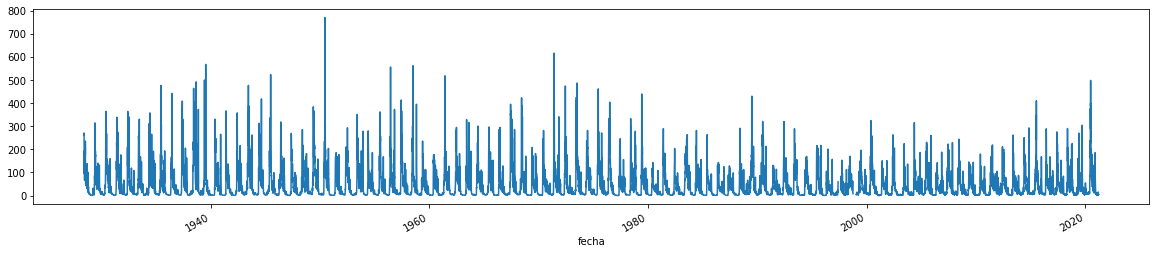

In [46]:
#Displaying data for one station
a = query('''select * from nveq.discharge as a join nveq.stations as b on b.sid=a.sid where b.stationid='50.3.0' order by fecha;''')
a.set_index('fecha',inplace=True)
a['discharge'].plot(figsize=(20,4))

In [47]:
display(query('''select * from nveq.stations where stationid = '50.3.0';  '''))

,sid,stationname,stationid,latitude,longitude,geom
0,485,Eidfjordvatn,50.3.0,60.44957,7.09805,0101000020E6100000BF7D1D3867641C40A1A17F828B39...
